## Remap Series 1: Do Mountainsort

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
#import cupy as cp
import numpy as np
import datajoint as dj
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
import json
import multiprocessing

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
import spyglass.spikesorting.v0 as ss

In [3]:
from spyglass.common import RawPosition

In [4]:
'''this cell does not import '''
from spyglass.decoding.v0.clusterless import (UnitMarks,
                                           UnitMarkParameters,UnitMarksIndicatorSelection,
                                          UnitMarksIndicator)

In [5]:
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SortInterval,
                                    SpikeSortingPreprocessingParameters,
                                    SpikeSortingRecording, 
                                    SpikeSorterParameters,
                                    SpikeSortingRecordingSelection,
                                    ArtifactDetectionParameters, ArtifactDetectionSelection,
                                    ArtifactRemovedIntervalList, ArtifactDetection,
                                      SpikeSortingSelection, SpikeSorting,
                                   CuratedSpikeSortingSelection,CuratedSpikeSorting,Curation)
from spyglass.spikesorting.v0.curation_figurl import CurationFigurl,CurationFigurlSelection
from spyglass.spikesorting.v0.spikesorting_curation import MetricParameters,MetricSelection,QualityMetrics
from spyglass.spikesorting.v0.spikesorting_curation import WaveformParameters,WaveformSelection,Waveforms
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from pprint import pprint
from spyglass.shijiegu.helpers import interval_union

### Specify date

In [10]:
#nwb_copy_file_name = "eliot20221019_.nwb"
nwb_copy_file_name = "lewis20240110_.nwb"

In [11]:
from spyglass.shijiegu.load import load_session_pos_names

In [12]:
epoch_name_pos = load_session_pos_names(nwb_copy_file_name)
epoch_name_pos

[2025-01-09 09:08:04,934][WARNING]: MySQL server has gone away. Reconnecting to the server.


{0: ['01_Rev2Sleep1', 'pos 0 valid times'],
 1: ['02_Rev2Session1', 'pos 1 valid times'],
 2: ['03_Rev2Sleep2', 'pos 2 valid times'],
 3: ['04_Rev2Session2', 'pos 3 valid times'],
 4: ['05_Rev2Sleep3', 'pos 4 valid times'],
 5: ['06_Rev2Session3', 'pos 5 valid times'],
 6: ['07_Rev2Sleep4', 'pos 6 valid times'],
 7: ['08_Rev2Session4', 'pos 7 valid times'],
 8: ['09_Rev2Sleep5', 'pos 8 valid times'],
 9: ['10_Rev2Session5', 'pos 9 valid times'],
 10: ['11_Rev2Sleep6', 'pos 10 valid times']}

In [16]:
#rawPosDf = (RawPosition() & {"nwb_file_name":nwbName,
#                             "interval_list_name":posName}).fetch1_dataframe()

In [209]:
nwbName = 'eliot20221022_.nwb'
for k in list(epoch_name_pos.keys()):
    sessionName = epoch_name_pos[k][0];
    posName = epoch_name_pos[k][1];
    rawPosDf = (RawPosition() & {"nwb_file_name":nwbName,
                                 "interval_list_name":posName}).fetch1_dataframe()
    fileName = '/cumulus/shijie/behavior_pilot/Batch1/Eliot/RawLED'+'/'+sessionName+'_'+posName+'RawPos.csv'
    rawPosDf.to_csv(fileName)
    #rawPosDf

### Specify Mountainsort parameters

In [22]:
# Let's look at the default params
sorter_name = "mountainsort4"
ms4_default_params = (
    ss.SpikeSorterParameters
    & {"sorter": sorter_name, "sorter_params_name": "default"}
).fetch1()
print(ms4_default_params)

{'sorter': 'mountainsort4', 'sorter_params_name': 'default', 'sorter_params': {'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'num_workers': 1, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10}}


In [23]:
(Raw & {"nwb_file_name": nwb_copy_file_name}).fetch1("sampling_rate")

30000.0

In [27]:
## Change default
sorter_params = {
    **ms4_default_params["sorter_params"],  # start with defaults
    "filter": False,  # No filter, since we filter prior to starting sort
    "freq_min": 0,
    "freq_max": 0,
    "whiten": False,  # Turn off whiten, since we whiten it prior to starting sort
    "num_workers": 4,  #  same number as number of electrodes
    "verbose": True,
    "clip_size": np.int64(
        1.33e-3  # same as # of samples for 1.33 ms based on the sampling rate (freq > 750Hz)
        * (Raw & {"nwb_file_name": nwb_copy_file_name}).fetch1("sampling_rate")
    ),
}


pprint(sorter_params)

{'adjacency_radius': -1,
 'clip_size': 39,
 'detect_interval': 10,
 'detect_sign': -1,
 'detect_threshold': 3,
 'filter': False,
 'freq_max': 0,
 'freq_min': 0,
 'num_workers': 4,
 'verbose': True,
 'whiten': False}


In [18]:
sorter_params_name = "CA1_tet_Shijie"
ss.SpikeSorterParameters.insert1(
    {"sorter": sorter_name,"sorter_params_name": sorter_params_name,"sorter_params": sorter_params},
    skip_duplicates=True)

AttributeError: module 'spyglass.spikesorting' has no attribute 'SpikeSorterParameters'

In [20]:
ss.SpikeSorterParameters & {"sorter": sorter_name,
                          "sorter_params_name": sorter_params_name}

AttributeError: module 'spyglass.spikesorting' has no attribute 'SpikeSorterParameters'

In [19]:
SpikeSortingSelection & {"nwb_file_name": nwb_copy_file_name,'sorter': 'mountainsort4'}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,import_path optional path to previous curated sorting output


### Specify time interval and do the Sorting. Results are in: SpikeSorting

In [24]:
def sort(sort_interval_name):
    artifact_params_name='ampl_100_prop_05_2ms'
    #sort_interval_name='04_Seq2Session2'

    artifact_key=(ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name} 
                              & {'artifact_params_name': artifact_params_name}
                              & {'sort_interval_name':sort_interval_name})
    # fetch, and there should be 2 entries, one from left cannula (group 100), and one from right cannula (group 101)
    artifact_removed_name_list=artifact_key.fetch('artifact_removed_interval_list_name')
    assert len(artifact_removed_name_list)==2

    artifact_time_list=[]
    artifact_removed_time_list=[]
    for artifact_removed_name in artifact_removed_name_list:
        artifact_time_list.append((ArtifactDetection() & {'nwb_file_name' : nwb_copy_file_name,'artifact_removed_interval_list_name':artifact_removed_name}).fetch1('artifact_times'))
        artifact_removed_time_list.append((IntervalList() & {'nwb_file_name' : nwb_copy_file_name,'interval_list_name':artifact_removed_name}).fetch1('valid_times'))

    artifact_time_list=interval_union(artifact_time_list[0],artifact_time_list[1])
    artifact_removed_time_list=interval_list_intersect(
        np.array(artifact_removed_time_list[0]),np.array(artifact_removed_time_list[1]))
    
    # find tetrodes
    tetrode_with_cell=np.unique((SpikeSortingRecordingSelection & {'nwb_file_name':nwb_copy_file_name}).fetch('sort_group_id'))
    tetrode_with_cell=np.setdiff1d(tetrode_with_cell,[100,101])
    
    # insert into individual tetrodes ArtifactRemovedIntervalList
    artifact_params_name='ampl_1500_prop_075_1ms'
    sorting_keys=[]
    for tetrode in tetrode_with_cell:
        print(tetrode,sort_interval_name)
        artifact_key = {'nwb_file_name' : nwb_copy_file_name,
                    'sort_interval_name' : sort_interval_name,
                    'sort_group_id' : tetrode,
                    'preproc_params_name': 'franklab_tetrode_hippocampus',
                    'team_name': 'Shijie Gu'}       #'SequenceTask'             
        artifact_key['artifact_params_name'] = artifact_params_name

        ArtifactDetectionSelection.insert1(artifact_key, skip_duplicates=True)

        artifact_key['artifact_times']=artifact_time_list
        artifact_key['artifact_removed_valid_times']=artifact_removed_time_list

        artifact_name=(nwb_copy_file_name+'_'+sort_interval_name+'_'+str(artifact_key['sort_group_id'])+'_'+
                       artifact_key['preproc_params_name']+'_'+artifact_params_name+'_artifact_removed_valid_times')

        artifact_key['artifact_removed_interval_list_name']=artifact_name

        ArtifactRemovedIntervalList().insert1(artifact_key,skip_duplicates=True)

        IntervalList().insert1({'nwb_file_name' : nwb_copy_file_name,
                               'interval_list_name':artifact_name,
                               'valid_times':artifact_removed_time_list},skip_duplicates=True)

        artifact_key.pop('artifact_params_name')
        artifact_key.pop('artifact_times')
        artifact_key.pop('artifact_removed_valid_times')

        artifact_key['sorter'] = sorter_name
        artifact_key['sorter_params_name'] = sorter_params_name

        SpikeSortingSelection.insert1(artifact_key, skip_duplicates=True)

        sorting_keys.append(artifact_key.copy())
    
    # populate
    SpikeSorting.populate({'nwb_file_name':nwb_copy_file_name,
                    'artifact_params_name': artifact_params_name, # make sure to inlude this
                    'sort_interval_name':sort_interval_name})
    return sorting_keys

In [25]:
for session_ind in range(len(session_interval)):
    
    session=session_interval[session_ind]
    print('session',session)
    '''
    detect spikes
    '''
    sorting_keys=sort(session)

NameError: name 'session_interval' is not defined

In [14]:
SpikeSorting & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
eliot20221019_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_b52235e0_spikesorting,1696804880
eliot20221019_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_89c0265f_spikesorting,1696806563
eliot20221019_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_0d72ddd3_spikesorting,1696808219
eliot20221019_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_e81c9a75_spikesorting,1696809862
eliot20221019_.nwb,0,10_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_10_Seq2Session5_0_franklab_tetrode_hippocampus_ac210b77_spikesorting,1696811631
eliot20221019_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_f0b10ad7_spikesorting,1696804985
eliot20221019_.nwb,2,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_04_Seq2Session2_2_franklab_tetrode_hippocampus_673f1426_spikesorting,1696806664
eliot20221019_.nwb,2,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_06_Seq2Session3_2_franklab_tetrode_hippocampus_33595a68_spikesorting,1696808322
eliot20221019_.nwb,2,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_08_Seq2Session4_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_08_Seq2Session4_2_franklab_tetrode_hippocampus_5f97698e_spikesorting,1696809967
eliot20221019_.nwb,2,10_Seq2Session5,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221019_.nwb_10_Seq2Session5_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,/stelmo/nwb/sorting/eliot20221019_.nwb_10_Seq2Session5_2_franklab_tetrode_hippocampus_e0125cd8_spikesorting,1696811744


### Insertion into Curation and CuratedSpikeSorting to allow metric calculation

In [38]:
entries=(SpikeSorting & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}).fetch(as_dict=True)
curation_keys=[]
for e in entries:
    e.pop('sorting_path')
    e.pop('time_of_sort')
    curation_keys.append(Curation.insert_curation(e))
    

In [39]:
Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,parent_curation_id,curation_labels a dictionary of labels for the units,merge_groups a list of merge groups for the units,quality_metrics a list of quality metrics for the units (if available),description optional description for this curated sort,"time_of_creation in Unix time, to the nearest second"
0,eliot20221025_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696448457
0,eliot20221025_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808586
0,eliot20221025_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808590
0,eliot20221025_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808595
0,eliot20221025_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808599
0,eliot20221025_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808603
0,eliot20221025_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808608
0,eliot20221025_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808612
0,eliot20221025_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696808617
0,eliot20221025_.nwb,2,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_01_Seq2Sleep1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,-1,=BLOB=,=BLOB=,=BLOB=,,1696448460


In [40]:
curation_keys=(Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}).fetch("KEY")
CuratedSpikeSortingSelection().insert(curation_keys,skip_duplicates=True)

In [41]:
CuratedSpikeSorting.populate(CuratedSpikeSortingSelection() & curation_keys)

Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_7FY9FL37XH.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_7FY9FL37XH.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 15 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ZG4ZDFPKF3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZG4ZDFPKF3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_VWWKXT2OW0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VWWKXT2OW0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 15 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Q844FMWO8R.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Q844FMWO8R.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 9 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_4KLJLIHB6Q.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4KLJLIHB6Q.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 12 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_BAZ0LGT6ID.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_BAZ0LGT6ID.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_S4IS4B5A5S.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_S4IS4B5A5S.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 17 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_CDHR7IY3PD.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_CDHR7IY3PD.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Q0NBIZIKAJ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Q0NBIZIKAJ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 5 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_UOA5O25S37.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_UOA5O25S37.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 5 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_4NFEFVDDRV.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4NFEFVDDRV.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 6 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_GOPAARAXYV.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_GOPAARAXYV.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 10 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6YVU7VK261.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6YVU7VK261.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 6 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ETCVGMHAQI.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ETCVGMHAQI.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_IUJPOOC2PT.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_IUJPOOC2PT.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 4 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_UKU985OSGM.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_UKU985OSGM.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QPGPT78UBJ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QPGPT78UBJ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 4 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_46ITSV393H.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_46ITSV393H.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 11 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_61UL9S9QZN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_61UL9S9QZN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 21 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NXEA8LK1EU.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NXEA8LK1EU.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 14 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_BRIK2NHFUE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_BRIK2NHFUE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 20 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6SQG213MB0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6SQG213MB0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 11 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_RBFDFX2Z02.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_RBFDFX2Z02.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 21 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_G9AVVSNLKM.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_G9AVVSNLKM.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 14 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NGC51LW07N.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NGC51LW07N.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 16 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_5SD6MTP3Z1.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_5SD6MTP3Z1.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 17 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_M20PIFL06D.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_M20PIFL06D.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 23 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QXNITYB16U.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QXNITYB16U.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 20 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QACX7SRM4W.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QACX7SRM4W.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 33 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_7LPG1KO7U5.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_7LPG1KO7U5.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 20 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_MBF82679ZQ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MBF82679ZQ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 31 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_BNHK9NSPQ2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_BNHK9NSPQ2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 19 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_L7PFS9KS47.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_L7PFS9KS47.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 33 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_LRZOMJ2HTC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LRZOMJ2HTC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 11 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JJ901HIX4J.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JJ901HIX4J.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 16 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_3EB4VYPDYS.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_3EB4VYPDYS.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 14 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_IISNB4TJOH.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_IISNB4TJOH.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 20 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WJGROD442Z.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WJGROD442Z.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 17 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_IO0X7TM2GR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_IO0X7TM2GR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 23 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JL7DLBJQLS.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JL7DLBJQLS.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 15 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_5QPAY0UB2B.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_5QPAY0UB2B.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 23 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Z2J35Y8GKO.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Z2J35Y8GKO.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 15 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_TF8J5QIURA.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_TF8J5QIURA.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 20 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_3KKOKWGK6Y.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_3KKOKWGK6Y.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JQDARSF86T.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JQDARSF86T.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 21 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_RHRFFEXSE2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_RHRFFEXSE2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_FYQ5YLLFW8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FYQ5YLLFW8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 15 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_V6LG8D0HNF.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_V6LG8D0HNF.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6W6SIABQCP.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6W6SIABQCP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 17 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_MXV1DCRHID.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MXV1DCRHID.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 20 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_9LV0N4EOUS.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_9LV0N4EOUS.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 12 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_AXCPCX3NJS.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_AXCPCX3NJS.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 15 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_X5ZC0C3K8V.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_X5ZC0C3K8V.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 11 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_LWY8LF5LDK.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LWY8LF5LDK.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 13 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_7XQKZ6BLAF.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_7XQKZ6BLAF.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 19 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_VMTEFVC349.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VMTEFVC349.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 18 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_T34BVJ26HX.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_T34BVJ26HX.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 17 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_PCSEA9R5FS.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_PCSEA9R5FS.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 18 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_2R4GJKRYMN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2R4GJKRYMN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 25 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_I7ZOYVHX2V.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_I7ZOYVHX2V.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 23 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_YR55KZGWRR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_YR55KZGWRR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 28 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NPEAJHW4TK.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NPEAJHW4TK.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 14 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_F9L8O6DW23.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_F9L8O6DW23.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 17 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QK1M7HJV9Z.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QK1M7HJV9Z.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_4G68UW6E4F.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4G68UW6E4F.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 20 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_KC7UGHY6OF.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_KC7UGHY6OF.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_TKGZ528GG8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_TKGZ528GG8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 4 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Z1H71CRXLO.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Z1H71CRXLO.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_HNZTR6SQV0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_HNZTR6SQV0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 5 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_8BX1KYCH0M.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_8BX1KYCH0M.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_VKBU6HOTF3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VKBU6HOTF3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 6 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_DVFQPW9PDW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_DVFQPW9PDW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 6 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_KXMHWILFAQ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_KXMHWILFAQ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 4 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_5HCSI5R06M.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_5HCSI5R06M.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 8 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_CD36BP9X25.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_CD36BP9X25.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 10 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_UHJSWISU50.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_UHJSWISU50.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 5 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WYYMKXQXQE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WYYMKXQXQE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 11 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1A6E3D2TSV.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1A6E3D2TSV.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 10 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_C8345PSSUB.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_C8345PSSUB.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ZL1LHA05J4.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZL1LHA05J4.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 4 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_3RAQGR0ZRX.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_3RAQGR0ZRX.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_B40SSKQZD3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_B40SSKQZD3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 5 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_9G37VEL2EZ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_9G37VEL2EZ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_7NYBHQE1PW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_7NYBHQE1PW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 16 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JSQBFE871M.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JSQBFE871M.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_VFP2O4EHIE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VFP2O4EHIE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 4 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_IKWV236S7Z.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_IKWV236S7Z.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_U5HVALZ6BO.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_U5HVALZ6BO.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 5 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_E9PEMT1LI0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_E9PEMT1LI0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WZEO9DY4WC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WZEO9DY4WC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 10 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_B8COA4DY64.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_B8COA4DY64.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 4 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ZYGHO9TKWN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZYGHO9TKWN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 6 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6X8CS4M9V2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6X8CS4M9V2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 11 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ZSKWAXA6D7.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZSKWAXA6D7.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 20 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_EX3L7VGQEW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EX3L7VGQEW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_MYNORJU4H7.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MYNORJU4H7.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 21 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_I6FANI07Y2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_I6FANI07Y2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 17 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QBU11EEYJT.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QBU11EEYJT.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 14 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ERG45VP92V.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ERG45VP92V.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 18 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_GL30E51ZSE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_GL30E51ZSE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 24 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WOZ7K5TFCC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WOZ7K5TFCC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 14 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_V02IBXCTON.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_V02IBXCTON.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 11 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_YYWE5YIQ3R.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_YYWE5YIQ3R.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 12 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_UXQGIGVW19.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_UXQGIGVW19.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 14 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_OEQXM8OO4Z.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_OEQXM8OO4Z.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 15 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_18M75R2WBE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_18M75R2WBE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 13 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WUXOCQWRC8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WUXOCQWRC8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Found 8 accepted units


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_XJN5RHKVI1.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_XJN5RHKVI1.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Found 13 accepted units
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_SYFU5QCFKK.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_SYFU5QCFKK.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


In [42]:
(CuratedSpikeSorting & {"nwb_file_name": nwb_copy_file_name,
                      "sort_interval_name": session_interval[0],"sorter":"mountainsort4"})

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,analysis_file_name name of the file,units_object_id
0,eliot20221025_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_7FY9FL37XH.nwb,4e3d1db9-c7b9-4d88-9cf7-27e3e52367d2
0,eliot20221025_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_Q0NBIZIKAJ.nwb,6e50a400-f6e1-4271-82c9-e769175d4f49
0,eliot20221025_.nwb,4,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_DCOPMH8NRF.nwb,7a61db55-faf4-4f29-b381-7f4c8faf167d
0,eliot20221025_.nwb,5,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_61UL9S9QZN.nwb,56649406-d52b-4b2e-89f7-6d6fd84b184e
0,eliot20221025_.nwb,13,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_M20PIFL06D.nwb,f5eaea6f-6397-424e-8d93-a142b25f0de9
0,eliot20221025_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_JJ901HIX4J.nwb,52e2e74f-21be-443c-b24c-e0ef21a985df
0,eliot20221025_.nwb,16,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_TF8J5QIURA.nwb,61fce668-90c0-4762-a82d-7c55d8444cdb
0,eliot20221025_.nwb,17,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_9LV0N4EOUS.nwb,c5afd869-96a0-4062-9010-54936c8b2942
0,eliot20221025_.nwb,20,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_2R4GJKRYMN.nwb,89bd1777-7f5d-4883-9009-6dc92a684723
0,eliot20221025_.nwb,26,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_26_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,eliot20221025_TKGZ528GG8.nwb,e92dfa55-2539-4e62-a26c-6ced15c8317b


### Waveform Table and Metric tables to calculate metrics for excluding noise

In [44]:
curation_keys=(Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4",}).fetch("KEY")
for d in curation_keys:
    d["waveform_params_name"]="default_clusterless"
WaveformSelection.insert(curation_keys,skip_duplicates=True)

In [ ]:
Waveforms.populate(curation_keys)

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_2S90M4ARF3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2S90M4ARF3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_VVFEHZ4KTZ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VVFEHZ4KTZ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_07MIU9DFRA.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_07MIU9DFRA.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_ZV4H1C6WKN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZV4H1C6WKN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_VFU8DSSW3Q.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VFU8DSSW3Q.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_X5SOCPDTWR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_X5SOCPDTWR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_CBEHDSR31Z.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_CBEHDSR31Z.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_Q47QG85G68.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Q47QG85G68.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_MO0GO3AXP9.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MO0GO3AXP9.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_CYALLW4JI8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_CYALLW4JI8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_W1PUNMNG1R.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_W1PUNMNG1R.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_CHQYWMFPCA.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_CHQYWMFPCA.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_W748EQGI4Q.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_W748EQGI4Q.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_2XKKG922CT.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2XKKG922CT.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_0EFOLJDQ0X.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_0EFOLJDQ0X.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_LJPW697VEN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LJPW697VEN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_E6K8TE3I6S.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_E6K8TE3I6S.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_8IBPB0J8AG.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_8IBPB0J8AG.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_SY0EJ5NAJW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_SY0EJ5NAJW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_650ITXM2X1.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_650ITXM2X1.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_5LQB3QPBRD.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_5LQB3QPBRD.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_L8GMUEP7D2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_L8GMUEP7D2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_WJAONUK8W7.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WJAONUK8W7.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_PGEPSEIY4I.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_PGEPSEIY4I.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_EMM8WOYQ0R.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EMM8WOYQ0R.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_FS55XOBH5F.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FS55XOBH5F.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_D741BHAZE6.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_D741BHAZE6.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_MTEM5O50AO.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MTEM5O50AO.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_2XAG3COCZZ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2XAG3COCZZ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_3K83TEPK8G.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_3K83TEPK8G.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_HAHC49T8TG.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_HAHC49T8TG.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_X30D2CMM5X.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_X30D2CMM5X.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_4UFX48WWE7.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4UFX48WWE7.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_VWIHL4L48I.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VWIHL4L48I.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_G8DO0SXE19.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_G8DO0SXE19.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_BR2GPKLYPV.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_BR2GPKLYPV.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_MGWK9825BD.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MGWK9825BD.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_6JRSQCQUBW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6JRSQCQUBW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_BNBQ0IPJ2B.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_BNBQ0IPJ2B.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_LMKME28DR3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LMKME28DR3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_V98UJ1LTVR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_V98UJ1LTVR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_0BEI3RUCAD.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_0BEI3RUCAD.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_8MYPKOPDEZ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_8MYPKOPDEZ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_FM1TA1126F.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FM1TA1126F.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_7R05M8I1LP.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_7R05M8I1LP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_OFZA65PPK5.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_OFZA65PPK5.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Extracting waveforms...


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fb20ac76e20>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7faf46ee2820>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fafb6987be0>
  self.pid = os.fork()
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The secon

Writing new NWB file eliot20221025_IXWOIJPX3G.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/hdmf/build/objectmapper.py:260: DtypeConversionWarning: Spec 'Units/spike_times': Value with data type int64 is being converted to data type float64 as specified.
  warnings.warn(full_warning_msg, DtypeConversionWarning)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_IXWOIJPX3G.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


In [47]:
Waveforms & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4",}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,waveform_params_name name of waveform extraction parameters,waveform_extractor_path,analysis_file_name name of the file,waveforms_object_id Object ID for the waveforms in NWB file
0,eliot20221025_.nwb,0,01_Seq2Sleep1,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_01_Seq2Sleep1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_aa02f498_0_default_clusterless_waveforms,eliot20221025_75WXQRWFXH.nwb,dc3fb887-6033-4839-8261-167a0191dbb6
0,eliot20221025_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_492d2a3e_0_default_clusterless_waveforms,eliot20221025_2S90M4ARF3.nwb,fa57016d-b614-4f4c-a510-3dab615f14bc
0,eliot20221025_.nwb,0,03_Seq2Sleep2,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_03_Seq2Sleep2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_b776bf5d_0_default_clusterless_waveforms,eliot20221025_VVFEHZ4KTZ.nwb,72543de8-15d7-4663-a24a-0faf05c1d84a
0,eliot20221025_.nwb,0,04_Seq2Session2,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_04_Seq2Session2_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_16c88540_0_default_clusterless_waveforms,eliot20221025_07MIU9DFRA.nwb,942c203f-969c-4f32-8fb7-6fff2b5a2eea
0,eliot20221025_.nwb,0,05_Seq2Sleep3,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_05_Seq2Sleep3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_c97d4260_0_default_clusterless_waveforms,eliot20221025_ZV4H1C6WKN.nwb,db9cf92b-64b6-4312-a909-056a3a709cb5
0,eliot20221025_.nwb,0,06_Seq2Session3,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_06_Seq2Session3_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_07f65f78_0_default_clusterless_waveforms,eliot20221025_VFU8DSSW3Q.nwb,1532c6cb-7b40-4cd9-b7e4-166d21294fed
0,eliot20221025_.nwb,0,07_Seq2Sleep4,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_07_Seq2Sleep4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_c8ff4c1d_0_default_clusterless_waveforms,eliot20221025_X5SOCPDTWR.nwb,ec5b55af-ffbf-4a7b-9464-7ddda47a8e21
0,eliot20221025_.nwb,0,08_Seq2Session4,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_08_Seq2Session4_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_5435dc77_0_default_clusterless_waveforms,eliot20221025_CBEHDSR31Z.nwb,b73b3bb3-6dce-4dd1-abf5-3c9d1b9be3b8
0,eliot20221025_.nwb,0,09_Seq2Sleep5,franklab_tetrode_hippocampus,SequenceTask,mountainsort4,CA1_tet_Shijie,eliot20221025_.nwb_09_Seq2Sleep5_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default_clusterless,/stelmo/nwb/waveforms/eliot20221025_.nwb_d4f3cc95_0_default_clusterless_waveforms,eliot20221025_Q47QG85G68.nwb,91608435-db9f-48e5-beb5-18aeb8d9f347
0,el

In [53]:
waveforms_keys=(Waveforms & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4",}).fetch("KEY")
for d in waveforms_keys:
    d["metric_params_name"]="franklab_default3"
MetricSelection.insert(waveforms_keys,skip_duplicates=True)

In [ ]:
session_interval

In [ ]:
for k in waveforms_keys:
    try:
        QualityMetrics.populate(k)
    except:
        print('error',k)

Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4920347, 2: 3.5743563, 3: 10.7842045, 4: 15.53211, 5: 23.615099, 6: 15.754697, 7: 30.832676, 8: 65.748695, 9: 4.459179, 10: 55.274986, 11: 3.127031}, 'isi_violation': {'1': 0.07280133847384884, '2': 0.05761567038162783, '3': 0.0, '4': 0.003367003367003367, '5': 0.0035087719298245615, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.21974265479279154, '10': 0.0, '11': 0.04860609287643099}, 'nn_isolation': {'1': 0.8163, '2': 0.5928, '3': 0.9327586206896552, '4': 0.924705882352941, '5': 0.9520979020979021, '6': 0.9304201680672269, '7': 0.9779569892473118, '8': 0.9736559139784946, '9': 0.8703, '10': 1.0, '11': 0.6414}, 'nn_noise_overlap': {'1': 0.47830000000000006, '2': 0.4687, '3': 0.006465517241379337, '4': 0.0124369747899159, '5': 0.0, '6': 0.0015384615384614886, '7': 0.00010427528675704956, '8': 0.0, '9': 0.4154, '10': 0.0, '11': 0.46520000000000006}, 'peak_channel': {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10: 2, 11: 3}, 'num_spikes': {'1': 68736,

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NRTHCF8DAX.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4920347, 2: 3.5743563, 3: 10.7842045, 4: 15.53211, 5: 23.615099, 6: 15.754697, 7: 30.832676, 8: 65.748695, 9: 4.459179, 10: 55.274986, 11: 3.127031}
Adding metric isi_violation : {'1': 0.07280133847384884, '2': 0.05761567038162783, '3': 0.0, '4': 0.003367003367003367, '5': 0.0035087719298245615, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.21974265479279154, '10': 0.0, '11': 0.04860609287643099}
Adding metric nn_isolation : {'1': 0.8163, '2': 0.5928, '3': 0.9327586206896552, '4': 0.924705882352941, '5': 0.9520979020979021, '6': 0.9304201680672269, '7': 0.9779569892473118, '8': 0.9736559139784946, '9': 0.8703, '10': 1.0, '11': 0.6414}
Adding metric nn_noise_overlap : {'1': 0.47830000000000006, '2': 0.4687, '3': 0.006465517241379337, '4': 0.0124369747899159, '5': 0.0, '6': 0.0015384615384614886, '7': 0.00010427528675704956, '8': 0.0, '9': 0.4154, '10': 0.0, '11': 0.46520000000000006}
Adding metric peak_channel : {1: 0, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2, 10:

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NRTHCF8DAX.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.6612206, 2: 17.991497, 3: 3.8648083, 4: 14.945093, 5: 9.110658, 6: 12.471893, 7: 4.4632134, 8: 38.315197, 9: 43.52044, 10: 14.8236885, 11: 32.13545, 12: 3.3334155}, 'isi_violation': {'1': 0.05417921856031653, '2': 0.0, '3': 0.029706132879045995, '4': 0.0025477707006369425, '5': 0.0, '6': 0.002260083449235049, '7': 0.16728077955629103, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.03942721943640087}, 'nn_isolation': {'1': 0.9144, '2': 0.9976576576576577, '3': 0.5468, '4': 0.9067079463364293, '5': 0.9108359133126935, '6': 0.98296488946684, '7': 0.9032, '8': 0.9964601769911505, '9': 0.997444089456869, '10': 0.9824447334200259, '11': 0.9916932907348242, '12': 0.5585}, 'nn_noise_overlap': {'1': 0.4583999999999999, '2': 0.00018018018018017834, '3': 0.4254, '4': 0.002100000000000102, '5': 0.004747162022703755, '6': 0.0019000000000000128, '7': 0.2902, '8': 0.0026548672566372167, '9': 0.0, '10': 0.0007802340702210975, '11': 0.0, '12': 0.46820000000000006}

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_SHCV6L6N2X.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.6612206, 2: 17.991497, 3: 3.8648083, 4: 14.945093, 5: 9.110658, 6: 12.471893, 7: 4.4632134, 8: 38.315197, 9: 43.52044, 10: 14.8236885, 11: 32.13545, 12: 3.3334155}
Adding metric isi_violation : {'1': 0.05417921856031653, '2': 0.0, '3': 0.029706132879045995, '4': 0.0025477707006369425, '5': 0.0, '6': 0.002260083449235049, '7': 0.16728077955629103, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.03942721943640087}
Adding metric nn_isolation : {'1': 0.9144, '2': 0.9976576576576577, '3': 0.5468, '4': 0.9067079463364293, '5': 0.9108359133126935, '6': 0.98296488946684, '7': 0.9032, '8': 0.9964601769911505, '9': 0.997444089456869, '10': 0.9824447334200259, '11': 0.9916932907348242, '12': 0.5585}
Adding metric nn_noise_overlap : {'1': 0.4583999999999999, '2': 0.00018018018018017834, '3': 0.4254, '4': 0.002100000000000102, '5': 0.004747162022703755, '6': 0.0019000000000000128, '7': 0.2902, '8': 0.0026548672566372167, '9': 0.0, '10': 0.0007802340702210975, '11': 0.0, 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_SHCV6L6N2X.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.8766456, 2: 23.737757, 3: 27.619743, 4: 3.9758954, 5: 16.784546, 6: 12.261148, 7: 5.922675, 8: 25.530056, 9: 34.536777, 10: 30.109709, 11: 28.638126, 12: 7.0992513, 13: 3.2699456, 14: 12.431881, 15: 8.028825}, 'isi_violation': {'1': 0.015332877336981304, '2': 0.0, '3': 0.0008067769261799112, '4': 0.05683782849239281, '5': 0.0011156563778356265, '6': 0.0015503875968992248, '7': 0.05389816746230628, '8': 0.001292824822236587, '9': 0.0, '10': 0.00017970259220989262, '11': 0.0, '12': 0.0025806451612903226, '13': 0.04599328308665599, '14': 0.0, '15': 0.0}, 'nn_isolation': {'1': 0.8377000000000001, '2': 0.9814285714285715, '3': 0.9535, '4': 0.5841999999999999, '5': 0.9475232198142415, '6': 0.9298761609907121, '7': 0.9166000000000001, '8': 0.9762000000000001, '9': 0.9774193548387096, '10': 0.9864, '11': 0.9919014084507042, '12': 0.9305999999999999, '13': 0.5775, '14': 0.9845070422535211, '15': 0.9969543147208121}, 'nn_noise_overlap': {'1': 0.237600000000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_FDKHQX9NEZ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.8766456, 2: 23.737757, 3: 27.619743, 4: 3.9758954, 5: 16.784546, 6: 12.261148, 7: 5.922675, 8: 25.530056, 9: 34.536777, 10: 30.109709, 11: 28.638126, 12: 7.0992513, 13: 3.2699456, 14: 12.431881, 15: 8.028825}
Adding metric isi_violation : {'1': 0.015332877336981304, '2': 0.0, '3': 0.0008067769261799112, '4': 0.05683782849239281, '5': 0.0011156563778356265, '6': 0.0015503875968992248, '7': 0.05389816746230628, '8': 0.001292824822236587, '9': 0.0, '10': 0.00017970259220989262, '11': 0.0, '12': 0.0025806451612903226, '13': 0.04599328308665599, '14': 0.0, '15': 0.0}
Adding metric nn_isolation : {'1': 0.8377000000000001, '2': 0.9814285714285715, '3': 0.9535, '4': 0.5841999999999999, '5': 0.9475232198142415, '6': 0.9298761609907121, '7': 0.9166000000000001, '8': 0.9762000000000001, '9': 0.9774193548387096, '10': 0.9864, '11': 0.9919014084507042, '12': 0.9305999999999999, '13': 0.5775, '14': 0.9845070422535211, '15': 0.9969543147208121}
Adding metric nn_noise_overlap

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FDKHQX9NEZ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.228478, 2: 20.362408, 3: 32.21297, 4: 3.800839, 5: 10.654683, 6: 17.376303, 7: 4.988841, 8: 14.396218, 9: 19.123667, 10: 37.656494, 11: 11.212416, 12: 3.2375808}, 'isi_violation': {'1': 0.050260243505376834, '2': 0.0, '3': 0.001610305958132045, '4': 0.04569630531871701, '5': 0.0, '6': 0.0, '7': 0.15761878826455283, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.04067491900597389}, 'nn_isolation': {'1': 0.8961, '2': 0.9731481481481481, '3': 0.9727777777777777, '4': 0.5562, '5': 0.8535999999999999, '6': 0.8577, '7': 0.8967, '8': 0.9435, '9': 0.952, '10': 0.9949664429530202, '11': 0.9833976833976834, '12': 0.5644}, 'nn_noise_overlap': {'1': 0.4184, '2': 0.002777777777777879, '3': 0.000803858520900369, '4': 0.44420000000000004, '5': 0.005199999999999982, '6': 0.0016999999999999238, '7': 0.28159999999999996, '8': 0.0028000000000000247, '9': 0.0012999999999999678, '10': 0.0023489932885907283, '11': 0.0025096525096526268, '12': 0.46340000000000003}, 'pea

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QLM52XDINO.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.228478, 2: 20.362408, 3: 32.21297, 4: 3.800839, 5: 10.654683, 6: 17.376303, 7: 4.988841, 8: 14.396218, 9: 19.123667, 10: 37.656494, 11: 11.212416, 12: 3.2375808}
Adding metric isi_violation : {'1': 0.050260243505376834, '2': 0.0, '3': 0.001610305958132045, '4': 0.04569630531871701, '5': 0.0, '6': 0.0, '7': 0.15761878826455283, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.04067491900597389}
Adding metric nn_isolation : {'1': 0.8961, '2': 0.9731481481481481, '3': 0.9727777777777777, '4': 0.5562, '5': 0.8535999999999999, '6': 0.8577, '7': 0.8967, '8': 0.9435, '9': 0.952, '10': 0.9949664429530202, '11': 0.9833976833976834, '12': 0.5644}
Adding metric nn_noise_overlap : {'1': 0.4184, '2': 0.002777777777777879, '3': 0.000803858520900369, '4': 0.44420000000000004, '5': 0.005199999999999982, '6': 0.0016999999999999238, '7': 0.28159999999999996, '8': 0.0028000000000000247, '9': 0.0012999999999999678, '10': 0.0023489932885907283, '11': 0.0025096525096526268, '12': 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QLM52XDINO.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.8226666, 2: 22.262259, 3: 9.17729, 4: 30.85815, 5: 3.760691, 6: 16.959946, 7: 23.22245, 8: 4.608584, 9: 6.46543, 10: 8.274042, 11: 23.988253, 12: 18.00028, 13: 41.05804, 14: 59.79628, 15: 3.159493}, 'isi_violation': {'1': 0.03378264057300773, '2': 0.002028397565922921, '3': 0.0, '4': 0.0, '5': 0.049347949347949345, '6': 0.009535918626827717, '7': 0.0, '8': 0.1610458104213087, '9': 0.00480165140908275, '10': 0.0012599340957549913, '11': 0.0014634146341463415, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.04085153639455445}, 'nn_isolation': {'1': 0.9048, '2': 0.9809716599190283, '3': 0.991701244813278, '4': 0.9755060728744939, '5': 0.5727, '6': 0.9170999999999999, '7': 0.9188000000000001, '8': 0.913, '9': 0.9486000000000001, '10': 0.9511, '11': 0.9573498964803312, '12': 0.9512422360248447, '13': 0.9872093023255815, '14': 0.9946428571428572, '15': 0.5616}, 'nn_noise_overlap': {'1': 0.3929, '2': 0.0026315789473685403, '3': 0.007053941908713668, '4': 0.0005000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_BI0LSKUU0Z.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.8226666, 2: 22.262259, 3: 9.17729, 4: 30.85815, 5: 3.760691, 6: 16.959946, 7: 23.22245, 8: 4.608584, 9: 6.46543, 10: 8.274042, 11: 23.988253, 12: 18.00028, 13: 41.05804, 14: 59.79628, 15: 3.159493}
Adding metric isi_violation : {'1': 0.03378264057300773, '2': 0.002028397565922921, '3': 0.0, '4': 0.0, '5': 0.049347949347949345, '6': 0.009535918626827717, '7': 0.0, '8': 0.1610458104213087, '9': 0.00480165140908275, '10': 0.0012599340957549913, '11': 0.0014634146341463415, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.04085153639455445}
Adding metric nn_isolation : {'1': 0.9048, '2': 0.9809716599190283, '3': 0.991701244813278, '4': 0.9755060728744939, '5': 0.5727, '6': 0.9170999999999999, '7': 0.9188000000000001, '8': 0.913, '9': 0.9486000000000001, '10': 0.9511, '11': 0.9573498964803312, '12': 0.9512422360248447, '13': 0.9872093023255815, '14': 0.9946428571428572, '15': 0.5616}
Adding metric nn_noise_overlap : {'1': 0.3929, '2': 0.0026315789473685403, '3': 0.00705394

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_BI0LSKUU0Z.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4831994, 2: 26.672043, 3: 3.6932616, 4: 17.168081, 5: 9.519769, 6: 4.7006245, 7: 18.904331, 8: 8.485454, 9: 3.1422374}, 'isi_violation': {'1': 0.04019620173563074, '2': 0.0, '3': 0.04405368848194777, '4': 0.0009487666034155598, '5': 0.0006317119393556538, '6': 0.18065953498653356, '7': 0.0, '8': 0.0, '9': 0.0426248187279884}, 'nn_isolation': {'1': 0.9172, '2': 0.9993775933609959, '3': 0.5727, '4': 0.9238, '5': 0.9215, '6': 0.9284000000000001, '7': 0.9953, '8': 0.9884999999999999, '9': 0.6779}, 'nn_noise_overlap': {'1': 0.4618, '2': 0.0, '3': 0.47329999999999994, '4': 0.0, '5': 0.0041999999999999815, '6': 0.37640000000000007, '7': 0.0, '8': 0.007399999999999962, '9': 0.4865999999999999}, 'peak_channel': {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 3, 9: 3}, 'num_spikes': {'1': 39756, '2': 482, '3': 48056, '4': 1055, '5': 1584, '6': 171910, '7': 1272, '8': 1738, '9': 57925}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_9GJE6109SG.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4831994, 2: 26.672043, 3: 3.6932616, 4: 17.168081, 5: 9.519769, 6: 4.7006245, 7: 18.904331, 8: 8.485454, 9: 3.1422374}
Adding metric isi_violation : {'1': 0.04019620173563074, '2': 0.0, '3': 0.04405368848194777, '4': 0.0009487666034155598, '5': 0.0006317119393556538, '6': 0.18065953498653356, '7': 0.0, '8': 0.0, '9': 0.0426248187279884}
Adding metric nn_isolation : {'1': 0.9172, '2': 0.9993775933609959, '3': 0.5727, '4': 0.9238, '5': 0.9215, '6': 0.9284000000000001, '7': 0.9953, '8': 0.9884999999999999, '9': 0.6779}
Adding metric nn_noise_overlap : {'1': 0.4618, '2': 0.0, '3': 0.47329999999999994, '4': 0.0, '5': 0.0041999999999999815, '6': 0.37640000000000007, '7': 0.0, '8': 0.007399999999999962, '9': 0.4865999999999999}
Adding metric peak_channel : {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 3, 9: 3}
Adding metric num_spikes : {'1': 39756, '2': 482, '3': 48056, '4': 1055, '5': 1584, '6': 171910, '7': 1272, '8': 1738, '9': 57925}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_9GJE6109SG.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.8073306, 2: 34.175034, 3: 19.90545, 4: 5.229788, 5: 19.49759, 6: 20.402409, 7: 23.941938, 8: 6.768393, 9: 34.727966, 10: 69.254524, 11: 7.602124, 12: 3.1822135}, 'isi_violation': {'1': 0.025746903084770463, '2': 0.0, '3': 0.0, '4': 0.05829800933626657, '5': 0.001841620626151013, '6': 0.0009910802775024777, '7': 0.0, '8': 0.10578813988849468, '9': 0.0013513513513513514, '10': 0.0, '11': 0.0012787723785166241, '12': 0.04701873264128272}, 'nn_isolation': {'1': 0.8314, '2': 0.9918322295805739, '3': 0.9735099337748345, '4': 0.6463, '5': 0.9327205882352942, '6': 0.8900390625, '7': 0.8927734375, '8': 0.9358000000000001, '9': 0.9886029411764706, '10': 0.9983606557377049, '11': 0.9559, '12': 0.6161}, 'nn_noise_overlap': {'1': 0.28490000000000004, '2': 0.0006000000000000449, '3': 0.004415011037527505, '4': 0.3657, '5': 0.0014705882352942234, '6': 0.0031000000000001027, '7': 0.0005859375000000222, '8': 0.2127, '9': 0.0012000000000000899, '10': 0.0, '11': 0.0131

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_O3WAXLRYXE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.8073306, 2: 34.175034, 3: 19.90545, 4: 5.229788, 5: 19.49759, 6: 20.402409, 7: 23.941938, 8: 6.768393, 9: 34.727966, 10: 69.254524, 11: 7.602124, 12: 3.1822135}
Adding metric isi_violation : {'1': 0.025746903084770463, '2': 0.0, '3': 0.0, '4': 0.05829800933626657, '5': 0.001841620626151013, '6': 0.0009910802775024777, '7': 0.0, '8': 0.10578813988849468, '9': 0.0013513513513513514, '10': 0.0, '11': 0.0012787723785166241, '12': 0.04701873264128272}
Adding metric nn_isolation : {'1': 0.8314, '2': 0.9918322295805739, '3': 0.9735099337748345, '4': 0.6463, '5': 0.9327205882352942, '6': 0.8900390625, '7': 0.8927734375, '8': 0.9358000000000001, '9': 0.9886029411764706, '10': 0.9983606557377049, '11': 0.9559, '12': 0.6161}
Adding metric nn_noise_overlap : {'1': 0.28490000000000004, '2': 0.0006000000000000449, '3': 0.004415011037527505, '4': 0.3657, '5': 0.0014705882352942234, '6': 0.0031000000000001027, '7': 0.0005859375000000222, '8': 0.2127, '9': 0.001200000000000089

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_O3WAXLRYXE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4319358, 2: 13.779451, 3: 30.072336, 4: 3.8030396, 5: 17.641459, 6: 23.093916, 7: 17.7065, 8: 4.5254736, 9: 33.528893, 10: 3.128219, 11: 8.858257, 12: 7.91625}, 'isi_violation': {'1': 0.05303379416282642, '2': 0.0, '3': 0.0, '4': 0.05726888173831303, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.14922892964532522, '9': 0.1357142857142857, '10': 0.044710281731048504, '11': 0.0, '12': 0.0}, 'nn_isolation': {'1': 0.9046, '2': 0.9897500000000001, '3': 0.99075, '4': 0.6754, '5': 0.9941000000000001, '6': 0.8966996699669967, '7': 0.9023102310231023, '8': 0.9035, '9': 0.9914893617021276, '10': 0.5730999999999999, '11': 0.966504854368932, '12': 0.9597087378640777}, 'nn_noise_overlap': {'1': 0.4495, '2': 0.00275000000000003, '3': 0.0, '4': 0.4280999999999999, '5': 0.0026999999999999247, '6': 0.0006600660066006236, '7': 0.0010999999999998789, '8': 0.32220000000000004, '9': 0.0, '10': 0.45130000000000003, '11': 0.006323529411764617, '12': 0.03786407766990296}, 'peak_chan

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_AR3MTSFWU8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4319358, 2: 13.779451, 3: 30.072336, 4: 3.8030396, 5: 17.641459, 6: 23.093916, 7: 17.7065, 8: 4.5254736, 9: 33.528893, 10: 3.128219, 11: 8.858257, 12: 7.91625}
Adding metric isi_violation : {'1': 0.05303379416282642, '2': 0.0, '3': 0.0, '4': 0.05726888173831303, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.14922892964532522, '9': 0.1357142857142857, '10': 0.044710281731048504, '11': 0.0, '12': 0.0}
Adding metric nn_isolation : {'1': 0.9046, '2': 0.9897500000000001, '3': 0.99075, '4': 0.6754, '5': 0.9941000000000001, '6': 0.8966996699669967, '7': 0.9023102310231023, '8': 0.9035, '9': 0.9914893617021276, '10': 0.5730999999999999, '11': 0.966504854368932, '12': 0.9597087378640777}
Adding metric nn_noise_overlap : {'1': 0.4495, '2': 0.00275000000000003, '3': 0.0, '4': 0.4280999999999999, '5': 0.0026999999999999247, '6': 0.0006600660066006236, '7': 0.0010999999999998789, '8': 0.32220000000000004, '9': 0.0, '10': 0.45130000000000003, '11': 0.006323529411764617, '12': 0.0378

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_AR3MTSFWU8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.032015, 2: 19.465511, 3: 26.67719, 4: 35.92967, 5: 4.3096566, 6: 14.558487, 7: 23.520775, 8: 20.488123, 9: 4.3136115, 10: 6.843498, 11: 6.027836, 12: 33.993996, 13: 23.96767, 14: 35.663128, 15: 33.463615, 16: 3.147177, 17: 6.687245}, 'isi_violation': {'1': 0.048953684419319646, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.035229793160365196, '6': 0.004186602870813397, '7': 0.001221001221001221, '8': 0.0, '9': 0.1211032111883741, '10': 0.014946319556522349, '11': 0.001932574618853339, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.03780431130018232, '17': 0.0007913479293062516}, 'nn_isolation': {'1': 0.913, '2': 0.9896984924623116, '3': 0.9511415525114156, '4': 0.9512557077625571, '5': 0.6466000000000001, '6': 0.9231707317073171, '7': 0.9221951219512196, '8': 0.9929411764705882, '9': 0.9309, '10': 0.9417, '11': 0.9518000000000001, '12': 0.9870229007633589, '13': 0.9521428571428572, '14': 0.9585714285714285, '15': 0.9687022900763358, '16': 0.6226, '17': 0

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NFS2IV2W7V.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.032015, 2: 19.465511, 3: 26.67719, 4: 35.92967, 5: 4.3096566, 6: 14.558487, 7: 23.520775, 8: 20.488123, 9: 4.3136115, 10: 6.843498, 11: 6.027836, 12: 33.993996, 13: 23.96767, 14: 35.663128, 15: 33.463615, 16: 3.147177, 17: 6.687245}
Adding metric isi_violation : {'1': 0.048953684419319646, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.035229793160365196, '6': 0.004186602870813397, '7': 0.001221001221001221, '8': 0.0, '9': 0.1211032111883741, '10': 0.014946319556522349, '11': 0.001932574618853339, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.03780431130018232, '17': 0.0007913479293062516}
Adding metric nn_isolation : {'1': 0.913, '2': 0.9896984924623116, '3': 0.9511415525114156, '4': 0.9512557077625571, '5': 0.6466000000000001, '6': 0.9231707317073171, '7': 0.9221951219512196, '8': 0.9929411764705882, '9': 0.9309, '10': 0.9417, '11': 0.9518000000000001, '12': 0.9870229007633589, '13': 0.9521428571428572, '14': 0.9585714285714285, '15': 0.9687022900763358, '16': 0

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NFS2IV2W7V.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.3660378, 2: 3.1189582, 3: 6.9795394, 4: 3.5160162, 5: 2.9687455}, 'isi_violation': {'1': 0.0974444816426738, '2': 0.06561616046172748, '3': 0.0, '4': 0.060841121495327104, '5': 0.04312642056587507}, 'nn_isolation': {'1': 0.5291, '2': 0.5216000000000001, '3': 0.9968999999999999, '4': 0.526, '5': 0.5945}, 'nn_noise_overlap': {'1': 0.47450000000000003, '2': 0.48840000000000006, '3': 0.00039999999999995595, '4': 0.4804999999999999, '5': 0.4787}, 'peak_channel': {1: 8, 2: 9, 3: 9, 4: 10, 5: 11}, 'num_spikes': {'1': 89611, '2': 69999, '3': 1018, '4': 64201, '5': 51037}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_3VE0GQ31GW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.3660378, 2: 3.1189582, 3: 6.9795394, 4: 3.5160162, 5: 2.9687455}
Adding metric isi_violation : {'1': 0.0974444816426738, '2': 0.06561616046172748, '3': 0.0, '4': 0.060841121495327104, '5': 0.04312642056587507}
Adding metric nn_isolation : {'1': 0.5291, '2': 0.5216000000000001, '3': 0.9968999999999999, '4': 0.526, '5': 0.5945}
Adding metric nn_noise_overlap : {'1': 0.47450000000000003, '2': 0.48840000000000006, '3': 0.00039999999999995595, '4': 0.4804999999999999, '5': 0.4787}
Adding metric peak_channel : {1: 8, 2: 9, 3: 9, 4: 10, 5: 11}
Adding metric num_spikes : {'1': 89611, '2': 69999, '3': 1018, '4': 64201, '5': 51037}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_3VE0GQ31GW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.7548158, 2: 4.0046153, 3: 3.570116, 4: 3.0682704}, 'isi_violation': {'1': 0.11512176184660676, '2': 0.076056474228798, '3': 0.07295413669064749, '4': 0.041517761565191616}, 'nn_isolation': {'1': 0.5934999999999999, '2': 0.5194, '3': 0.5171, '4': 0.6509}, 'nn_noise_overlap': {'1': 0.44210000000000005, '2': 0.44710000000000005, '3': 0.46029999999999993, '4': 0.4558}, 'peak_channel': {1: 8, 2: 9, 3: 10, 4: 11}, 'num_spikes': {'1': 123644, '2': 103411, '3': 88961, '4': 60722}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_FUC9B6G8ED.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.7548158, 2: 4.0046153, 3: 3.570116, 4: 3.0682704}
Adding metric isi_violation : {'1': 0.11512176184660676, '2': 0.076056474228798, '3': 0.07295413669064749, '4': 0.041517761565191616}
Adding metric nn_isolation : {'1': 0.5934999999999999, '2': 0.5194, '3': 0.5171, '4': 0.6509}
Adding metric nn_noise_overlap : {'1': 0.44210000000000005, '2': 0.44710000000000005, '3': 0.46029999999999993, '4': 0.4558}
Adding metric peak_channel : {1: 8, 2: 9, 3: 10, 4: 11}
Adding metric num_spikes : {'1': 123644, '2': 103411, '3': 88961, '4': 60722}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FUC9B6G8ED.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.5205138, 2: 3.3000278, 3: 7.2493305, 4: 3.5745065, 5: 2.9682598}, 'isi_violation': {'1': 0.11324665626286513, '2': 0.06742094651952461, '3': 0.0, '4': 0.06714792765530211, '5': 0.039861128970039864}, 'nn_isolation': {'1': 0.5543, '2': 0.5037, '3': 0.9952, '4': 0.5048, '5': 0.6206}, 'nn_noise_overlap': {'1': 0.4766, '2': 0.4804999999999999, '3': 0.0013999999999999568, '4': 0.49249999999999994, '5': 0.4926999999999999}, 'peak_channel': {1: 8, 2: 9, 3: 9, 4: 10, 5: 11}, 'num_spikes': {'1': 208899, '2': 150785, '3': 1931, '4': 141435, '5': 101102}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_9E80IV14HR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.5205138, 2: 3.3000278, 3: 7.2493305, 4: 3.5745065, 5: 2.9682598}
Adding metric isi_violation : {'1': 0.11324665626286513, '2': 0.06742094651952461, '3': 0.0, '4': 0.06714792765530211, '5': 0.039861128970039864}
Adding metric nn_isolation : {'1': 0.5543, '2': 0.5037, '3': 0.9952, '4': 0.5048, '5': 0.6206}
Adding metric nn_noise_overlap : {'1': 0.4766, '2': 0.4804999999999999, '3': 0.0013999999999999568, '4': 0.49249999999999994, '5': 0.4926999999999999}
Adding metric peak_channel : {1: 8, 2: 9, 3: 9, 4: 10, 5: 11}
Adding metric num_spikes : {'1': 208899, '2': 150785, '3': 1931, '4': 141435, '5': 101102}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_9E80IV14HR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.491734, 2: 4.136129, 3: 8.278147, 4: 3.642986, 5: 3.1124005}, 'isi_violation': {'1': 0.08782890347312362, '2': 0.06093620760959471, '3': 0.0, '4': 0.057761843947623515, '5': 0.03931043489617344}, 'nn_isolation': {'1': 0.5695, '2': 0.5239, '3': 0.9887, '4': 0.52, '5': 0.6009}, 'nn_noise_overlap': {'1': 0.4275, '2': 0.4235, '3': 0.0031000000000001027, '4': 0.46009999999999995, '5': 0.4777}, 'peak_channel': {1: 8, 2: 9, 3: 9, 4: 10, 5: 11}, 'num_spikes': {'1': 82434, '2': 77377, '3': 1267, '4': 64992, '5': 53600}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Z81Y6C6EX3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.491734, 2: 4.136129, 3: 8.278147, 4: 3.642986, 5: 3.1124005}
Adding metric isi_violation : {'1': 0.08782890347312362, '2': 0.06093620760959471, '3': 0.0, '4': 0.057761843947623515, '5': 0.03931043489617344}
Adding metric nn_isolation : {'1': 0.5695, '2': 0.5239, '3': 0.9887, '4': 0.52, '5': 0.6009}
Adding metric nn_noise_overlap : {'1': 0.4275, '2': 0.4235, '3': 0.0031000000000001027, '4': 0.46009999999999995, '5': 0.4777}
Adding metric peak_channel : {1: 8, 2: 9, 3: 9, 4: 10, 5: 11}
Adding metric num_spikes : {'1': 82434, '2': 77377, '3': 1267, '4': 64992, '5': 53600}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Z81Y6C6EX3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.9510942, 2: 7.7387924, 3: 3.6299288, 4: 3.312546, 5: 9.243132, 6: 3.0113592}, 'isi_violation': {'1': 0.1061921121341212, '2': 0.0, '3': 0.06483351528384279, '4': 0.05531863533955584, '5': 0.0, '6': 0.04043541447012225}, 'nn_isolation': {'1': 0.5371, '2': 0.9956762749445677, '3': 0.5282, '4': 0.5126999999999999, '5': 0.9912000000000001, '6': 0.5965}, 'nn_noise_overlap': {'1': 0.4629, '2': 0.0008869179600887733, '3': 0.46929999999999994, '4': 0.47550000000000003, '5': 0.0021999999999999797, '6': 0.4839}, 'peak_channel': {1: 8, 2: 9, 3: 9, 4: 10, 5: 10, 6: 11}, 'num_spikes': {'1': 181926, '2': 902, '3': 146561, '4': 124281, '5': 1762, '6': 105280}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_O0737ZHUJZ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.9510942, 2: 7.7387924, 3: 3.6299288, 4: 3.312546, 5: 9.243132, 6: 3.0113592}
Adding metric isi_violation : {'1': 0.1061921121341212, '2': 0.0, '3': 0.06483351528384279, '4': 0.05531863533955584, '5': 0.0, '6': 0.04043541447012225}
Adding metric nn_isolation : {'1': 0.5371, '2': 0.9956762749445677, '3': 0.5282, '4': 0.5126999999999999, '5': 0.9912000000000001, '6': 0.5965}
Adding metric nn_noise_overlap : {'1': 0.4629, '2': 0.0008869179600887733, '3': 0.46929999999999994, '4': 0.47550000000000003, '5': 0.0021999999999999797, '6': 0.4839}
Adding metric peak_channel : {1: 8, 2: 9, 3: 9, 4: 10, 5: 10, 6: 11}
Adding metric num_spikes : {'1': 181926, '2': 902, '3': 146561, '4': 124281, '5': 1762, '6': 105280}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_O0737ZHUJZ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.138322, 2: 12.408555, 3: 12.119365, 4: 12.902313, 5: 17.230968, 6: 9.180223, 7: 4.2748566, 8: 7.8546205, 9: 3.9441247, 10: 3.0147388}, 'isi_violation': {'1': 0.09435009797517963, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.07163126666093388, '8': 0.0, '9': 0.06388464329273, '10': 0.05163818888163097}, 'nn_isolation': {'1': 0.5578000000000001, '2': 0.9013574660633484, '3': 0.6960975609756097, '4': 0.6858536585365853, '5': 0.8322463768115942, '6': 0.9861000000000001, '7': 0.5509000000000001, '8': 0.9974999999999999, '9': 0.5526, '10': 0.5860000000000001}, 'nn_noise_overlap': {'1': 0.41569999999999996, '2': 0.006861642294713199, '3': 0.0036231884057971175, '4': 0.0029268292682926855, '5': 0.0037707390648566985, '6': 0.00649999999999995, '7': 0.4011, '8': 0.0010000000000000009, '9': 0.44509999999999994, '10': 0.4869}, 'peak_channel': {1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 9, 8: 9, 9: 10, 10: 11}, 'num_spikes': {'1': 91861, '2': 889, '3': 27

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6ALNVIMSU8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.138322, 2: 12.408555, 3: 12.119365, 4: 12.902313, 5: 17.230968, 6: 9.180223, 7: 4.2748566, 8: 7.8546205, 9: 3.9441247, 10: 3.0147388}
Adding metric isi_violation : {'1': 0.09435009797517963, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.07163126666093388, '8': 0.0, '9': 0.06388464329273, '10': 0.05163818888163097}
Adding metric nn_isolation : {'1': 0.5578000000000001, '2': 0.9013574660633484, '3': 0.6960975609756097, '4': 0.6858536585365853, '5': 0.8322463768115942, '6': 0.9861000000000001, '7': 0.5509000000000001, '8': 0.9974999999999999, '9': 0.5526, '10': 0.5860000000000001}
Adding metric nn_noise_overlap : {'1': 0.41569999999999996, '2': 0.006861642294713199, '3': 0.0036231884057971175, '4': 0.0029268292682926855, '5': 0.0037707390648566985, '6': 0.00649999999999995, '7': 0.4011, '8': 0.0010000000000000009, '9': 0.44509999999999994, '10': 0.4869}
Adding metric peak_channel : {1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 9, 8: 9, 9: 10, 10: 11}
Adding 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6ALNVIMSU8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.4032154, 2: 3.9074388, 3: 8.937316, 4: 3.486105, 5: 3.2685237, 6: 12.222458}, 'isi_violation': {'1': 0.13317962975520445, '2': 0.07565564424173318, '3': 0.0, '4': 0.06439511271726037, '5': 0.04707049130302106, '6': 0.0}, 'nn_isolation': {'1': 0.5606, '2': 0.5224, '3': 0.9953398058252427, '4': 0.5236, '5': 0.575, '6': 0.9928143712574851}, 'nn_noise_overlap': {'1': 0.4222, '2': 0.476, '3': 0.0017475728155339487, '4': 0.4637, '5': 0.49560000000000004, '6': 0.004491017964071808}, 'peak_channel': {1: 8, 2: 9, 3: 9, 4: 10, 5: 11, 6: 11}, 'num_spikes': {'1': 88483, '2': 70161, '3': 515, '4': 58111, '5': 52433, '6': 334}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_UBWX9IHE17.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.4032154, 2: 3.9074388, 3: 8.937316, 4: 3.486105, 5: 3.2685237, 6: 12.222458}
Adding metric isi_violation : {'1': 0.13317962975520445, '2': 0.07565564424173318, '3': 0.0, '4': 0.06439511271726037, '5': 0.04707049130302106, '6': 0.0}
Adding metric nn_isolation : {'1': 0.5606, '2': 0.5224, '3': 0.9953398058252427, '4': 0.5236, '5': 0.575, '6': 0.9928143712574851}
Adding metric nn_noise_overlap : {'1': 0.4222, '2': 0.476, '3': 0.0017475728155339487, '4': 0.4637, '5': 0.49560000000000004, '6': 0.004491017964071808}
Adding metric peak_channel : {1: 8, 2: 9, 3: 9, 4: 10, 5: 11, 6: 11}
Adding metric num_spikes : {'1': 88483, '2': 70161, '3': 515, '4': 58111, '5': 52433, '6': 334}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_UBWX9IHE17.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.1916194, 2: 11.862308, 3: 16.632524, 4: 4.2033167, 5: 8.248377, 6: 3.8597164, 7: 3.1778152}, 'isi_violation': {'1': 0.10026690391459074, '2': 0.0, '3': 0.0, '4': 0.07025296056393675, '5': 0.0, '6': 0.06673678596823891, '7': 0.0385516781698166}, 'nn_isolation': {'1': 0.5686, '2': 0.851063829787234, '3': 0.8656737588652483, '4': 0.5553, '5': 0.9936810431293882, '6': 0.5588, '7': 0.6069}, 'nn_noise_overlap': {'1': 0.44800000000000006, '2': 0.011400000000000077, '3': 0.00496453900709215, '4': 0.44509999999999994, '5': 0.0022066198595787068, '6': 0.4724999999999999, '7': 0.4879}, 'peak_channel': {1: 8, 2: 8, 3: 8, 4: 9, 5: 9, 6: 10, 7: 11}, 'num_spikes': {'1': 89921, '2': 1385, '3': 705, '4': 96182, '5': 997, '6': 67505, '7': 46510}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JSF4Q7X5AQ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.1916194, 2: 11.862308, 3: 16.632524, 4: 4.2033167, 5: 8.248377, 6: 3.8597164, 7: 3.1778152}
Adding metric isi_violation : {'1': 0.10026690391459074, '2': 0.0, '3': 0.0, '4': 0.07025296056393675, '5': 0.0, '6': 0.06673678596823891, '7': 0.0385516781698166}
Adding metric nn_isolation : {'1': 0.5686, '2': 0.851063829787234, '3': 0.8656737588652483, '4': 0.5553, '5': 0.9936810431293882, '6': 0.5588, '7': 0.6069}
Adding metric nn_noise_overlap : {'1': 0.44800000000000006, '2': 0.011400000000000077, '3': 0.00496453900709215, '4': 0.44509999999999994, '5': 0.0022066198595787068, '6': 0.4724999999999999, '7': 0.4879}
Adding metric peak_channel : {1: 8, 2: 8, 3: 8, 4: 9, 5: 9, 6: 10, 7: 11}
Adding metric num_spikes : {'1': 89921, '2': 1385, '3': 705, '4': 96182, '5': 997, '6': 67505, '7': 46510}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JSF4Q7X5AQ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.081036, 2: 9.216323, 3: 8.275193, 4: 13.859378, 5: 3.792824, 6: 3.410724, 7: 3.0255773}, 'isi_violation': {'1': 0.12348847539608114, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.064708406294574, '6': 0.05190807442169275, '7': 0.040155771195097036}, 'nn_isolation': {'1': 0.5808, '2': 0.9454545454545455, '3': 0.9353535353535353, '4': 0.9890410958904109, '5': 0.521, '6': 0.5232, '7': 0.5863}, 'nn_noise_overlap': {'1': 0.43600000000000005, '2': 0.02626262626262632, '3': 0.004979253112033177, '4': 0.0, '5': 0.42769999999999997, '6': 0.4706, '7': 0.48949999999999994}, 'peak_channel': {1: 8, 2: 8, 3: 9, 4: 8, 5: 9, 6: 10, 7: 11}, 'num_spikes': {'1': 121567, '2': 99, '3': 964, '4': 73, '5': 86234, '6': 66272, '7': 62657}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_OFP33RN6ER.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.081036, 2: 9.216323, 3: 8.275193, 4: 13.859378, 5: 3.792824, 6: 3.410724, 7: 3.0255773}
Adding metric isi_violation : {'1': 0.12348847539608114, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.064708406294574, '6': 0.05190807442169275, '7': 0.040155771195097036}
Adding metric nn_isolation : {'1': 0.5808, '2': 0.9454545454545455, '3': 0.9353535353535353, '4': 0.9890410958904109, '5': 0.521, '6': 0.5232, '7': 0.5863}
Adding metric nn_noise_overlap : {'1': 0.43600000000000005, '2': 0.02626262626262632, '3': 0.004979253112033177, '4': 0.0, '5': 0.42769999999999997, '6': 0.4706, '7': 0.48949999999999994}
Adding metric peak_channel : {1: 8, 2: 8, 3: 9, 4: 8, 5: 9, 6: 10, 7: 11}
Adding metric num_spikes : {'1': 121567, '2': 99, '3': 964, '4': 73, '5': 86234, '6': 66272, '7': 62657}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_OFP33RN6ER.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.192159, 2: 3.241815, 3: 3.1758118, 4: 3.1833339}, 'isi_violation': {'1': 0.09132708971158082, '2': 0.05080369931566197, '3': 0.040720704407071234, '4': 0.04043311403508772}, 'nn_isolation': {'1': 0.9418, '2': 0.9347, '3': 0.9337, '4': 0.9284000000000001}, 'nn_noise_overlap': {'1': 0.4246000000000001, '2': 0.4892000000000001, '3': 0.4968, '4': 0.4962}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 88518, '2': 56552, '3': 44180, '4': 43777}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_V8J9IPLPXX.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.192159, 2: 3.241815, 3: 3.1758118, 4: 3.1833339}
Adding metric isi_violation : {'1': 0.09132708971158082, '2': 0.05080369931566197, '3': 0.040720704407071234, '4': 0.04043311403508772}
Adding metric nn_isolation : {'1': 0.9418, '2': 0.9347, '3': 0.9337, '4': 0.9284000000000001}
Adding metric nn_noise_overlap : {'1': 0.4246000000000001, '2': 0.4892000000000001, '3': 0.4968, '4': 0.4962}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 88518, '2': 56552, '3': 44180, '4': 43777}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_V8J9IPLPXX.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.0643735, 2: 7.3052125, 3: 2.9581966, 4: 2.9545858, 5: 3.254476}, 'isi_violation': {'1': 0.04886868296792993, '2': 0.0178733799280722, '3': 0.05132418325923062, '4': 0.056669484361792054, '5': 0.04732760830556268}, 'nn_isolation': {'1': 0.8619, '2': 0.8669, '3': 0.9101000000000001, '4': 0.9263, '5': 0.9214}, 'nn_noise_overlap': {'1': 0.4908, '2': 0.15610000000000002, '3': 0.48040000000000005, '4': 0.48550000000000004, '5': 0.5037}, 'peak_channel': {1: 16, 2: 16, 3: 17, 4: 18, 5: 19}, 'num_spikes': {'1': 56970, '2': 73686, '3': 72423, '4': 59151, '5': 62417}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_V1N5BBBN6X.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.0643735, 2: 7.3052125, 3: 2.9581966, 4: 2.9545858, 5: 3.254476}
Adding metric isi_violation : {'1': 0.04886868296792993, '2': 0.0178733799280722, '3': 0.05132418325923062, '4': 0.056669484361792054, '5': 0.04732760830556268}
Adding metric nn_isolation : {'1': 0.8619, '2': 0.8669, '3': 0.9101000000000001, '4': 0.9263, '5': 0.9214}
Adding metric nn_noise_overlap : {'1': 0.4908, '2': 0.15610000000000002, '3': 0.48040000000000005, '4': 0.48550000000000004, '5': 0.5037}
Adding metric peak_channel : {1: 16, 2: 16, 3: 17, 4: 18, 5: 19}
Adding metric num_spikes : {'1': 56970, '2': 73686, '3': 72423, '4': 59151, '5': 62417}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_V1N5BBBN6X.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.3001122, 2: 3.222561, 3: 3.1806278, 4: 3.1113873}, 'isi_violation': {'1': 0.0874287028015283, '2': 0.04930055920422278, '3': 0.04187347313266197, '4': 0.04265254621141859}, 'nn_isolation': {'1': 0.9452, '2': 0.9400999999999999, '3': 0.9182, '4': 0.9292999999999999}, 'nn_noise_overlap': {'1': 0.47009999999999996, '2': 0.48140000000000005, '3': 0.4807, '4': 0.4918}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 182687, '2': 114807, '3': 90464, '4': 92727}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_LQ4FTTPF7V.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.3001122, 2: 3.222561, 3: 3.1806278, 4: 3.1113873}
Adding metric isi_violation : {'1': 0.0874287028015283, '2': 0.04930055920422278, '3': 0.04187347313266197, '4': 0.04265254621141859}
Adding metric nn_isolation : {'1': 0.9452, '2': 0.9400999999999999, '3': 0.9182, '4': 0.9292999999999999}
Adding metric nn_noise_overlap : {'1': 0.47009999999999996, '2': 0.48140000000000005, '3': 0.4807, '4': 0.4918}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 182687, '2': 114807, '3': 90464, '4': 92727}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LQ4FTTPF7V.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.4364285, 2: 3.0097587, 3: 2.956722, 4: 3.3149762}, 'isi_violation': {'1': 0.07901652487639749, '2': 0.047754009848472855, '3': 0.051301212472210284, '4': 0.04038899067791491}, 'nn_isolation': {'1': 0.953, '2': 0.9263999999999999, '3': 0.9336, '4': 0.9279}, 'nn_noise_overlap': {'1': 0.3732, '2': 0.4817, '3': 0.4698, '4': 0.47619999999999996}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 112256, '2': 63158, '3': 53528, '4': 49668}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_OCJ74XU4U3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.4364285, 2: 3.0097587, 3: 2.956722, 4: 3.3149762}
Adding metric isi_violation : {'1': 0.07901652487639749, '2': 0.047754009848472855, '3': 0.051301212472210284, '4': 0.04038899067791491}
Adding metric nn_isolation : {'1': 0.953, '2': 0.9263999999999999, '3': 0.9336, '4': 0.9279}
Adding metric nn_noise_overlap : {'1': 0.3732, '2': 0.4817, '3': 0.4698, '4': 0.47619999999999996}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 112256, '2': 63158, '3': 53528, '4': 49668}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_OCJ74XU4U3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.142876, 2: 2.9360898, 3: 3.239254, 4: 3.170532}, 'isi_violation': {'1': 0.07383129533152695, '2': 0.04770306289898789, '3': 0.04370147495108044, '4': 0.04172724016602406}, 'nn_isolation': {'1': 0.9484, '2': 0.9396000000000001, '3': 0.9334, '4': 0.9372999999999999}, 'nn_noise_overlap': {'1': 0.47209999999999996, '2': 0.47740000000000005, '3': 0.47830000000000006, '4': 0.4736}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 157590, '2': 105424, '3': 95055, '4': 94927}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Y3PQTTKBXH.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.142876, 2: 2.9360898, 3: 3.239254, 4: 3.170532}
Adding metric isi_violation : {'1': 0.07383129533152695, '2': 0.04770306289898789, '3': 0.04370147495108044, '4': 0.04172724016602406}
Adding metric nn_isolation : {'1': 0.9484, '2': 0.9396000000000001, '3': 0.9334, '4': 0.9372999999999999}
Adding metric nn_noise_overlap : {'1': 0.47209999999999996, '2': 0.47740000000000005, '3': 0.47830000000000006, '4': 0.4736}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 157590, '2': 105424, '3': 95055, '4': 94927}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Y3PQTTKBXH.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 6.0027494, 2: 3.1104672, 3: 3.0551665, 4: 2.9189353}, 'isi_violation': {'1': 0.08025226223123443, '2': 0.044957756606147765, '3': 0.04575692963752665, '4': 0.042372705158325884}, 'nn_isolation': {'1': 0.9537000000000001, '2': 0.9167, '3': 0.9226000000000001, '4': 0.9227000000000001}, 'nn_noise_overlap': {'1': 0.33710000000000007, '2': 0.4778, '3': 0.4730000000000001, '4': 0.4759}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 111948, '2': 55631, '3': 46901, '4': 48098}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_U4C6BOHEEL.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 6.0027494, 2: 3.1104672, 3: 3.0551665, 4: 2.9189353}
Adding metric isi_violation : {'1': 0.08025226223123443, '2': 0.044957756606147765, '3': 0.04575692963752665, '4': 0.042372705158325884}
Adding metric nn_isolation : {'1': 0.9537000000000001, '2': 0.9167, '3': 0.9226000000000001, '4': 0.9227000000000001}
Adding metric nn_noise_overlap : {'1': 0.33710000000000007, '2': 0.4778, '3': 0.4730000000000001, '4': 0.4759}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 111948, '2': 55631, '3': 46901, '4': 48098}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_U4C6BOHEEL.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.0504932, 2: 2.9306848, 3: 3.3755999, 4: 3.092948}, 'isi_violation': {'1': 0.0924405281536447, '2': 0.04663489193853233, '3': 0.08812428078250863, '4': 0.041758923036046405}, 'nn_isolation': {'1': 0.9391, '2': 0.9365, '3': 0.9393, '4': 0.9394}, 'nn_noise_overlap': {'1': 0.48230000000000006, '2': 0.47619999999999996, '3': 0.4819, '4': 0.482}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 73313, '2': 48677, '3': 43451, '4': 45165}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_B5428B8W43.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.0504932, 2: 2.9306848, 3: 3.3755999, 4: 3.092948}
Adding metric isi_violation : {'1': 0.0924405281536447, '2': 0.04663489193853233, '3': 0.08812428078250863, '4': 0.041758923036046405}
Adding metric nn_isolation : {'1': 0.9391, '2': 0.9365, '3': 0.9393, '4': 0.9394}
Adding metric nn_noise_overlap : {'1': 0.48230000000000006, '2': 0.47619999999999996, '3': 0.4819, '4': 0.482}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 73313, '2': 48677, '3': 43451, '4': 45165}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_B5428B8W43.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.2457657, 2: 3.067234, 3: 2.8915486, 4: 3.2437837}, 'isi_violation': {'1': 0.0706881031428765, '2': 0.048919842410889335, '3': 0.0690412243679925, '4': 0.041787192381291444}, 'nn_isolation': {'1': 0.9525, '2': 0.8993, '3': 0.9103999999999999, '4': 0.9012}, 'nn_noise_overlap': {'1': 0.4105000000000001, '2': 0.4777, '3': 0.4879, '4': 0.4909}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 103314, '2': 53558, '3': 46915, '4': 44943}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ZO768KY44O.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.2457657, 2: 3.067234, 3: 2.8915486, 4: 3.2437837}
Adding metric isi_violation : {'1': 0.0706881031428765, '2': 0.048919842410889335, '3': 0.0690412243679925, '4': 0.041787192381291444}
Adding metric nn_isolation : {'1': 0.9525, '2': 0.8993, '3': 0.9103999999999999, '4': 0.9012}
Adding metric nn_noise_overlap : {'1': 0.4105000000000001, '2': 0.4777, '3': 0.4879, '4': 0.4909}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 103314, '2': 53558, '3': 46915, '4': 44943}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZO768KY44O.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.6413553, 2: 2.9169812, 3: 2.9280515, 4: 3.0341108}, 'isi_violation': {'1': 0.07275364274150027, '2': 0.043586550435865505, '3': 0.04504128784719326, '4': 0.04506113953690053}, 'nn_isolation': {'1': 0.9244, '2': 0.9339999999999999, '3': 0.9218, '4': 0.923}, 'nn_noise_overlap': {'1': 0.4543999999999999, '2': 0.4798, '3': 0.4738, '4': 0.4759}, 'peak_channel': {1: 16, 2: 17, 3: 18, 4: 19}, 'num_spikes': {'1': 88945, '2': 60226, '3': 59946, '4': 57656}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_U6M6FYMQ1P.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.6413553, 2: 2.9169812, 3: 2.9280515, 4: 3.0341108}
Adding metric isi_violation : {'1': 0.07275364274150027, '2': 0.043586550435865505, '3': 0.04504128784719326, '4': 0.04506113953690053}
Adding metric nn_isolation : {'1': 0.9244, '2': 0.9339999999999999, '3': 0.9218, '4': 0.923}
Adding metric nn_noise_overlap : {'1': 0.4543999999999999, '2': 0.4798, '3': 0.4738, '4': 0.4759}
Adding metric peak_channel : {1: 16, 2: 17, 3: 18, 4: 19}
Adding metric num_spikes : {'1': 88945, '2': 60226, '3': 59946, '4': 57656}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_U6M6FYMQ1P.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.1820307, 2: 11.445849, 3: 14.391091, 4: 3.6555715, 5: 34.43303, 6: 28.212662, 7: 18.037287, 8: 9.274784, 9: 8.086744, 10: 24.21993, 11: 3.7081394, 12: 3.951811, 13: 9.586532, 14: 15.585273, 15: 29.23878, 16: 3.2998335}, 'isi_violation': {'1': 0.07773580774073466, '2': 0.0011376564277588168, '3': 0.0022002200220022, '4': 0.030813705200223383, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0023375409069658717, '10': 0.0, '11': 0.021739130434782608, '12': 0.09055822005278542, '13': 0.00411522633744856, '14': 0.000859106529209622, '15': 0.0, '16': 0.12801474943479965}, 'nn_isolation': {'1': 0.5094000000000001, '2': 0.9821590909090909, '3': 0.9815909090909092, '4': 0.5166999999999999, '5': 0.9942028985507246, '6': 0.9927536231884059, '7': 0.9928571428571429, '8': 0.9616438356164384, '9': 0.9464383561643835, '10': 0.9734090909090909, '11': 0.986021505376344, '12': 0.7527, '13': 0.9156164383561644, '14': 0.9145205479452055, '15': 0.99875, '16': 0.6412}, 'nn

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_MMSH5JNYS0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.1820307, 2: 11.445849, 3: 14.391091, 4: 3.6555715, 5: 34.43303, 6: 28.212662, 7: 18.037287, 8: 9.274784, 9: 8.086744, 10: 24.21993, 11: 3.7081394, 12: 3.951811, 13: 9.586532, 14: 15.585273, 15: 29.23878, 16: 3.2998335}
Adding metric isi_violation : {'1': 0.07773580774073466, '2': 0.0011376564277588168, '3': 0.0022002200220022, '4': 0.030813705200223383, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0023375409069658717, '10': 0.0, '11': 0.021739130434782608, '12': 0.09055822005278542, '13': 0.00411522633744856, '14': 0.000859106529209622, '15': 0.0, '16': 0.12801474943479965}
Adding metric nn_isolation : {'1': 0.5094000000000001, '2': 0.9821590909090909, '3': 0.9815909090909092, '4': 0.5166999999999999, '5': 0.9942028985507246, '6': 0.9927536231884059, '7': 0.9928571428571429, '8': 0.9616438356164384, '9': 0.9464383561643835, '10': 0.9734090909090909, '11': 0.986021505376344, '12': 0.7527, '13': 0.9156164383561644, '14': 0.9145205479452055, '15': 0.99875, '16'

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MMSH5JNYS0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.3477352, 2: 32.233894, 3: 14.986527, 4: 15.157844, 5: 27.412476, 6: 3.0450692, 7: 10.703396, 8: 23.841248, 9: 3.9799106, 10: 12.178478, 11: 3.3213897}, 'isi_violation': {'1': 0.09707572337369177, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.04332931548563091, '7': 0.0, '8': 0.0, '9': 0.08054534790467184, '10': 0.000444247001332741, '11': 0.09966383986553595}, 'nn_isolation': {'1': 0.5187, '2': 0.9952095808383234, '3': 0.9317365269461078, '4': 0.9245508982035927, '5': 0.9083832335329343, '6': 0.516, '7': 0.9976303317535544, '8': 0.9815533980582524, '9': 0.8705999999999999, '10': 0.9799352750809062, '11': 0.7033}, 'nn_noise_overlap': {'1': 0.4746, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.4918, '7': 0.00047393364928915993, '8': 0.002912621359223322, '9': 0.4475, '10': 0.0018000000000000238, '11': 0.4525}, 'peak_channel': {1: 20, 2: 20, 3: 21, 4: 20, 5: 20, 6: 21, 7: 21, 8: 22, 9: 22, 10: 22, 11: 23}, 'num_spikes': {'1': 97461, '2': 198, '3': 707

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WA7PEANQOY.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.3477352, 2: 32.233894, 3: 14.986527, 4: 15.157844, 5: 27.412476, 6: 3.0450692, 7: 10.703396, 8: 23.841248, 9: 3.9799106, 10: 12.178478, 11: 3.3213897}
Adding metric isi_violation : {'1': 0.09707572337369177, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.04332931548563091, '7': 0.0, '8': 0.0, '9': 0.08054534790467184, '10': 0.000444247001332741, '11': 0.09966383986553595}
Adding metric nn_isolation : {'1': 0.5187, '2': 0.9952095808383234, '3': 0.9317365269461078, '4': 0.9245508982035927, '5': 0.9083832335329343, '6': 0.516, '7': 0.9976303317535544, '8': 0.9815533980582524, '9': 0.8705999999999999, '10': 0.9799352750809062, '11': 0.7033}
Adding metric nn_noise_overlap : {'1': 0.4746, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.4918, '7': 0.00047393364928915993, '8': 0.002912621359223322, '9': 0.4475, '10': 0.0018000000000000238, '11': 0.4525}
Adding metric peak_channel : {1: 20, 2: 20, 3: 21, 4: 20, 5: 20, 6: 21, 7: 21, 8: 22, 9: 22, 10: 22, 11: 23}
Adding m

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WA7PEANQOY.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.5676239, 2: 15.108778, 3: 31.935907, 4: 3.9500186, 5: 4.3698635, 6: 38.285053, 7: 51.243523, 8: 4.750331, 9: 37.079185, 10: 12.573492, 11: 27.21229, 12: 12.401052, 13: 13.075045, 14: 16.83884, 15: 6.18775, 16: 3.8794103, 17: 27.13135, 18: 3.6422896, 19: 19.114803, 20: 16.7898, 21: 13.489713}, 'isi_violation': {'1': 0.07180245585730931, '2': 0.0012366334472975922, '3': 0.0, '4': 0.0071153276015416544, '5': 0.008802816901408451, '6': 0.0, '7': 0.0, '8': 0.007033997655334115, '9': 0.004807692307692308, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.00025471217524197657, '14': 0.0, '15': 0.001077752117013087, '16': 0.08062663440623702, '17': 0.0, '18': 0.11557991421515532, '19': 0.0, '20': 0.0009132420091324201, '21': 0.0017152658662092624}, 'nn_isolation': {'1': 0.7901, '2': 0.9843999999999999, '3': 0.9991, '4': 0.8874000000000001, '5': 0.7651, '6': 0.9329000000000001, '7': 0.9352, '8': 0.7615999999999999, '9': 0.9952153110047848, '10': 0.9655450874831762, '1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_EYT0X3KFII.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.5676239, 2: 15.108778, 3: 31.935907, 4: 3.9500186, 5: 4.3698635, 6: 38.285053, 7: 51.243523, 8: 4.750331, 9: 37.079185, 10: 12.573492, 11: 27.21229, 12: 12.401052, 13: 13.075045, 14: 16.83884, 15: 6.18775, 16: 3.8794103, 17: 27.13135, 18: 3.6422896, 19: 19.114803, 20: 16.7898, 21: 13.489713}
Adding metric isi_violation : {'1': 0.07180245585730931, '2': 0.0012366334472975922, '3': 0.0, '4': 0.0071153276015416544, '5': 0.008802816901408451, '6': 0.0, '7': 0.0, '8': 0.007033997655334115, '9': 0.004807692307692308, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.00025471217524197657, '14': 0.0, '15': 0.001077752117013087, '16': 0.08062663440623702, '17': 0.0, '18': 0.11557991421515532, '19': 0.0, '20': 0.0009132420091324201, '21': 0.0017152658662092624}
Adding metric nn_isolation : {'1': 0.7901, '2': 0.9843999999999999, '3': 0.9991, '4': 0.8874000000000001, '5': 0.7651, '6': 0.9329000000000001, '7': 0.9352, '8': 0.7615999999999999, '9': 0.9952153110047848, '10': 0.965545

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EYT0X3KFII.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.636074, 2: 12.415069, 3: 27.209251, 4: 30.41788, 5: 3.2033966, 6: 9.5131, 7: 4.581594, 8: 27.09602, 9: 11.303438, 10: 17.063679, 11: 19.5572, 12: 3.885413, 13: 15.635387, 14: 11.100106}, 'isi_violation': {'1': 0.08199416996786008, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.03416099592617037, '6': 0.0, '7': 0.05717809963393283, '8': 0.0, '9': 0.0028957528957528956, '10': 0.0, '11': 0.0, '12': 0.08152372792102891, '13': 0.0, '14': 0.0}, 'nn_isolation': {'1': 0.5158, '2': 0.980952380952381, '3': 0.9904761904761905, '4': 0.9979166666666666, '5': 0.5316, '6': 0.9761904761904763, '7': 0.8919, '8': 0.9428571428571428, '9': 0.9308108108108109, '10': 0.9389189189189189, '11': 0.9619047619047618, '12': 0.763, '13': 0.85525494276795, '14': 0.855879292403746}, 'nn_noise_overlap': {'1': 0.4648, '2': 0.0006000000000000449, '3': 0.0014563106796116054, '4': 0.0, '5': 0.4625, '6': 0.005487122060470306, '7': 0.37070000000000003, '8': 0.023809523809523725, '9': 0.00390000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_3YEMJXX5O3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.636074, 2: 12.415069, 3: 27.209251, 4: 30.41788, 5: 3.2033966, 6: 9.5131, 7: 4.581594, 8: 27.09602, 9: 11.303438, 10: 17.063679, 11: 19.5572, 12: 3.885413, 13: 15.635387, 14: 11.100106}
Adding metric isi_violation : {'1': 0.08199416996786008, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.03416099592617037, '6': 0.0, '7': 0.05717809963393283, '8': 0.0, '9': 0.0028957528957528956, '10': 0.0, '11': 0.0, '12': 0.08152372792102891, '13': 0.0, '14': 0.0}
Adding metric nn_isolation : {'1': 0.5158, '2': 0.980952380952381, '3': 0.9904761904761905, '4': 0.9979166666666666, '5': 0.5316, '6': 0.9761904761904763, '7': 0.8919, '8': 0.9428571428571428, '9': 0.9308108108108109, '10': 0.9389189189189189, '11': 0.9619047619047618, '12': 0.763, '13': 0.85525494276795, '14': 0.855879292403746}
Adding metric nn_noise_overlap : {'1': 0.4648, '2': 0.0006000000000000449, '3': 0.0014563106796116054, '4': 0.0, '5': 0.4625, '6': 0.005487122060470306, '7': 0.37070000000000003, '8': 0.023809523809

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_3YEMJXX5O3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.236125, 2: 22.354464, 3: 14.123269, 4: 12.9365225, 5: 15.409817, 6: 33.76151, 7: 4.0256076, 8: 3.6002588, 9: 28.533073, 10: 3.8232358, 11: 20.933943, 12: 23.066633, 13: 10.311194, 14: 11.97645, 15: 3.9107819, 16: 26.589815, 17: 3.6723142, 18: 12.682549, 19: 17.931448, 20: 13.929896}, 'isi_violation': {'1': 0.028704395679054282, '2': 9.073586788857636e-05, '3': 0.0, '4': 0.0, '5': 0.0021691973969631237, '6': 0.0, '7': 0.01335559265442404, '8': 0.0065888703659601495, '9': 0.00048320850446967865, '10': 0.014920424403183023, '11': 0.002204261572373255, '12': 0.015625, '13': 0.0, '14': 0.0024758603614756128, '15': 0.08097658872746859, '16': 0.0, '17': 0.08727643508694574, '18': 0.00599250936329588, '19': 0.005623242736644799, '20': 0.0011094674556213018}, 'nn_isolation': {'1': 0.7849, '2': 0.9398268398268398, '3': 0.9864864864864865, '4': 0.9393939393939394, '5': 0.9428571428571428, '6': 0.9945887445887445, '7': 0.6988000000000001, '8': 0.8175000000000001

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_43VZJWGEKW.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.236125, 2: 22.354464, 3: 14.123269, 4: 12.9365225, 5: 15.409817, 6: 33.76151, 7: 4.0256076, 8: 3.6002588, 9: 28.533073, 10: 3.8232358, 11: 20.933943, 12: 23.066633, 13: 10.311194, 14: 11.97645, 15: 3.9107819, 16: 26.589815, 17: 3.6723142, 18: 12.682549, 19: 17.931448, 20: 13.929896}
Adding metric isi_violation : {'1': 0.028704395679054282, '2': 9.073586788857636e-05, '3': 0.0, '4': 0.0, '5': 0.0021691973969631237, '6': 0.0, '7': 0.01335559265442404, '8': 0.0065888703659601495, '9': 0.00048320850446967865, '10': 0.014920424403183023, '11': 0.002204261572373255, '12': 0.015625, '13': 0.0, '14': 0.0024758603614756128, '15': 0.08097658872746859, '16': 0.0, '17': 0.08727643508694574, '18': 0.00599250936329588, '19': 0.005623242736644799, '20': 0.0011094674556213018}
Adding metric nn_isolation : {'1': 0.7849, '2': 0.9398268398268398, '3': 0.9864864864864865, '4': 0.9393939393939394, '5': 0.9428571428571428, '6': 0.9945887445887445, '7': 0.6988000000000001, '8': 0.81

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_43VZJWGEKW.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.6963842, 2: 13.361385, 3: 34.32127, 4: 16.045975, 5: 9.908386, 6: 3.0828586, 7: 4.335923, 8: 27.786856, 9: 3.6337886, 10: 10.803013, 11: 15.032526}, 'isi_violation': {'1': 0.04973395257281703, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.042416166999777925, '7': 0.07734109655507035, '8': 0.0, '9': 0.0994522100491122, '10': 0.004211511464670099, '11': 0.0}, 'nn_isolation': {'1': 0.5327, '2': 0.9755102040816327, '3': 0.9800000000000001, '4': 0.9743, '5': 0.9689, '6': 0.5238, '7': 0.7565000000000001, '8': 0.9971291866028708, '9': 0.6940000000000001, '10': 0.9097165991902834, '11': 0.9121457489878543}, 'nn_noise_overlap': {'1': 0.43179999999999996, '2': 0.004081632653061162, '3': 0.0, '4': 0.0, '5': 0.0016000000000000458, '6': 0.45130000000000003, '7': 0.3951, '8': 0.0, '9': 0.39569999999999994, '10': 0.005899999999999905, '11': 0.0008097165991902688}, 'peak_channel': {1: 20, 2: 20, 3: 20, 4: 21, 5: 21, 6: 21, 7: 22, 8: 20, 9: 23, 10: 23, 11: 23}, 'num

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_DD7IR3IEOF.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.6963842, 2: 13.361385, 3: 34.32127, 4: 16.045975, 5: 9.908386, 6: 3.0828586, 7: 4.335923, 8: 27.786856, 9: 3.6337886, 10: 10.803013, 11: 15.032526}
Adding metric isi_violation : {'1': 0.04973395257281703, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.042416166999777925, '7': 0.07734109655507035, '8': 0.0, '9': 0.0994522100491122, '10': 0.004211511464670099, '11': 0.0}
Adding metric nn_isolation : {'1': 0.5327, '2': 0.9755102040816327, '3': 0.9800000000000001, '4': 0.9743, '5': 0.9689, '6': 0.5238, '7': 0.7565000000000001, '8': 0.9971291866028708, '9': 0.6940000000000001, '10': 0.9097165991902834, '11': 0.9121457489878543}
Adding metric nn_noise_overlap : {'1': 0.43179999999999996, '2': 0.004081632653061162, '3': 0.0, '4': 0.0, '5': 0.0016000000000000458, '6': 0.45130000000000003, '7': 0.3951, '8': 0.0, '9': 0.39569999999999994, '10': 0.005899999999999905, '11': 0.0008097165991902688}
Adding metric peak_channel : {1: 20, 2: 20, 3: 20, 4: 21, 5: 21, 6: 21, 7: 2

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_DD7IR3IEOF.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.7109234, 2: 15.138616, 3: 13.715418, 4: 26.524576, 5: 28.05212, 6: 33.323048, 7: 3.435993, 8: 17.436419, 9: 19.089722, 10: 11.243186, 11: 19.597673, 12: 6.1826854, 13: 3.4831226, 14: 12.349173, 15: 16.812943, 16: 11.520053, 17: 22.148209, 18: 19.422237, 19: 16.063833, 20: 3.6885262, 21: 13.44158}, 'isi_violation': {'1': 0.05585651761393199, '2': 0.0015772870662460567, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.04608550805108273, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.007134140617666385, '13': 0.0725883476599809, '14': 0.0014749262536873156, '15': 0.0, '16': 0.0, '17': 0.0, '18': 0.004149377593360996, '19': 0.0006333122229259025, '20': 0.08407880023679537, '21': 0.0060491493383742915}, 'nn_isolation': {'1': 0.567, '2': 0.8580246913580247, '3': 0.8164609053497942, '4': 1.0, '5': 0.9834645669291339, '6': 0.9938271604938272, '7': 0.549, '8': 0.9931506849315068, '9': 0.9972222222222221, '10': 0.9694444444444444, '11': 0.9716666666666667, '1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_H2N326JOEN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.7109234, 2: 15.138616, 3: 13.715418, 4: 26.524576, 5: 28.05212, 6: 33.323048, 7: 3.435993, 8: 17.436419, 9: 19.089722, 10: 11.243186, 11: 19.597673, 12: 6.1826854, 13: 3.4831226, 14: 12.349173, 15: 16.812943, 16: 11.520053, 17: 22.148209, 18: 19.422237, 19: 16.063833, 20: 3.6885262, 21: 13.44158}
Adding metric isi_violation : {'1': 0.05585651761393199, '2': 0.0015772870662460567, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.04608550805108273, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.007134140617666385, '13': 0.0725883476599809, '14': 0.0014749262536873156, '15': 0.0, '16': 0.0, '17': 0.0, '18': 0.004149377593360996, '19': 0.0006333122229259025, '20': 0.08407880023679537, '21': 0.0060491493383742915}
Adding metric nn_isolation : {'1': 0.567, '2': 0.8580246913580247, '3': 0.8164609053497942, '4': 1.0, '5': 0.9834645669291339, '6': 0.9938271604938272, '7': 0.549, '8': 0.9931506849315068, '9': 0.9972222222222221, '10': 0.9694444444444444, '11': 0.971666

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_H2N326JOEN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.3563309, 2: 13.663299, 3: 12.84207, 4: 13.138041, 5: 29.68569, 6: 28.132591, 7: 9.358125, 8: 3.1207256, 9: 4.2201257, 10: 18.035576, 11: 21.035648, 12: 10.592644, 13: 10.993724, 14: 3.1316524}, 'isi_violation': {'1': 0.08215972309805075, '2': 0.0033333333333333335, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.04099134691360404, '9': 0.08961553555378325, '10': 0.0, '11': 0.0, '12': 0.0008285004142502071, '13': 0.0008244023083264633, '14': 0.10653010908845284}, 'nn_isolation': {'1': 0.5162, '2': 0.9377777777777778, '3': 0.9411111111111111, '4': 0.9702999999999999, '5': 0.995774647887324, '6': 0.988135593220339, '7': 0.9676, '8': 0.5175, '9': 0.6502, '10': 0.8673076923076923, '11': 0.8865384615384615, '12': 0.8812, '13': 0.8728, '14': 0.6726}, 'nn_noise_overlap': {'1': 0.4825999999999999, '2': 0.0013289036544851252, '3': 0.0, '4': 0.00039999999999995595, '5': 0.0, '6': 0.0, '7': 0.0023999999999999577, '8': 0.4919, '9': 0.4235, '10': 0.0, '11

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_5H96PM67QQ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.3563309, 2: 13.663299, 3: 12.84207, 4: 13.138041, 5: 29.68569, 6: 28.132591, 7: 9.358125, 8: 3.1207256, 9: 4.2201257, 10: 18.035576, 11: 21.035648, 12: 10.592644, 13: 10.993724, 14: 3.1316524}
Adding metric isi_violation : {'1': 0.08215972309805075, '2': 0.0033333333333333335, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.04099134691360404, '9': 0.08961553555378325, '10': 0.0, '11': 0.0, '12': 0.0008285004142502071, '13': 0.0008244023083264633, '14': 0.10653010908845284}
Adding metric nn_isolation : {'1': 0.5162, '2': 0.9377777777777778, '3': 0.9411111111111111, '4': 0.9702999999999999, '5': 0.995774647887324, '6': 0.988135593220339, '7': 0.9676, '8': 0.5175, '9': 0.6502, '10': 0.8673076923076923, '11': 0.8865384615384615, '12': 0.8812, '13': 0.8728, '14': 0.6726}
Adding metric nn_noise_overlap : {'1': 0.4825999999999999, '2': 0.0013289036544851252, '3': 0.0, '4': 0.00039999999999995595, '5': 0.0, '6': 0.0, '7': 0.0023999999999999577, '8': 0.4919, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_5H96PM67QQ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.5017197, 2: 34.396126, 3: 21.319885, 4: 14.982565, 5: 3.2035956, 6: 21.124016, 7: 16.264305, 8: 20.976828, 9: 4.0870275, 10: 12.885697, 11: 16.188223, 12: 3.6856942, 13: 11.608671, 14: 14.066991, 15: 14.527547, 16: 11.407253}, 'isi_violation': {'1': 0.07216745401242539, '2': 0.0024691358024691358, '3': 0.0, '4': 0.0, '5': 0.03873915184864388, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.06393286474413716, '10': 0.0007942811755361397, '11': 0.0, '12': 0.07492491459751932, '13': 0.0019157088122605363, '14': 0.002336448598130841, '15': 0.0035863717872086074, '16': 0.0}, 'nn_isolation': {'1': 0.5315000000000001, '2': 0.998019801980198, '3': 0.9712328767123287, '4': 0.9712328767123287, '5': 0.5922, '6': 0.982876712328767, '7': 0.9843283582089553, '8': 0.861376673040153, '9': 0.5927, '10': 0.8872222222222221, '11': 0.8877777777777778, '12': 0.5628, '13': 0.8476099426386232, '14': 0.9458, '15': 0.9440954773869347, '16': 0.9448492462311557}, 'nn_noise_overlap': {'1'

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_4I5TMQ1ZAL.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.5017197, 2: 34.396126, 3: 21.319885, 4: 14.982565, 5: 3.2035956, 6: 21.124016, 7: 16.264305, 8: 20.976828, 9: 4.0870275, 10: 12.885697, 11: 16.188223, 12: 3.6856942, 13: 11.608671, 14: 14.066991, 15: 14.527547, 16: 11.407253}
Adding metric isi_violation : {'1': 0.07216745401242539, '2': 0.0024691358024691358, '3': 0.0, '4': 0.0, '5': 0.03873915184864388, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.06393286474413716, '10': 0.0007942811755361397, '11': 0.0, '12': 0.07492491459751932, '13': 0.0019157088122605363, '14': 0.002336448598130841, '15': 0.0035863717872086074, '16': 0.0}
Adding metric nn_isolation : {'1': 0.5315000000000001, '2': 0.998019801980198, '3': 0.9712328767123287, '4': 0.9712328767123287, '5': 0.5922, '6': 0.982876712328767, '7': 0.9843283582089553, '8': 0.861376673040153, '9': 0.5927, '10': 0.8872222222222221, '11': 0.8877777777777778, '12': 0.5628, '13': 0.8476099426386232, '14': 0.9458, '15': 0.9440954773869347, '16': 0.9448492462311557}
Adding metr

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4I5TMQ1ZAL.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.8764093, 2: 3.4115558, 3: 22.995401, 4: 9.085364, 5: 9.2152815, 6: 7.7590756, 7: 4.3824735, 8: 21.775818, 9: 22.059546, 10: 10.684284, 11: 13.009985, 12: 4.3614054, 13: 18.001665, 14: 27.741266, 15: 4.740511, 16: 3.9651997, 17: 14.208304}, 'isi_violation': {'1': 0.1090931850661882, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.004642278585072173, '6': 0.0, '7': 0.026015543184699334, '8': 0.0006253908692933083, '9': 0.0, '10': 0.0013193380027550882, '11': 0.0032119914346895075, '12': 0.11353273529265996, '13': 0.00048638132295719845, '14': 0.0, '15': 0.012743786523973809, '16': 0.06892529289445656, '17': 0.0012582932967284373}, 'nn_isolation': {'1': 0.5609, '2': 0.9758181818181818, '3': 0.9975409836065573, '4': 0.9221052631578948, '5': 0.9055, '6': 0.9287218045112782, '7': 0.5683, '8': 0.9515, '9': 0.9541000000000001, '10': 0.9772000000000001, '11': 0.9791000000000001, '12': 0.6007, '13': 0.9635, '14': 0.9953125, '15': 0.6947, '16': 0.6334, '17': 0.97490000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_TAGZ9V52AY.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.8764093, 2: 3.4115558, 3: 22.995401, 4: 9.085364, 5: 9.2152815, 6: 7.7590756, 7: 4.3824735, 8: 21.775818, 9: 22.059546, 10: 10.684284, 11: 13.009985, 12: 4.3614054, 13: 18.001665, 14: 27.741266, 15: 4.740511, 16: 3.9651997, 17: 14.208304}
Adding metric isi_violation : {'1': 0.1090931850661882, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.004642278585072173, '6': 0.0, '7': 0.026015543184699334, '8': 0.0006253908692933083, '9': 0.0, '10': 0.0013193380027550882, '11': 0.0032119914346895075, '12': 0.11353273529265996, '13': 0.00048638132295719845, '14': 0.0, '15': 0.012743786523973809, '16': 0.06892529289445656, '17': 0.0012582932967284373}
Adding metric nn_isolation : {'1': 0.5609, '2': 0.9758181818181818, '3': 0.9975409836065573, '4': 0.9221052631578948, '5': 0.9055, '6': 0.9287218045112782, '7': 0.5683, '8': 0.9515, '9': 0.9541000000000001, '10': 0.9772000000000001, '11': 0.9791000000000001, '12': 0.6007, '13': 0.9635, '14': 0.9953125, '15': 0.6947, '16': 0.6334, '17':

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_TAGZ9V52AY.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.2830462, 2: 27.166151, 3: 13.719108, 4: 10.615184, 5: 8.164204, 6: 7.7252393, 7: 14.896458, 8: 17.853165, 9: 17.864536, 10: 24.294857, 11: 23.91575, 12: 40.069633, 13: 4.71157, 14: 29.606987, 15: 10.410338, 16: 5.0932727, 17: 4.66629}, 'isi_violation': {'1': 0.09055748880022042, '2': 0.0, '3': 0.0005128205128205128, '4': 0.005296610169491525, '5': 0.0046770344137346985, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.01265329959120109, '14': 0.0, '15': 0.001986980051766059, '16': 0.08632612917991414, '17': 0.12141202043912416}, 'nn_isolation': {'1': 0.6026, '2': 1.0, '3': 0.8839153439153439, '4': 0.8931216931216932, '5': 0.8393, '6': 0.9592, '7': 0.838022813688213, '8': 0.7522935779816514, '9': 0.7454128440366972, '10': 0.9980392156862745, '11': 0.9452471482889735, '12': 0.9753968253968255, '13': 0.575, '14': 0.9698412698412697, '15': 0.9663999999999999, '16': 0.6805, '17': 0.6386000000000001}, 'nn_noise_overlap': {'1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WZQXCV44CD.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.2830462, 2: 27.166151, 3: 13.719108, 4: 10.615184, 5: 8.164204, 6: 7.7252393, 7: 14.896458, 8: 17.853165, 9: 17.864536, 10: 24.294857, 11: 23.91575, 12: 40.069633, 13: 4.71157, 14: 29.606987, 15: 10.410338, 16: 5.0932727, 17: 4.66629}
Adding metric isi_violation : {'1': 0.09055748880022042, '2': 0.0, '3': 0.0005128205128205128, '4': 0.005296610169491525, '5': 0.0046770344137346985, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.01265329959120109, '14': 0.0, '15': 0.001986980051766059, '16': 0.08632612917991414, '17': 0.12141202043912416}
Adding metric nn_isolation : {'1': 0.6026, '2': 1.0, '3': 0.8839153439153439, '4': 0.8931216931216932, '5': 0.8393, '6': 0.9592, '7': 0.838022813688213, '8': 0.7522935779816514, '9': 0.7454128440366972, '10': 0.9980392156862745, '11': 0.9452471482889735, '12': 0.9753968253968255, '13': 0.575, '14': 0.9698412698412697, '15': 0.9663999999999999, '16': 0.6805, '17': 0.6386000000000001}
Adding met

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WZQXCV44CD.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.364305, 2: 4.0812774, 3: 23.320744, 4: 14.880546, 5: 8.026711, 6: 15.809588, 7: 9.110511, 8: 4.2600007, 9: 29.419466, 10: 34.945084, 11: 20.27104, 12: 46.365562, 13: 6.6494217, 14: 18.583223, 15: 16.924545, 16: 11.183181, 17: 5.3002152, 18: 25.5099, 19: 20.544594, 20: 22.769041, 21: 24.938435, 22: 4.4092402, 23: 10.656575}, 'isi_violation': {'1': 0.10429190475178962, '2': 0.0016207455429497568, '3': 0.0, '4': 0.002188183807439825, '5': 0.002939510800679593, '6': 0.0, '7': 0.0, '8': 0.046281266908061766, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.0011261261261261261, '15': 0.0, '16': 0.0017288730809058574, '17': 0.04065429027953943, '18': 0.0, '19': 0.0, '20': 0.0, '21': 0.0, '22': 0.11549241854550923, '23': 0.0029786424995246847}, 'nn_isolation': {'1': 0.6239, '2': 0.9656, '3': 0.9506550218340613, '4': 0.9449781659388646, '5': 0.857, '6': 0.9759183673469387, '7': 0.9410055865921787, '8': 0.6168, '9': 0.9614583333333334, '10': 0.959

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_I8OLW38SGN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.364305, 2: 4.0812774, 3: 23.320744, 4: 14.880546, 5: 8.026711, 6: 15.809588, 7: 9.110511, 8: 4.2600007, 9: 29.419466, 10: 34.945084, 11: 20.27104, 12: 46.365562, 13: 6.6494217, 14: 18.583223, 15: 16.924545, 16: 11.183181, 17: 5.3002152, 18: 25.5099, 19: 20.544594, 20: 22.769041, 21: 24.938435, 22: 4.4092402, 23: 10.656575}
Adding metric isi_violation : {'1': 0.10429190475178962, '2': 0.0016207455429497568, '3': 0.0, '4': 0.002188183807439825, '5': 0.002939510800679593, '6': 0.0, '7': 0.0, '8': 0.046281266908061766, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.0011261261261261261, '15': 0.0, '16': 0.0017288730809058574, '17': 0.04065429027953943, '18': 0.0, '19': 0.0, '20': 0.0, '21': 0.0, '22': 0.11549241854550923, '23': 0.0029786424995246847}
Adding metric nn_isolation : {'1': 0.6239, '2': 0.9656, '3': 0.9506550218340613, '4': 0.9449781659388646, '5': 0.857, '6': 0.9759183673469387, '7': 0.9410055865921787, '8': 0.6168, '9': 0.961458333333333

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_I8OLW38SGN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.723662, 2: 15.999599, 3: 8.6299095, 4: 4.7508764, 5: 18.356255, 6: 18.862797, 7: 17.98925, 8: 38.2406, 9: 32.176018, 10: 4.9436154, 11: 53.308605, 12: 11.450096, 13: 5.0822535, 14: 27.355303, 15: 19.980766, 16: 27.953907, 17: 26.400652, 18: 4.737535, 19: 23.08955, 20: 22.317547}, 'isi_violation': {'1': 0.1021629635086233, '2': 0.0, '3': 0.007522266832802622, '4': 0.04785211828715824, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.00437636761487965, '11': 0.0, '12': 0.005984963619490807, '13': 0.10700408950545731, '14': 0.0, '15': 0.0, '16': 0.0, '17': 0.0, '18': 0.15451421393067877, '19': 0.0, '20': 0.0}, 'nn_isolation': {'1': 0.6128, '2': 0.9821, '3': 0.7856, '4': 0.6045, '5': 0.8540983606557377, '6': 0.8025641025641026, '7': 0.8185897435897436, '8': 0.9735849056603774, '9': 0.9754098360655737, '10': 0.6426000000000001, '11': 0.9817610062893081, '12': 0.976, '13': 0.6221, '14': 0.9845238095238095, '15': 0.9970588235294118, '16': 0.9945312

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_O0O0KLQ1UC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.723662, 2: 15.999599, 3: 8.6299095, 4: 4.7508764, 5: 18.356255, 6: 18.862797, 7: 17.98925, 8: 38.2406, 9: 32.176018, 10: 4.9436154, 11: 53.308605, 12: 11.450096, 13: 5.0822535, 14: 27.355303, 15: 19.980766, 16: 27.953907, 17: 26.400652, 18: 4.737535, 19: 23.08955, 20: 22.317547}
Adding metric isi_violation : {'1': 0.1021629635086233, '2': 0.0, '3': 0.007522266832802622, '4': 0.04785211828715824, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.00437636761487965, '11': 0.0, '12': 0.005984963619490807, '13': 0.10700408950545731, '14': 0.0, '15': 0.0, '16': 0.0, '17': 0.0, '18': 0.15451421393067877, '19': 0.0, '20': 0.0}
Adding metric nn_isolation : {'1': 0.6128, '2': 0.9821, '3': 0.7856, '4': 0.6045, '5': 0.8540983606557377, '6': 0.8025641025641026, '7': 0.8185897435897436, '8': 0.9735849056603774, '9': 0.9754098360655737, '10': 0.6426000000000001, '11': 0.9817610062893081, '12': 0.976, '13': 0.6221, '14': 0.9845238095238095, '15': 0.9970588235294118, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_O0O0KLQ1UC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.336986, 2: 9.177491, 3: 4.3143454, 4: 4.740765, 5: 9.160986, 6: 10.76396, 7: 16.642815, 8: 15.6925535, 9: 3.6728017, 10: 22.915134, 11: 8.744075, 12: 8.322643, 13: 9.025001, 14: 9.989988, 15: 4.292888, 16: 5.589322, 17: 20.064077, 18: 16.246775, 19: 19.135101, 20: 32.349056, 21: 46.78374, 22: 56.339733, 23: 6.7074876, 24: 36.97601, 25: 5.363976, 26: 27.476261, 27: 11.30208, 28: 26.110437, 29: 33.618046, 30: 4.6612735, 31: 23.736897, 32: 35.787132, 33: 23.046062}, 'isi_violation': {'1': 0.08628853516018538, '2': 0.0013413816230717639, '3': 0.0, '4': 0.0022535211267605635, '5': 0.0004411116012351125, '6': 0.0022749431264218393, '7': 0.0, '8': 0.0013227513227513227, '9': 0.0, '10': 0.0002796420581655481, '11': 0.0032512534437618714, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.03414017692232915, '16': 0.00384345630523215, '17': 0.0013504388926401081, '18': 0.0011013215859030838, '19': 0.002570694087403599, '20': 0.0, '21': 0.0, '22': 0.0, '23': 0.0006321112

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_F4AZ925T2W.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.336986, 2: 9.177491, 3: 4.3143454, 4: 4.740765, 5: 9.160986, 6: 10.76396, 7: 16.642815, 8: 15.6925535, 9: 3.6728017, 10: 22.915134, 11: 8.744075, 12: 8.322643, 13: 9.025001, 14: 9.989988, 15: 4.292888, 16: 5.589322, 17: 20.064077, 18: 16.246775, 19: 19.135101, 20: 32.349056, 21: 46.78374, 22: 56.339733, 23: 6.7074876, 24: 36.97601, 25: 5.363976, 26: 27.476261, 27: 11.30208, 28: 26.110437, 29: 33.618046, 30: 4.6612735, 31: 23.736897, 32: 35.787132, 33: 23.046062}
Adding metric isi_violation : {'1': 0.08628853516018538, '2': 0.0013413816230717639, '3': 0.0, '4': 0.0022535211267605635, '5': 0.0004411116012351125, '6': 0.0022749431264218393, '7': 0.0, '8': 0.0013227513227513227, '9': 0.0, '10': 0.0002796420581655481, '11': 0.0032512534437618714, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.03414017692232915, '16': 0.00384345630523215, '17': 0.0013504388926401081, '18': 0.0011013215859030838, '19': 0.002570694087403599, '20': 0.0, '21': 0.0, '22': 0.0, '23': 0.00063211

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_F4AZ925T2W.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.6009226, 2: 7.82681, 3: 7.2393446, 4: 15.204755, 5: 27.449486, 6: 7.914143, 7: 4.8764663, 8: 11.973723, 9: 15.510671, 10: 43.39826, 11: 25.268806, 12: 23.06159, 13: 9.401339, 14: 5.249271, 15: 4.921874, 16: 26.683222, 17: 32.105923, 18: 4.5805407, 19: 12.060857, 20: 22.956999}, 'isi_violation': {'1': 0.08511825769884285, '2': 0.002640845070422535, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.005032407651367444, '7': 0.015403934700711594, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.002780242531795327, '14': 0.06658361881033946, '15': 0.008973501777105253, '16': 0.0, '17': 0.0, '18': 0.11809172913225766, '19': 0.0, '20': 0.0}, 'nn_isolation': {'1': 0.6189, '2': 0.9422, '3': 0.9426136363636364, '4': 0.9666666666666666, '5': 0.9633333333333333, '6': 0.7581, '7': 0.6571, '8': 0.890332326283988, '9': 0.8900302114803627, '10': 0.987746170678337, '11': 0.986404833836858, '12': 0.9848484848484848, '13': 0.9717, '14': 0.576, '15': 0.7171000000000001, 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6JLHJ5LHIF.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.6009226, 2: 7.82681, 3: 7.2393446, 4: 15.204755, 5: 27.449486, 6: 7.914143, 7: 4.8764663, 8: 11.973723, 9: 15.510671, 10: 43.39826, 11: 25.268806, 12: 23.06159, 13: 9.401339, 14: 5.249271, 15: 4.921874, 16: 26.683222, 17: 32.105923, 18: 4.5805407, 19: 12.060857, 20: 22.956999}
Adding metric isi_violation : {'1': 0.08511825769884285, '2': 0.002640845070422535, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.005032407651367444, '7': 0.015403934700711594, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.0, '12': 0.0, '13': 0.002780242531795327, '14': 0.06658361881033946, '15': 0.008973501777105253, '16': 0.0, '17': 0.0, '18': 0.11809172913225766, '19': 0.0, '20': 0.0}
Adding metric nn_isolation : {'1': 0.6189, '2': 0.9422, '3': 0.9426136363636364, '4': 0.9666666666666666, '5': 0.9633333333333333, '6': 0.7581, '7': 0.6571, '8': 0.890332326283988, '9': 0.8900302114803627, '10': 0.987746170678337, '11': 0.986404833836858, '12': 0.9848484848484848, '13': 0.9717, '14': 0.576, '15': 0.7171

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6JLHJ5LHIF.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.5736556, 2: 12.0434885, 3: 13.650474, 4: 31.043451, 5: 9.192114, 6: 4.3548923, 7: 5.6916003, 8: 22.711872, 9: 17.80427, 10: 15.776156, 11: 16.43072, 12: 31.815285, 13: 5.317819, 14: 35.205875, 15: 48.16425, 16: 53.50674, 17: 34.300755, 18: 19.031055, 19: 10.56656, 20: 5.4420366, 21: 33.2463, 22: 42.055687, 23: 5.16775, 24: 12.721966, 25: 13.160183, 26: 24.360207, 27: 21.7942, 28: 30.238531, 29: 43.52044, 30: 33.603928, 31: 31.781727}, 'isi_violation': {'1': 0.08707992733878292, '2': 0.0035433677399476196, '3': 0.0, '4': 0.0, '5': 0.004325536686959308, '6': 0.05792770530429286, '7': 0.005973912090321166, '8': 0.0, '9': 0.0072666294019005035, '10': 0.0031545741324921135, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.0, '17': 0.0, '18': 0.0, '19': 0.0021487075842995425, '20': 0.11207500337908409, '21': 0.0, '22': 0.0, '23': 0.10613774389456002, '24': 0.0, '25': 0.0, '26': 0.0, '27': 0.0, '28': 0.0, '29': 0.0, '30': 0.0, '31': 0.0}, 'nn_

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WBKAIE0LW3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.5736556, 2: 12.0434885, 3: 13.650474, 4: 31.043451, 5: 9.192114, 6: 4.3548923, 7: 5.6916003, 8: 22.711872, 9: 17.80427, 10: 15.776156, 11: 16.43072, 12: 31.815285, 13: 5.317819, 14: 35.205875, 15: 48.16425, 16: 53.50674, 17: 34.300755, 18: 19.031055, 19: 10.56656, 20: 5.4420366, 21: 33.2463, 22: 42.055687, 23: 5.16775, 24: 12.721966, 25: 13.160183, 26: 24.360207, 27: 21.7942, 28: 30.238531, 29: 43.52044, 30: 33.603928, 31: 31.781727}
Adding metric isi_violation : {'1': 0.08707992733878292, '2': 0.0035433677399476196, '3': 0.0, '4': 0.0, '5': 0.004325536686959308, '6': 0.05792770530429286, '7': 0.005973912090321166, '8': 0.0, '9': 0.0072666294019005035, '10': 0.0031545741324921135, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.0, '17': 0.0, '18': 0.0, '19': 0.0021487075842995425, '20': 0.11207500337908409, '21': 0.0, '22': 0.0, '23': 0.10613774389456002, '24': 0.0, '25': 0.0, '26': 0.0, '27': 0.0, '28': 0.0, '29': 0.0, '30': 0.0, '31': 0.0}
Add

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WBKAIE0LW3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.4056253, 2: 14.568891, 3: 13.344553, 4: 16.591824, 5: 12.714312, 6: 22.917995, 7: 8.220127, 8: 4.5973806, 9: 6.5493035, 10: 6.5435658, 11: 7.1393533, 12: 28.664602, 13: 46.891872, 14: 4.426089, 15: 8.29782, 16: 24.020191, 17: 30.400553, 18: 23.42319, 19: 4.361428}, 'isi_violation': {'1': 0.0948738179364916, '2': 0.002617801047120419, '3': 0.0, '4': 0.0, '5': 0.00909090909090909, '6': 0.0, '7': 0.005346005346005346, '8': 0.058196817913965825, '9': 0.0, '10': 0.0011350737797956867, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.1032709278993201, '15': 0.0054188371953775225, '16': 0.0, '17': 0.0, '18': 0.0, '19': 0.13200714397412366}, 'nn_isolation': {'1': 0.6301, '2': 0.978562091503268, '3': 0.8054298642533937, '4': 0.848868778280543, '5': 0.823076923076923, '6': 0.9960975609756098, '7': 0.766, '8': 0.622, '9': 0.9268354430379746, '10': 0.8810657596371883, '11': 0.9473394495412844, '12': 0.9755656108597286, '13': 0.9841935483870967, '14': 0.5565, '15': 0.983

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_84MLNWB13I.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.4056253, 2: 14.568891, 3: 13.344553, 4: 16.591824, 5: 12.714312, 6: 22.917995, 7: 8.220127, 8: 4.5973806, 9: 6.5493035, 10: 6.5435658, 11: 7.1393533, 12: 28.664602, 13: 46.891872, 14: 4.426089, 15: 8.29782, 16: 24.020191, 17: 30.400553, 18: 23.42319, 19: 4.361428}
Adding metric isi_violation : {'1': 0.0948738179364916, '2': 0.002617801047120419, '3': 0.0, '4': 0.0, '5': 0.00909090909090909, '6': 0.0, '7': 0.005346005346005346, '8': 0.058196817913965825, '9': 0.0, '10': 0.0011350737797956867, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.1032709278993201, '15': 0.0054188371953775225, '16': 0.0, '17': 0.0, '18': 0.0, '19': 0.13200714397412366}
Adding metric nn_isolation : {'1': 0.6301, '2': 0.978562091503268, '3': 0.8054298642533937, '4': 0.848868778280543, '5': 0.823076923076923, '6': 0.9960975609756098, '7': 0.766, '8': 0.622, '9': 0.9268354430379746, '10': 0.8810657596371883, '11': 0.9473394495412844, '12': 0.9755656108597286, '13': 0.9841935483870967, '14': 0.556

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_84MLNWB13I.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.5293207, 2: 26.763256, 3: 10.624951, 4: 9.613843, 5: 13.335666, 6: 15.072946, 7: 15.631586, 8: 28.352562, 9: 34.85119, 10: 20.359747, 11: 9.119498, 12: 8.781782, 13: 8.667598, 14: 5.8336773, 15: 4.4472175, 16: 10.933058, 17: 33.692917, 18: 53.40682, 19: 52.581333, 20: 10.724352, 21: 4.935692, 22: 5.3003435, 23: 23.508255, 24: 29.780876, 25: 31.490883, 26: 32.432056, 27: 4.4691205, 28: 13.681561, 29: 20.536636, 30: 34.992706, 31: 30.93117, 32: 26.565445, 33: 29.487904}, 'isi_violation': {'1': 0.05929816789545296, '2': 0.0, '3': 0.00883912787271656, '4': 0.002966185485465691, '5': 0.0, '6': 0.0029985007496251873, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.004066276506802463, '12': 0.0, '13': 0.0, '14': 0.004036541321436159, '15': 0.031394709991366454, '16': 0.0, '17': 0.0, '18': 0.0, '19': 0.0, '20': 0.0029036102113089743, '21': 0.004269293924466338, '22': 0.09167111942292279, '23': 0.0, '24': 0.0, '25': 0.0, '26': 0.0, '27': 0.13800750476968243,

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NE0FLTBL2S.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.5293207, 2: 26.763256, 3: 10.624951, 4: 9.613843, 5: 13.335666, 6: 15.072946, 7: 15.631586, 8: 28.352562, 9: 34.85119, 10: 20.359747, 11: 9.119498, 12: 8.781782, 13: 8.667598, 14: 5.8336773, 15: 4.4472175, 16: 10.933058, 17: 33.692917, 18: 53.40682, 19: 52.581333, 20: 10.724352, 21: 4.935692, 22: 5.3003435, 23: 23.508255, 24: 29.780876, 25: 31.490883, 26: 32.432056, 27: 4.4691205, 28: 13.681561, 29: 20.536636, 30: 34.992706, 31: 30.93117, 32: 26.565445, 33: 29.487904}
Adding metric isi_violation : {'1': 0.05929816789545296, '2': 0.0, '3': 0.00883912787271656, '4': 0.002966185485465691, '5': 0.0, '6': 0.0029985007496251873, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.004066276506802463, '12': 0.0, '13': 0.0, '14': 0.004036541321436159, '15': 0.031394709991366454, '16': 0.0, '17': 0.0, '18': 0.0, '19': 0.0, '20': 0.0029036102113089743, '21': 0.004269293924466338, '22': 0.09167111942292279, '23': 0.0, '24': 0.0, '25': 0.0, '26': 0.0, '27': 0.1380075047696824

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NE0FLTBL2S.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4429765, 2: 8.409814, 3: 5.068408, 4: 6.318345, 5: 10.322487, 6: 17.156874, 7: 32.484886, 8: 29.515728, 9: 7.3266945, 10: 4.8533287, 11: 23.932308, 12: 20.009863, 13: 6.4689074, 14: 3.6495607, 15: 4.706736, 16: 4.150182}, 'isi_violation': {'1': 0.042478791640802815, '2': 0.008583181710307728, '3': 0.1325904231686418, '4': 0.0, '5': 0.00010369141435089174, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.008333333333333333, '12': 0.0, '13': 0.006101630279340261, '14': 0.09929913286454906, '15': 0.0, '16': 0.15653825923803394}, 'nn_isolation': {'1': 0.568, '2': 0.841, '3': 0.8300000000000001, '4': 0.9926315789473683, '5': 0.9862745098039216, '6': 0.9556756756756757, '7': 0.9475675675675677, '8': 0.9904458598726114, '9': 0.9459459459459459, '10': 0.9963157894736842, '11': 0.9388429752066116, '12': 0.9504132231404959, '13': 0.9085000000000001, '14': 0.5549000000000001, '15': 0.9945945945945945, '16': 0.8667}, 'nn_noise_overlap': {'1': 0.4692999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_2DAEJ5BR0D.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4429765, 2: 8.409814, 3: 5.068408, 4: 6.318345, 5: 10.322487, 6: 17.156874, 7: 32.484886, 8: 29.515728, 9: 7.3266945, 10: 4.8533287, 11: 23.932308, 12: 20.009863, 13: 6.4689074, 14: 3.6495607, 15: 4.706736, 16: 4.150182}
Adding metric isi_violation : {'1': 0.042478791640802815, '2': 0.008583181710307728, '3': 0.1325904231686418, '4': 0.0, '5': 0.00010369141435089174, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.008333333333333333, '12': 0.0, '13': 0.006101630279340261, '14': 0.09929913286454906, '15': 0.0, '16': 0.15653825923803394}
Adding metric nn_isolation : {'1': 0.568, '2': 0.841, '3': 0.8300000000000001, '4': 0.9926315789473683, '5': 0.9862745098039216, '6': 0.9556756756756757, '7': 0.9475675675675677, '8': 0.9904458598726114, '9': 0.9459459459459459, '10': 0.9963157894736842, '11': 0.9388429752066116, '12': 0.9504132231404959, '13': 0.9085000000000001, '14': 0.5549000000000001, '15': 0.9945945945945945, '16': 0.8667}
Adding metric nn_noise

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2DAEJ5BR0D.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.179816, 2: 5.8299174, 3: 8.296452, 4: 5.090542, 5: 23.854763, 6: 22.88513, 7: 48.301956, 8: 3.6082184, 9: 5.90506, 10: 5.4694123, 11: 43.912586}, 'isi_violation': {'1': 0.040992940104759734, '2': 0.06452452192012488, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.07875959699745982, '9': 0.014021974736527394, '10': 0.19085428186422565, '11': 0.0}, 'nn_isolation': {'1': 0.5808, '2': 0.6651, '3': 0.9856, '4': 0.9931506849315068, '5': 0.9808219178082191, '6': 0.9904109589041095, '7': 0.9931506849315068, '8': 0.5809, '9': 0.8664999999999999, '10': 0.7508, '11': 0.9992027334851936}, 'nn_noise_overlap': {'1': 0.47130000000000005, '2': 0.2499, '3': 0.013000000000000123, '4': 0.0042999999999999705, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.40780000000000005, '9': 0.11080000000000001, '10': 0.3841, '11': 0.0005694760820045275}, 'peak_channel': {1: 56, 2: 57, 3: 57, 4: 57, 5: 57, 6: 57, 7: 57, 8: 58, 9: 58, 10: 59, 11: 59}, 'num_spikes': {'1': 52693, '2': 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_MZCVQXIBBX.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.179816, 2: 5.8299174, 3: 8.296452, 4: 5.090542, 5: 23.854763, 6: 22.88513, 7: 48.301956, 8: 3.6082184, 9: 5.90506, 10: 5.4694123, 11: 43.912586}
Adding metric isi_violation : {'1': 0.040992940104759734, '2': 0.06452452192012488, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.07875959699745982, '9': 0.014021974736527394, '10': 0.19085428186422565, '11': 0.0}
Adding metric nn_isolation : {'1': 0.5808, '2': 0.6651, '3': 0.9856, '4': 0.9931506849315068, '5': 0.9808219178082191, '6': 0.9904109589041095, '7': 0.9931506849315068, '8': 0.5809, '9': 0.8664999999999999, '10': 0.7508, '11': 0.9992027334851936}
Adding metric nn_noise_overlap : {'1': 0.47130000000000005, '2': 0.2499, '3': 0.013000000000000123, '4': 0.0042999999999999705, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.40780000000000005, '9': 0.11080000000000001, '10': 0.3841, '11': 0.0005694760820045275}
Adding metric peak_channel : {1: 56, 2: 57, 3: 57, 4: 57, 5: 57, 6: 57, 7: 57, 8: 58, 9: 58, 10: 59, 11:

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_MZCVQXIBBX.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.3439417, 2: 9.261673, 3: 14.073537, 4: 5.94052, 5: 4.636322, 6: 6.733223, 7: 4.376727, 8: 64.10378, 9: 25.630136, 10: 27.76181, 11: 3.5042999, 12: 6.259626, 13: 4.6146116, 14: 19.074955, 15: 41.84994, 16: 36.389545}, 'isi_violation': {'1': 0.04017842747353147, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.14449019180902234, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.08537064750384475, '12': 0.0070122111000471676, '13': 0.18553585325762625, '14': 0.0012812299807815502, '15': 0.0, '16': 0.0}, 'nn_isolation': {'1': 0.5765, '2': 0.9891156462585033, '3': 0.9625, '4': 0.9974000000000001, '5': 0.6155, '6': 0.9734693877551021, '7': 0.9609571788413099, '8': 1.0, '9': 0.9416666666666667, '10': 0.95625, '11': 0.5982999999999999, '12': 0.8951, '13': 0.6834, '14': 0.978048780487805, '15': 0.9842696629213483, '16': 0.975609756097561}, 'nn_noise_overlap': {'1': 0.48860000000000003, '2': 0.009099999999999886, '3': 0.0006802721088435826, '4': 0.002000000000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_GFG5X5YMMP.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.3439417, 2: 9.261673, 3: 14.073537, 4: 5.94052, 5: 4.636322, 6: 6.733223, 7: 4.376727, 8: 64.10378, 9: 25.630136, 10: 27.76181, 11: 3.5042999, 12: 6.259626, 13: 4.6146116, 14: 19.074955, 15: 41.84994, 16: 36.389545}
Adding metric isi_violation : {'1': 0.04017842747353147, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.14449019180902234, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.08537064750384475, '12': 0.0070122111000471676, '13': 0.18553585325762625, '14': 0.0012812299807815502, '15': 0.0, '16': 0.0}
Adding metric nn_isolation : {'1': 0.5765, '2': 0.9891156462585033, '3': 0.9625, '4': 0.9974000000000001, '5': 0.6155, '6': 0.9734693877551021, '7': 0.9609571788413099, '8': 1.0, '9': 0.9416666666666667, '10': 0.95625, '11': 0.5982999999999999, '12': 0.8951, '13': 0.6834, '14': 0.978048780487805, '15': 0.9842696629213483, '16': 0.975609756097561}
Adding metric nn_noise_overlap : {'1': 0.48860000000000003, '2': 0.009099999999999886, '3': 0.00068027210884358

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_GFG5X5YMMP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.5298777, 2: 5.4404917, 3: 4.8407555, 4: 5.750168, 5: 19.526745, 6: 49.636204, 7: 6.2252607, 8: 3.757884, 9: 20.004646, 10: 5.3280697, 11: 10.617786, 12: 13.05943, 13: 22.1235, 14: 43.43801}, 'isi_violation': {'1': 0.045207956600361664, '2': 0.0757591586571946, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.017142857142857144, '7': 0.011534790416255481, '8': 0.08978665026727849, '9': 0.0, '10': 0.18829124322645016, '11': 0.008809577592048791, '12': 0.0, '13': 0.0, '14': 0.0029806259314456036}, 'nn_isolation': {'1': 0.5569, '2': 0.5803, '3': 0.9475728155339805, '4': 0.9963, '5': 0.9982142857142857, '6': 0.9990291262135923, '7': 0.8783, '8': 0.5503, '9': 0.999367088607595, '10': 0.5684, '11': 0.9113, '12': 0.9154, '13': 0.937221494102228, '14': 0.9886904761904762}, 'nn_noise_overlap': {'1': 0.48560000000000003, '2': 0.33220000000000005, '3': 0.029126213592233108, '4': 0.0020000000000000018, '5': 0.0, '6': 0.0, '7': 0.11620000000000008, '8': 0.45300000000000007, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6CCG13LRS5.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.5298777, 2: 5.4404917, 3: 4.8407555, 4: 5.750168, 5: 19.526745, 6: 49.636204, 7: 6.2252607, 8: 3.757884, 9: 20.004646, 10: 5.3280697, 11: 10.617786, 12: 13.05943, 13: 22.1235, 14: 43.43801}
Adding metric isi_violation : {'1': 0.045207956600361664, '2': 0.0757591586571946, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.017142857142857144, '7': 0.011534790416255481, '8': 0.08978665026727849, '9': 0.0, '10': 0.18829124322645016, '11': 0.008809577592048791, '12': 0.0, '13': 0.0, '14': 0.0029806259314456036}
Adding metric nn_isolation : {'1': 0.5569, '2': 0.5803, '3': 0.9475728155339805, '4': 0.9963, '5': 0.9982142857142857, '6': 0.9990291262135923, '7': 0.8783, '8': 0.5503, '9': 0.999367088607595, '10': 0.5684, '11': 0.9113, '12': 0.9154, '13': 0.937221494102228, '14': 0.9886904761904762}
Adding metric nn_noise_overlap : {'1': 0.48560000000000003, '2': 0.33220000000000005, '3': 0.029126213592233108, '4': 0.0020000000000000018, '5': 0.0, '6': 0.0, '7': 0.11620000000000008, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6CCG13LRS5.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/qualitymetrics/pca_metrics.py:598: RuntimeWarning: divide by zero encountered in true_divide
  weights = weights / np.sum(weights)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/qualitymetrics/pca_metrics.py:598: RuntimeWarning: invalid value encountered in true_divide
  weights = weights / np.

error {'curation_id': 0, 'nwb_file_name': 'eliot20221025_.nwb', 'sort_group_id': 14, 'sort_interval_name': '05_Seq2Sleep3', 'preproc_params_name': 'franklab_tetrode_hippocampus', 'team_name': 'SequenceTask', 'sorter': 'mountainsort4', 'sorter_params_name': 'CA1_tet_Shijie', 'artifact_removed_interval_list_name': 'eliot20221025_.nwb_05_Seq2Sleep3_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times', 'waveform_params_name': 'default_clusterless', 'metric_params_name': 'franklab_default3'}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.5791566, 2: 4.9728026, 3: 4.1580253, 4: 3.601142, 5: 5.129208, 6: 6.807076, 7: 15.130122, 8: 12.694374, 9: 39.0434, 10: 6.260923, 11: 3.792744, 12: 9.404615, 13: 10.2252865, 14: 5.5627394, 15: 17.26073, 16: 22.997347, 17: 41.641743}, 'isi_violation': {'1': 0.039759753797279855, '2': 0.0, '3': 0.03903638151425762, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.022556390977443608, '10': 0.014296525401421427, '11': 0.07165387693611412, '12': 0.006669334400426837, '13': 0.0003566333808844508, '14': 0.1785315284886591, '15': 0.0, '16': 0.0, '17': 0.0}, 'nn_isolation': {'1': 0.5721, '2': 0.9938144329896907, '3': 0.6432, '4': 0.8154639175257732, '5': 0.9803921568627452, '6': 0.9831, '7': 0.9263313609467456, '8': 0.9094674556213018, '9': 0.9924242424242424, '10': 0.8840999999999999, '11': 0.5675, '12': 0.8371000000000001, '13': 0.8452, '14': 0.757, '15': 0.9329059829059829, '16': 0.9393162393162393, '17': 0.9833333333333334}, 'nn_noise_overlap': {'

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_RO0IU9AH7L.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.5791566, 2: 4.9728026, 3: 4.1580253, 4: 3.601142, 5: 5.129208, 6: 6.807076, 7: 15.130122, 8: 12.694374, 9: 39.0434, 10: 6.260923, 11: 3.792744, 12: 9.404615, 13: 10.2252865, 14: 5.5627394, 15: 17.26073, 16: 22.997347, 17: 41.641743}
Adding metric isi_violation : {'1': 0.039759753797279855, '2': 0.0, '3': 0.03903638151425762, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.022556390977443608, '10': 0.014296525401421427, '11': 0.07165387693611412, '12': 0.006669334400426837, '13': 0.0003566333808844508, '14': 0.1785315284886591, '15': 0.0, '16': 0.0, '17': 0.0}
Adding metric nn_isolation : {'1': 0.5721, '2': 0.9938144329896907, '3': 0.6432, '4': 0.8154639175257732, '5': 0.9803921568627452, '6': 0.9831, '7': 0.9263313609467456, '8': 0.9094674556213018, '9': 0.9924242424242424, '10': 0.8840999999999999, '11': 0.5675, '12': 0.8371000000000001, '13': 0.8452, '14': 0.757, '15': 0.9329059829059829, '16': 0.9393162393162393, '17': 0.9833333333333334}
Adding me

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_RO0IU9AH7L.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.3433626, 2: 6.2544465, 3: 4.45165, 4: 3.2554266, 5: 5.974855, 6: 8.2505045, 7: 17.066874, 8: 52.64579, 9: 33.68233, 10: 4.058473, 11: 7.566994, 12: 12.711156, 13: 5.6279516, 14: 35.443222, 15: 16.96511, 16: 22.496449, 17: 22.80063, 18: 19.998644, 19: 23.397844, 20: 35.720703, 21: 46.663475, 22: 38.718124, 23: 48.66739}, 'isi_violation': {'1': 0.036490683229813664, '2': 0.0, '3': 0.0787209201764248, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.08169296725348901, '11': 0.009189330772253023, '12': 0.003937007874015748, '13': 0.1782065941542794, '14': 0.0, '15': 0.006016847172081829, '16': 0.0, '17': 0.0033222591362126247, '18': 0.0, '19': 0.0036496350364963502, '20': 0.0, '21': 0.0, '22': 0.0, '23': 0.0}, 'nn_isolation': {'1': 0.581, '2': 0.9921568627450981, '3': 0.6863, '4': 0.9551912568306011, '5': 0.9903703703703703, '6': 0.9776999999999999, '7': 0.9640625, '8': 0.9989583333333334, '9': 1.0, '10': 0.5690000000000001, '11': 0.91

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_H91ZD9BS92.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.3433626, 2: 6.2544465, 3: 4.45165, 4: 3.2554266, 5: 5.974855, 6: 8.2505045, 7: 17.066874, 8: 52.64579, 9: 33.68233, 10: 4.058473, 11: 7.566994, 12: 12.711156, 13: 5.6279516, 14: 35.443222, 15: 16.96511, 16: 22.496449, 17: 22.80063, 18: 19.998644, 19: 23.397844, 20: 35.720703, 21: 46.663475, 22: 38.718124, 23: 48.66739}
Adding metric isi_violation : {'1': 0.036490683229813664, '2': 0.0, '3': 0.0787209201764248, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.08169296725348901, '11': 0.009189330772253023, '12': 0.003937007874015748, '13': 0.1782065941542794, '14': 0.0, '15': 0.006016847172081829, '16': 0.0, '17': 0.0033222591362126247, '18': 0.0, '19': 0.0036496350364963502, '20': 0.0, '21': 0.0, '22': 0.0, '23': 0.0}
Adding metric nn_isolation : {'1': 0.581, '2': 0.9921568627450981, '3': 0.6863, '4': 0.9551912568306011, '5': 0.9903703703703703, '6': 0.9776999999999999, '7': 0.9640625, '8': 0.9989583333333334, '9': 1.0, '10': 0.56900000000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_H91ZD9BS92.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.0009816, 2: 6.3511853, 3: 3.8328805, 4: 6.7172866, 5: 6.882359, 6: 16.110226, 7: 13.650354, 8: 37.716793, 9: 3.6116295, 10: 6.255228, 11: 3.7554536, 12: 4.9025254, 13: 9.563254, 14: 20.964052, 15: 38.47881}, 'isi_violation': {'1': 0.0443292538661734, '2': 0.0, '3': 0.07008699322343893, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0213903743315508, '9': 0.0, '10': 0.010392484039466047, '11': 0.07849249079059224, '12': 0.22052937723464433, '13': 0.00036913990402362494, '14': 0.0, '15': 0.0}, 'nn_isolation': {'1': 0.5709, '2': 0.9972644376899696, '3': 0.6058, '4': 0.9981578947368421, '5': 0.9800632911392405, '6': 0.9729064039408867, '7': 0.9756329113924049, '8': 0.9946202531645569, '9': 0.9659574468085106, '10': 0.8978999999999999, '11': 0.5847, '12': 0.7945, '13': 0.9583999999999999, '14': 0.9794212218649518, '15': 0.987459807073955}, 'nn_noise_overlap': {'1': 0.4718, '2': 0.0010999999999998789, '3': 0.4003, '4': 0.00473684210526315, '5': 0.010199999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_Z81WGVE2SR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.0009816, 2: 6.3511853, 3: 3.8328805, 4: 6.7172866, 5: 6.882359, 6: 16.110226, 7: 13.650354, 8: 37.716793, 9: 3.6116295, 10: 6.255228, 11: 3.7554536, 12: 4.9025254, 13: 9.563254, 14: 20.964052, 15: 38.47881}
Adding metric isi_violation : {'1': 0.0443292538661734, '2': 0.0, '3': 0.07008699322343893, '4': 0.0, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.0213903743315508, '9': 0.0, '10': 0.010392484039466047, '11': 0.07849249079059224, '12': 0.22052937723464433, '13': 0.00036913990402362494, '14': 0.0, '15': 0.0}
Adding metric nn_isolation : {'1': 0.5709, '2': 0.9972644376899696, '3': 0.6058, '4': 0.9981578947368421, '5': 0.9800632911392405, '6': 0.9729064039408867, '7': 0.9756329113924049, '8': 0.9946202531645569, '9': 0.9659574468085106, '10': 0.8978999999999999, '11': 0.5847, '12': 0.7945, '13': 0.9583999999999999, '14': 0.9794212218649518, '15': 0.987459807073955}
Adding metric nn_noise_overlap : {'1': 0.4718, '2': 0.0010999999999998789, '3': 0.4003, '4': 0.004736842

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_Z81WGVE2SR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.3794398, 2: 4.5842237, 3: 4.0854106, 4: 4.219227, 5: 8.461861, 6: 18.900888, 7: 11.042313, 8: 7.718223, 9: 7.8374343, 10: 52.149307, 11: 3.4991605, 12: 6.4105306, 13: 5.483378, 14: 5.283293, 15: 16.631716, 16: 23.078245, 17: 21.672264, 18: 22.544987, 19: 46.673485, 20: 44.52577, 21: 37.596558, 22: 32.04769, 23: 35.85278}, 'isi_violation': {'1': 0.038593001175513154, '2': 0.07098752894341309, '3': 0.0, '4': 0.0, '5': 0.00021562567383023073, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.07903812222638079, '12': 0.009434287685408762, '13': 0.0, '14': 0.17682632341515656, '15': 0.0018331805682859762, '16': 0.0, '17': 0.0035842293906810036, '18': 0.0, '19': 0.0, '20': 0.0, '21': 0.0, '22': 0.0, '23': 0.0}, 'nn_isolation': {'1': 0.5635, '2': 0.6697, '3': 0.9933609958506224, '4': 0.6623188405797101, '5': 0.9612021857923498, '6': 0.991, '7': 0.9602914389799636, '8': 0.9969135802469136, '9': 0.9971014492753623, '10': 0.9961290322580645, '11': 0.5

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1F8Z7DQITH.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.3794398, 2: 4.5842237, 3: 4.0854106, 4: 4.219227, 5: 8.461861, 6: 18.900888, 7: 11.042313, 8: 7.718223, 9: 7.8374343, 10: 52.149307, 11: 3.4991605, 12: 6.4105306, 13: 5.483378, 14: 5.283293, 15: 16.631716, 16: 23.078245, 17: 21.672264, 18: 22.544987, 19: 46.673485, 20: 44.52577, 21: 37.596558, 22: 32.04769, 23: 35.85278}
Adding metric isi_violation : {'1': 0.038593001175513154, '2': 0.07098752894341309, '3': 0.0, '4': 0.0, '5': 0.00021562567383023073, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0, '11': 0.07903812222638079, '12': 0.009434287685408762, '13': 0.0, '14': 0.17682632341515656, '15': 0.0018331805682859762, '16': 0.0, '17': 0.0035842293906810036, '18': 0.0, '19': 0.0, '20': 0.0, '21': 0.0, '22': 0.0, '23': 0.0}
Adding metric nn_isolation : {'1': 0.5635, '2': 0.6697, '3': 0.9933609958506224, '4': 0.6623188405797101, '5': 0.9612021857923498, '6': 0.991, '7': 0.9602914389799636, '8': 0.9969135802469136, '9': 0.9971014492753623, '10': 0.9961290322580

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1F8Z7DQITH.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.764054, 2: 7.7118883, 3: 21.447927, 4: 16.013317, 5: 3.3477807, 6: 4.419981, 7: 32.582928, 8: 16.752281, 9: 16.723753, 10: 4.7313337, 11: 41.638714, 12: 3.4636972, 13: 24.000397}, 'isi_violation': {'1': 0.07126771298894778, '2': 0.009765470247999366, '3': 0.006944444444444444, '4': 0.0, '5': 0.04692047695052108, '6': 0.006035921091373049, '7': 0.0, '8': 0.0013351134846461949, '9': 0.0, '10': 0.11001674818931, '11': 0.0, '12': 0.03904777806931756, '13': 0.0}, 'nn_isolation': {'1': 0.682, '2': 0.9602, '3': 0.9855172413793104, '4': 0.9855172413793104, '5': 0.5203, '6': 0.8141999999999999, '7': 0.953448275862069, '8': 0.9293103448275861, '9': 0.8672413793103448, '10': 0.7369, '11': 0.9896551724137931, '12': 0.5326, '13': 0.9965517241379309}, 'nn_noise_overlap': {'1': 0.36650000000000005, '2': 0.06030000000000002, '3': 0.011034482758620734, '4': 0.0020000000000000018, '5': 0.4570000000000001, '6': 0.11699999999999999, '7': 0.0, '8': 0.009200000000000097, 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_LL5I6SRQJO.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.764054, 2: 7.7118883, 3: 21.447927, 4: 16.013317, 5: 3.3477807, 6: 4.419981, 7: 32.582928, 8: 16.752281, 9: 16.723753, 10: 4.7313337, 11: 41.638714, 12: 3.4636972, 13: 24.000397}
Adding metric isi_violation : {'1': 0.07126771298894778, '2': 0.009765470247999366, '3': 0.006944444444444444, '4': 0.0, '5': 0.04692047695052108, '6': 0.006035921091373049, '7': 0.0, '8': 0.0013351134846461949, '9': 0.0, '10': 0.11001674818931, '11': 0.0, '12': 0.03904777806931756, '13': 0.0}
Adding metric nn_isolation : {'1': 0.682, '2': 0.9602, '3': 0.9855172413793104, '4': 0.9855172413793104, '5': 0.5203, '6': 0.8141999999999999, '7': 0.953448275862069, '8': 0.9293103448275861, '9': 0.8672413793103448, '10': 0.7369, '11': 0.9896551724137931, '12': 0.5326, '13': 0.9965517241379309}
Adding metric nn_noise_overlap : {'1': 0.36650000000000005, '2': 0.06030000000000002, '3': 0.011034482758620734, '4': 0.0020000000000000018, '5': 0.4570000000000001, '6': 0.11699999999999999, '7': 0.0, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LL5I6SRQJO.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 7.536312, 2: 3.5326977, 3: 11.914326, 4: 16.646193, 5: 3.423132, 6: 4.317964, 7: 10.338837, 8: 26.624813, 9: 5.0874424, 10: 8.673731, 11: 24.638222, 12: 7.391153, 13: 3.034405, 14: 7.2412696, 15: 11.199594}, 'isi_violation': {'1': 0.003405513075885112, '2': 0.06077247764716562, '3': 0.000777000777000777, '4': 0.004347826086956522, '5': 0.03483653625296685, '6': 0.003445470641718907, '7': 0.0, '8': 0.003964321110009911, '9': 0.11125700280112044, '10': 0.005306761348451877, '11': 0.0, '12': 0.00032414910858995135, '13': 0.03140135064462585, '14': 0.0014919806042521448, '15': 0.0}, 'nn_isolation': {'1': 0.5966, '2': 0.7238, '3': 0.9980477223427332, '4': 0.9885032537960955, '5': 0.49850000000000005, '6': 0.7791, '7': 0.9464, '8': 0.9771000000000001, '9': 0.78, '10': 0.6211, '11': 0.9734999999999999, '12': 0.9367000000000001, '13': 0.5042, '14': 0.8654999999999999, '15': 0.924}, 'nn_noise_overlap': {'1': 0.08529999999999993, '2': 0.34919999999999995, '3': 0

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1N7NI7MJZB.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 7.536312, 2: 3.5326977, 3: 11.914326, 4: 16.646193, 5: 3.423132, 6: 4.317964, 7: 10.338837, 8: 26.624813, 9: 5.0874424, 10: 8.673731, 11: 24.638222, 12: 7.391153, 13: 3.034405, 14: 7.2412696, 15: 11.199594}
Adding metric isi_violation : {'1': 0.003405513075885112, '2': 0.06077247764716562, '3': 0.000777000777000777, '4': 0.004347826086956522, '5': 0.03483653625296685, '6': 0.003445470641718907, '7': 0.0, '8': 0.003964321110009911, '9': 0.11125700280112044, '10': 0.005306761348451877, '11': 0.0, '12': 0.00032414910858995135, '13': 0.03140135064462585, '14': 0.0014919806042521448, '15': 0.0}
Adding metric nn_isolation : {'1': 0.5966, '2': 0.7238, '3': 0.9980477223427332, '4': 0.9885032537960955, '5': 0.49850000000000005, '6': 0.7791, '7': 0.9464, '8': 0.9771000000000001, '9': 0.78, '10': 0.6211, '11': 0.9734999999999999, '12': 0.9367000000000001, '13': 0.5042, '14': 0.8654999999999999, '15': 0.924}
Adding metric nn_noise_overlap : {'1': 0.08529999999999993, '2': 0

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1N7NI7MJZB.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.8279004, 2: 4.854009, 3: 7.6294045, 4: 17.721024, 5: 23.852062, 6: 3.3305295, 7: 4.3933015, 8: 6.4656878, 9: 4.622567, 10: 8.628706, 11: 39.55552, 12: 17.86738, 13: 16.788332, 14: 16.938124, 15: 33.91229, 16: 6.7881246, 17: 21.068846, 18: 3.4315772, 19: 12.273378, 20: 10.9624405}, 'isi_violation': {'1': 0.04414351705372398, '2': 0.0004748338081671415, '3': 0.0027714378871861755, '4': 0.0038050816251380877, '5': 0.005714285714285714, '6': 0.03739708362265648, '7': 0.008196882820042955, '8': 0.0013191161921512586, '9': 0.12657746762642635, '10': 0.004526516125713698, '11': 0.0009332711152589828, '12': 0.0, '13': 0.0005324813631522897, '14': 0.0, '15': 0.0, '16': 0.002027071209049892, '17': 0.0, '18': 0.03645958566926941, '19': 0.0, '20': 0.0}, 'nn_isolation': {'1': 0.7239, '2': 0.8862, '3': 0.6617, '4': 0.9863636363636363, '5': 0.9840909090909091, '6': 0.5197, '7': 0.8090999999999999, '8': 0.6484, '9': 0.7393, '10': 0.6384000000000001, '11': 0.98089999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_LWEK3VH8JA.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.8279004, 2: 4.854009, 3: 7.6294045, 4: 17.721024, 5: 23.852062, 6: 3.3305295, 7: 4.3933015, 8: 6.4656878, 9: 4.622567, 10: 8.628706, 11: 39.55552, 12: 17.86738, 13: 16.788332, 14: 16.938124, 15: 33.91229, 16: 6.7881246, 17: 21.068846, 18: 3.4315772, 19: 12.273378, 20: 10.9624405}
Adding metric isi_violation : {'1': 0.04414351705372398, '2': 0.0004748338081671415, '3': 0.0027714378871861755, '4': 0.0038050816251380877, '5': 0.005714285714285714, '6': 0.03739708362265648, '7': 0.008196882820042955, '8': 0.0013191161921512586, '9': 0.12657746762642635, '10': 0.004526516125713698, '11': 0.0009332711152589828, '12': 0.0, '13': 0.0005324813631522897, '14': 0.0, '15': 0.0, '16': 0.002027071209049892, '17': 0.0, '18': 0.03645958566926941, '19': 0.0, '20': 0.0}
Adding metric nn_isolation : {'1': 0.7239, '2': 0.8862, '3': 0.6617, '4': 0.9863636363636363, '5': 0.9840909090909091, '6': 0.5197, '7': 0.8090999999999999, '8': 0.6484, '9': 0.7393, '10': 0.6384000000000001, '1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_LWEK3VH8JA.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.9665425, 2: 13.96433, 3: 17.77879, 4: 3.6378117, 5: 9.89802, 6: 5.499722, 7: 9.192324, 8: 30.901321, 9: 27.261824, 10: 7.8873158, 11: 11.418543, 12: 3.431171}, 'isi_violation': {'1': 0.05680489416868613, '2': 0.0, '3': 0.0, '4': 0.04837523636108971, '5': 0.0, '6': 0.10319820301636538, '7': 0.012757958173801263, '8': 0.0, '9': 0.00473186119873817, '10': 0.0011210762331838565, '11': 0.0, '12': 0.032755344989297996}, 'nn_isolation': {'1': 0.7058, '2': 0.9934497816593886, '3': 0.9873362445414846, '4': 0.5629, '5': 0.9743999999999999, '6': 0.753, '7': 0.9550000000000001, '8': 0.9577, '9': 0.9459, '10': 0.9329000000000001, '11': 0.9244999999999999, '12': 0.5652}, 'nn_noise_overlap': {'1': 0.3771, '2': 0.0012000000000000899, '3': 0.0026200873362445254, '4': 0.40769999999999995, '5': 0.0044999999999999485, '6': 0.35129999999999995, '7': 0.11869999999999992, '8': 0.0012000000000000899, '9': 0.0020000000000000018, '10': 0.024900000000000033, '11': 0.0131999999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_EPEHX3U7US.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.9665425, 2: 13.96433, 3: 17.77879, 4: 3.6378117, 5: 9.89802, 6: 5.499722, 7: 9.192324, 8: 30.901321, 9: 27.261824, 10: 7.8873158, 11: 11.418543, 12: 3.431171}
Adding metric isi_violation : {'1': 0.05680489416868613, '2': 0.0, '3': 0.0, '4': 0.04837523636108971, '5': 0.0, '6': 0.10319820301636538, '7': 0.012757958173801263, '8': 0.0, '9': 0.00473186119873817, '10': 0.0011210762331838565, '11': 0.0, '12': 0.032755344989297996}
Adding metric nn_isolation : {'1': 0.7058, '2': 0.9934497816593886, '3': 0.9873362445414846, '4': 0.5629, '5': 0.9743999999999999, '6': 0.753, '7': 0.9550000000000001, '8': 0.9577, '9': 0.9459, '10': 0.9329000000000001, '11': 0.9244999999999999, '12': 0.5652}
Adding metric nn_noise_overlap : {'1': 0.3771, '2': 0.0012000000000000899, '3': 0.0026200873362445254, '4': 0.40769999999999995, '5': 0.0044999999999999485, '6': 0.35129999999999995, '7': 0.11869999999999992, '8': 0.0012000000000000899, '9': 0.0020000000000000018, '10': 0.024900000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EPEHX3U7US.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 7.803485, 2: 3.859092, 3: 5.25714, 4: 15.523867, 5: 5.0021935, 6: 22.733805, 7: 14.6752615, 8: 25.668533, 9: 21.891016, 10: 4.960824, 11: 20.892529, 12: 7.508054, 13: 3.5071657, 14: 8.545003, 15: 9.485387, 16: 5.55301, 17: 31.987328, 18: 32.216297, 19: 3.2848432, 20: 7.3711457, 21: 11.697166}, 'isi_violation': {'1': 0.0028668941979522185, '2': 0.06463130528732527, '3': 0.00300187617260788, '4': 0.00036483035388544326, '5': 0.000750992382791546, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.009092405920125867, '11': 0.0, '12': 0.0014866730381225444, '13': 0.035348076709899125, '14': 0.0, '15': 0.00345799600117998, '16': 0.06713600061805294, '17': 0.0007178750897343862, '18': 0.0005238344683080147, '19': 0.035806270676175325, '20': 0.0016309412861137, '21': 0.002106741573033708}, 'nn_isolation': {'1': 0.643, '2': 0.7316, '3': 0.8521000000000001, '4': 0.9908018867924528, '5': 0.9027, '6': 0.9889150943396225, '7': 0.9833333333333334, '8': 0.9814432989690

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_IPOA7CENSL.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 7.803485, 2: 3.859092, 3: 5.25714, 4: 15.523867, 5: 5.0021935, 6: 22.733805, 7: 14.6752615, 8: 25.668533, 9: 21.891016, 10: 4.960824, 11: 20.892529, 12: 7.508054, 13: 3.5071657, 14: 8.545003, 15: 9.485387, 16: 5.55301, 17: 31.987328, 18: 32.216297, 19: 3.2848432, 20: 7.3711457, 21: 11.697166}
Adding metric isi_violation : {'1': 0.0028668941979522185, '2': 0.06463130528732527, '3': 0.00300187617260788, '4': 0.00036483035388544326, '5': 0.000750992382791546, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.009092405920125867, '11': 0.0, '12': 0.0014866730381225444, '13': 0.035348076709899125, '14': 0.0, '15': 0.00345799600117998, '16': 0.06713600061805294, '17': 0.0007178750897343862, '18': 0.0005238344683080147, '19': 0.035806270676175325, '20': 0.0016309412861137, '21': 0.002106741573033708}
Adding metric nn_isolation : {'1': 0.643, '2': 0.7316, '3': 0.8521000000000001, '4': 0.9908018867924528, '5': 0.9027, '6': 0.9889150943396225, '7': 0.9833333333333334, '8': 0

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_IPOA7CENSL.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.8406296, 2: 8.647877, 3: 8.781252, 4: 14.506715, 5: 3.7639182, 6: 4.754068, 7: 10.998661, 8: 6.6985564, 9: 11.007312, 10: 10.944461, 11: 3.6105669, 12: 10.352658}, 'isi_violation': {'1': 0.05472004209234007, '2': 0.0017211703958691911, '3': 0.0004789272030651341, '4': 0.0, '5': 0.02843789322308107, '6': 0.004636882010151012, '7': 0.0, '8': 0.07109442324264434, '9': 0.0087742859700958, '10': 0.0006224066390041493, '11': 0.0280824088748019, '12': 0.0}, 'nn_isolation': {'1': 0.6996, '2': 0.9116, '3': 0.9587, '4': 0.9862017804154302, '5': 0.5322, '6': 0.7611, '7': 0.9761, '8': 0.8117000000000001, '9': 0.9597, '10': 0.9682000000000001, '11': 0.5277999999999999, '12': 0.9700450450450451}, 'nn_noise_overlap': {'1': 0.2976, '2': 0.02410000000000001, '3': 0.009399999999999964, '4': 0.004154302670623111, '5': 0.37450000000000006, '6': 0.1481999999999999, '7': 0.0016999999999999238, '8': 0.18230000000000002, '9': 0.02310000000000001, '10': 0.0037000000000000366

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_XVT2LMQ5QP.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.8406296, 2: 8.647877, 3: 8.781252, 4: 14.506715, 5: 3.7639182, 6: 4.754068, 7: 10.998661, 8: 6.6985564, 9: 11.007312, 10: 10.944461, 11: 3.6105669, 12: 10.352658}
Adding metric isi_violation : {'1': 0.05472004209234007, '2': 0.0017211703958691911, '3': 0.0004789272030651341, '4': 0.0, '5': 0.02843789322308107, '6': 0.004636882010151012, '7': 0.0, '8': 0.07109442324264434, '9': 0.0087742859700958, '10': 0.0006224066390041493, '11': 0.0280824088748019, '12': 0.0}
Adding metric nn_isolation : {'1': 0.6996, '2': 0.9116, '3': 0.9587, '4': 0.9862017804154302, '5': 0.5322, '6': 0.7611, '7': 0.9761, '8': 0.8117000000000001, '9': 0.9597, '10': 0.9682000000000001, '11': 0.5277999999999999, '12': 0.9700450450450451}
Adding metric nn_noise_overlap : {'1': 0.2976, '2': 0.02410000000000001, '3': 0.009399999999999964, '4': 0.004154302670623111, '5': 0.37450000000000006, '6': 0.1481999999999999, '7': 0.0016999999999999238, '8': 0.18230000000000002, '9': 0.02310000000000001, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_XVT2LMQ5QP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.6010034, 2: 4.006474, 3: 33.90261, 4: 14.468977, 5: 16.640434, 6: 3.655361, 7: 4.676477, 8: 23.015415, 9: 12.498093, 10: 10.376376, 11: 4.6956387, 12: 12.506643, 13: 38.181786, 14: 36.644146, 15: 3.8442917}, 'isi_violation': {'1': 0.0655053780449225, '2': 0.0020605810838656502, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.043102978816097585, '7': 0.003447426742181729, '8': 0.0, '9': 0.0035912504080966375, '10': 0.016539162112932604, '11': 0.09957584326398708, '12': 0.0060881417537482965, '13': 0.0, '14': 0.0, '15': 0.04080924282243269}, 'nn_isolation': {'1': 0.7128, '2': 0.8798, '3': 0.7290076335877862, '4': 0.972972972972973, '5': 0.9706563706563707, '6': 0.5521, '7': 0.8135, '8': 0.9756521739130435, '9': 0.9743999999999999, '10': 0.9173, '11': 0.7473, '12': 0.9789999999999999, '13': 0.7259541984732825, '14': 0.9809160305343511, '15': 0.5421}, 'nn_noise_overlap': {'1': 0.39269999999999994, '2': 0.10079999999999989, '3': 0.0, '4': 0.020077220077220126, '5': 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_UQ583Q063I.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.6010034, 2: 4.006474, 3: 33.90261, 4: 14.468977, 5: 16.640434, 6: 3.655361, 7: 4.676477, 8: 23.015415, 9: 12.498093, 10: 10.376376, 11: 4.6956387, 12: 12.506643, 13: 38.181786, 14: 36.644146, 15: 3.8442917}
Adding metric isi_violation : {'1': 0.0655053780449225, '2': 0.0020605810838656502, '3': 0.0, '4': 0.0, '5': 0.0, '6': 0.043102978816097585, '7': 0.003447426742181729, '8': 0.0, '9': 0.0035912504080966375, '10': 0.016539162112932604, '11': 0.09957584326398708, '12': 0.0060881417537482965, '13': 0.0, '14': 0.0, '15': 0.04080924282243269}
Adding metric nn_isolation : {'1': 0.7128, '2': 0.8798, '3': 0.7290076335877862, '4': 0.972972972972973, '5': 0.9706563706563707, '6': 0.5521, '7': 0.8135, '8': 0.9756521739130435, '9': 0.9743999999999999, '10': 0.9173, '11': 0.7473, '12': 0.9789999999999999, '13': 0.7259541984732825, '14': 0.9809160305343511, '15': 0.5421}
Adding metric nn_noise_overlap : {'1': 0.39269999999999994, '2': 0.10079999999999989, '3': 0.0, '4': 0

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_UQ583Q063I.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.5076578, 2: 16.788094, 3: 8.260807, 4: 8.670645, 5: 3.3152964, 6: 9.302848, 7: 9.565216, 8: 14.820294, 9: 4.484621, 10: 10.526069, 11: 3.1736865, 12: 8.785286}, 'isi_violation': {'1': 0.07757418428356416, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.04765065038492169, '6': 0.0, '7': 0.0002535496957403651, '8': 0.006845564074479737, '9': 0.09930779880018459, '10': 0.004686680650235973, '11': 0.03986989608051714, '12': 0.0}, 'nn_isolation': {'1': 0.7019, '2': 0.993798449612403, '3': 0.9095435684647303, '4': 0.9066390041493776, '5': 0.5502, '6': 0.9807, '7': 0.9560000000000001, '8': 0.9232365145228215, '9': 0.7683, '10': 0.9751, '11': 0.5337, '12': 0.9672193877551021}, 'nn_noise_overlap': {'1': 0.3621000000000001, '2': 0.0031007751937984773, '3': 0.011800000000000033, '4': 0.01742738589211612, '5': 0.4214, '6': 0.0031999999999999806, '7': 0.005499999999999949, '8': 0.007900000000000018, '9': 0.29980000000000007, '10': 0.027999999999999914, '11': 0.4570000000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_YSYZIJ0Y92.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.5076578, 2: 16.788094, 3: 8.260807, 4: 8.670645, 5: 3.3152964, 6: 9.302848, 7: 9.565216, 8: 14.820294, 9: 4.484621, 10: 10.526069, 11: 3.1736865, 12: 8.785286}
Adding metric isi_violation : {'1': 0.07757418428356416, '2': 0.0, '3': 0.0, '4': 0.0, '5': 0.04765065038492169, '6': 0.0, '7': 0.0002535496957403651, '8': 0.006845564074479737, '9': 0.09930779880018459, '10': 0.004686680650235973, '11': 0.03986989608051714, '12': 0.0}
Adding metric nn_isolation : {'1': 0.7019, '2': 0.993798449612403, '3': 0.9095435684647303, '4': 0.9066390041493776, '5': 0.5502, '6': 0.9807, '7': 0.9560000000000001, '8': 0.9232365145228215, '9': 0.7683, '10': 0.9751, '11': 0.5337, '12': 0.9672193877551021}
Adding metric nn_noise_overlap : {'1': 0.3621000000000001, '2': 0.0031007751937984773, '3': 0.011800000000000033, '4': 0.01742738589211612, '5': 0.4214, '6': 0.0031999999999999806, '7': 0.005499999999999949, '8': 0.007900000000000018, '9': 0.29980000000000007, '10': 0.027999999999999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_YSYZIJ0Y92.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.6373022, 2: 13.885263, 3: 4.9417114, 4: 4.5226736, 5: 20.537994, 6: 17.97997, 7: 28.391218, 8: 3.47633, 9: 4.8072066, 10: 21.78193, 11: 5.3531284, 12: 13.472029, 13: 11.824795, 14: 26.520569, 15: 26.857246, 16: 40.998714, 17: 3.859921}, 'isi_violation': {'1': 0.06285214069711921, '2': 0.0, '3': 0.002364066193853428, '4': 0.0019124521886952825, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.03179622956044226, '9': 0.004852607709750567, '10': 0.0, '11': 0.10275577736790713, '12': 0.0, '13': 0.007503190131858783, '14': 0.0, '15': 0.0024509803921568627, '16': 0.0, '17': 0.046511627906976744}, 'nn_isolation': {'1': 0.7272000000000001, '2': 0.9888999999999999, '3': 0.8355, '4': 0.9029, '5': 0.981425485961123, '6': 0.9558441558441558, '7': 0.9688311688311689, '8': 0.5272, '9': 0.8352, '10': 0.996103896103896, '11': 0.751, '12': 0.9864, '13': 0.9648, '14': 0.8323319027181688, '15': 0.8400572246065808, '16': 0.9311594202898551, '17': 0.5155000000000001}, 'nn_noise_over

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_G1NWVPOXQ6.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.6373022, 2: 13.885263, 3: 4.9417114, 4: 4.5226736, 5: 20.537994, 6: 17.97997, 7: 28.391218, 8: 3.47633, 9: 4.8072066, 10: 21.78193, 11: 5.3531284, 12: 13.472029, 13: 11.824795, 14: 26.520569, 15: 26.857246, 16: 40.998714, 17: 3.859921}
Adding metric isi_violation : {'1': 0.06285214069711921, '2': 0.0, '3': 0.002364066193853428, '4': 0.0019124521886952825, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.03179622956044226, '9': 0.004852607709750567, '10': 0.0, '11': 0.10275577736790713, '12': 0.0, '13': 0.007503190131858783, '14': 0.0, '15': 0.0024509803921568627, '16': 0.0, '17': 0.046511627906976744}
Adding metric nn_isolation : {'1': 0.7272000000000001, '2': 0.9888999999999999, '3': 0.8355, '4': 0.9029, '5': 0.981425485961123, '6': 0.9558441558441558, '7': 0.9688311688311689, '8': 0.5272, '9': 0.8352, '10': 0.996103896103896, '11': 0.751, '12': 0.9864, '13': 0.9648, '14': 0.8323319027181688, '15': 0.8400572246065808, '16': 0.9311594202898551, '17': 0.5155000000000001}
A

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_G1NWVPOXQ6.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.1127682, 2: 6.567782, 3: 6.649663, 4: 3.2756405, 5: 8.501884, 6: 4.850354, 7: 5.7065697, 8: 9.607646, 9: 3.3217082, 10: 7.2117743, 11: 12.801184, 12: 3.9889739, 13: 14.494859, 14: 7.4296055}, 'isi_violation': {'1': 0.04823357914594409, '2': 0.0011003521126760564, '3': 0.004852587366961628, '4': 0.043615727604377784, '5': 0.001976656626506024, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.03747712311180311, '10': 0.001602475548433442, '11': 0.0, '12': 0.10591018243073724, '13': 0.0, '14': 0.001316848342965835}, 'nn_isolation': {'1': 0.5617, '2': 0.5306, '3': 0.8654, '4': 0.5909, '5': 0.8798, '6': 0.8366628830874007, '7': 0.8373439273552782, '8': 0.8897727272727274, '9': 0.5513, '10': 0.5333, '11': 0.9056818181818181, '12': 0.5433, '13': 0.9, '14': 0.8501}, 'nn_noise_overlap': {'1': 0.48350000000000004, '2': 0.2882, '3': 0.15760000000000007, '4': 0.39960000000000007, '5': 0.07840000000000003, '6': 0.015323496027241701, '7': 0.013000000000000123, '8': 0.00681818

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_EOM3W5MQPT.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.1127682, 2: 6.567782, 3: 6.649663, 4: 3.2756405, 5: 8.501884, 6: 4.850354, 7: 5.7065697, 8: 9.607646, 9: 3.3217082, 10: 7.2117743, 11: 12.801184, 12: 3.9889739, 13: 14.494859, 14: 7.4296055}
Adding metric isi_violation : {'1': 0.04823357914594409, '2': 0.0011003521126760564, '3': 0.004852587366961628, '4': 0.043615727604377784, '5': 0.001976656626506024, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.03747712311180311, '10': 0.001602475548433442, '11': 0.0, '12': 0.10591018243073724, '13': 0.0, '14': 0.001316848342965835}
Adding metric nn_isolation : {'1': 0.5617, '2': 0.5306, '3': 0.8654, '4': 0.5909, '5': 0.8798, '6': 0.8366628830874007, '7': 0.8373439273552782, '8': 0.8897727272727274, '9': 0.5513, '10': 0.5333, '11': 0.9056818181818181, '12': 0.5433, '13': 0.9, '14': 0.8501}
Adding metric nn_noise_overlap : {'1': 0.48350000000000004, '2': 0.2882, '3': 0.15760000000000007, '4': 0.39960000000000007, '5': 0.07840000000000003, '6': 0.015323496027241701, '7': 0.013000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EOM3W5MQPT.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 7.5613327, 2: 3.5946045, 3: 7.058515, 4: 3.2113652, 5: 5.328469, 6: 13.074543, 7: 13.465292, 8: 3.6805477, 9: 5.346038, 10: 7.641922, 11: 14.924991, 12: 8.005532, 13: 14.436154, 14: 15.68541, 15: 9.344825, 16: 12.132232, 17: 3.8887901, 18: 5.9272776, 19: 19.00891, 20: 25.754843}, 'isi_violation': {'1': 0.00324527338693504, '2': 0.04645664962339876, '3': 0.0022559217947111165, '4': 0.05087397238406896, '5': 0.0, '6': 0.0009871668311944718, '7': 0.0, '8': 0.03498035480414335, '9': 0.0, '10': 0.0035138441009674192, '11': 0.0, '12': 0.0027032991283239545, '13': 0.0, '14': 0.0, '15': 0.016713091922005572, '16': 0.0012170385395537525, '17': 0.07210322772571769, '18': 0.0004791566842357451, '19': 0.0, '20': 0.0}, 'nn_isolation': {'1': 0.8833, '2': 0.5801000000000001, '3': 0.5572, '4': 0.5744, '5': 0.9466666666666667, '6': 0.9138401559454191, '7': 0.9058479532163742, '8': 0.5603, '9': 0.9292999999999999, '10': 0.5389999999999999, '11': 0.9280701754385966, '12'

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1L8G4H7R8J.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 7.5613327, 2: 3.5946045, 3: 7.058515, 4: 3.2113652, 5: 5.328469, 6: 13.074543, 7: 13.465292, 8: 3.6805477, 9: 5.346038, 10: 7.641922, 11: 14.924991, 12: 8.005532, 13: 14.436154, 14: 15.68541, 15: 9.344825, 16: 12.132232, 17: 3.8887901, 18: 5.9272776, 19: 19.00891, 20: 25.754843}
Adding metric isi_violation : {'1': 0.00324527338693504, '2': 0.04645664962339876, '3': 0.0022559217947111165, '4': 0.05087397238406896, '5': 0.0, '6': 0.0009871668311944718, '7': 0.0, '8': 0.03498035480414335, '9': 0.0, '10': 0.0035138441009674192, '11': 0.0, '12': 0.0027032991283239545, '13': 0.0, '14': 0.0, '15': 0.016713091922005572, '16': 0.0012170385395537525, '17': 0.07210322772571769, '18': 0.0004791566842357451, '19': 0.0, '20': 0.0}
Adding metric nn_isolation : {'1': 0.8833, '2': 0.5801000000000001, '3': 0.5572, '4': 0.5744, '5': 0.9466666666666667, '6': 0.9138401559454191, '7': 0.9058479532163742, '8': 0.5603, '9': 0.9292999999999999, '10': 0.5389999999999999, '11': 0.92807017

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1L8G4H7R8J.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4006891, 2: 7.9672003, 3: 3.320984, 4: 8.42259, 5: 13.833019, 6: 15.235938, 7: 23.97567, 8: 5.03007, 9: 3.6235485, 10: 3.5025525, 11: 5.59095, 12: 9.207699}, 'isi_violation': {'1': 0.0444407317684404, '2': 0.004521369419678269, '3': 0.041148791781489606, '4': 0.015174471091572791, '5': 0.0, '6': 0.0008760402978537013, '7': 0.010309278350515464, '8': 0.00040404040404040404, '9': 0.024498843484965303, '10': 0.10768765133171913, '11': 0.0, '12': 0.003536977491961415}, 'nn_isolation': {'1': 0.5574, '2': 0.9314, '3': 0.5656, '4': 0.9305999999999999, '5': 0.9734693877551021, '6': 0.9326530612244899, '7': 0.9193877551020408, '8': 0.8886, '9': 0.5589000000000001, '10': 0.5498000000000001, '11': 0.8882, '12': 0.9428571428571428}, 'nn_noise_overlap': {'1': 0.45220000000000005, '2': 0.11010000000000009, '3': 0.4363, '4': 0.24180000000000001, '5': 0.0012999999999999678, '6': 0.006300000000000083, '7': 0.004081632653061162, '8': 0.021100000000000008, '9': 0.43720

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_9VEE6GYLW8.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4006891, 2: 7.9672003, 3: 3.320984, 4: 8.42259, 5: 13.833019, 6: 15.235938, 7: 23.97567, 8: 5.03007, 9: 3.6235485, 10: 3.5025525, 11: 5.59095, 12: 9.207699}
Adding metric isi_violation : {'1': 0.0444407317684404, '2': 0.004521369419678269, '3': 0.041148791781489606, '4': 0.015174471091572791, '5': 0.0, '6': 0.0008760402978537013, '7': 0.010309278350515464, '8': 0.00040404040404040404, '9': 0.024498843484965303, '10': 0.10768765133171913, '11': 0.0, '12': 0.003536977491961415}
Adding metric nn_isolation : {'1': 0.5574, '2': 0.9314, '3': 0.5656, '4': 0.9305999999999999, '5': 0.9734693877551021, '6': 0.9326530612244899, '7': 0.9193877551020408, '8': 0.8886, '9': 0.5589000000000001, '10': 0.5498000000000001, '11': 0.8882, '12': 0.9428571428571428}
Adding metric nn_noise_overlap : {'1': 0.45220000000000005, '2': 0.11010000000000009, '3': 0.4363, '4': 0.24180000000000001, '5': 0.0012999999999999678, '6': 0.006300000000000083, '7': 0.004081632653061162, '8': 0.021100

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_9VEE6GYLW8.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 8.435191, 2: 3.649095, 3: 4.3368597, 4: 3.6123726, 5: 4.42948, 6: 9.31399, 7: 16.425621, 8: 21.600895, 9: 9.252121, 10: 15.873257, 11: 4.727242, 12: 16.31479, 13: 11.358312, 14: 15.018682, 15: 25.15522}, 'isi_violation': {'1': 0.006213022627268082, '2': 0.011764705882352941, '3': 0.03222802542613061, '4': 0.05548207448659937, '5': 0.01907268677870014, '6': 0.004311738708634257, '7': 0.0010655301012253596, '8': 0.0, '9': 0.0048984681154257215, '10': 0.0, '11': 0.0516987189987878, '12': 0.0, '13': 0.017825311942959002, '14': 0.003068829460762823, '15': 0.0}, 'nn_isolation': {'1': 0.8861000000000001, '2': 0.97734375, '3': 0.5681, '4': 0.5863, '5': 0.5982999999999999, '6': 0.8435, '7': 0.7827, '8': 0.8860630722278738, '9': 0.8926000000000001, '10': 0.7805, '11': 0.5956, '12': 0.906, '13': 0.8685053380782918, '14': 0.8743772241992882, '15': 0.9800000000000001}, 'nn_noise_overlap': {'1': 0.11760000000000004, '2': 0.015625, '3': 0.3486, '4': 0.4394, '5': 0.35

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_RO3QI5ZLR3.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 8.435191, 2: 3.649095, 3: 4.3368597, 4: 3.6123726, 5: 4.42948, 6: 9.31399, 7: 16.425621, 8: 21.600895, 9: 9.252121, 10: 15.873257, 11: 4.727242, 12: 16.31479, 13: 11.358312, 14: 15.018682, 15: 25.15522}
Adding metric isi_violation : {'1': 0.006213022627268082, '2': 0.011764705882352941, '3': 0.03222802542613061, '4': 0.05548207448659937, '5': 0.01907268677870014, '6': 0.004311738708634257, '7': 0.0010655301012253596, '8': 0.0, '9': 0.0048984681154257215, '10': 0.0, '11': 0.0516987189987878, '12': 0.0, '13': 0.017825311942959002, '14': 0.003068829460762823, '15': 0.0}
Adding metric nn_isolation : {'1': 0.8861000000000001, '2': 0.97734375, '3': 0.5681, '4': 0.5863, '5': 0.5982999999999999, '6': 0.8435, '7': 0.7827, '8': 0.8860630722278738, '9': 0.8926000000000001, '10': 0.7805, '11': 0.5956, '12': 0.906, '13': 0.8685053380782918, '14': 0.8743772241992882, '15': 0.9800000000000001}
Adding metric nn_noise_overlap : {'1': 0.11760000000000004, '2': 0.015625, '3': 0.34

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_RO3QI5ZLR3.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 8.662279, 2: 3.8041658, 3: 3.3434806, 4: 9.084882, 5: 4.097702, 6: 9.086425, 7: 18.310421, 8: 14.382184, 9: 14.161892, 10: 29.642334, 11: 4.324704}, 'isi_violation': {'1': 0.004607511433769148, '2': 0.03417309839328188, '3': 0.03669306649922016, '4': 0.006295358006819177, '5': 0.025063199711087034, '6': 0.0021945517866514, '7': 0.0020689655172413794, '8': 0.0, '9': 0.004740017236426314, '10': 0.0, '11': 0.0866169360215016}, 'nn_isolation': {'1': 0.9289999999999999, '2': 0.5735, '3': 0.5509000000000001, '4': 0.9388, '5': 0.5610999999999999, '6': 0.9031, '7': 0.9612, '8': 0.9579000000000001, '9': 0.9858, '10': 0.9839357429718876, '11': 0.5429999999999999}, 'nn_noise_overlap': {'1': 0.08100000000000007, '2': 0.4435, '3': 0.4355, '4': 0.21540000000000004, '5': 0.36449999999999994, '6': 0.06379999999999997, '7': 0.0050000000000001155, '8': 0.0025000000000000577, '9': 0.00649999999999995, '10': 0.004417670682731023, '11': 0.3554999999999999}, 'peak_channel':

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_VKDX0CQU4J.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 8.662279, 2: 3.8041658, 3: 3.3434806, 4: 9.084882, 5: 4.097702, 6: 9.086425, 7: 18.310421, 8: 14.382184, 9: 14.161892, 10: 29.642334, 11: 4.324704}
Adding metric isi_violation : {'1': 0.004607511433769148, '2': 0.03417309839328188, '3': 0.03669306649922016, '4': 0.006295358006819177, '5': 0.025063199711087034, '6': 0.0021945517866514, '7': 0.0020689655172413794, '8': 0.0, '9': 0.004740017236426314, '10': 0.0, '11': 0.0866169360215016}
Adding metric nn_isolation : {'1': 0.9289999999999999, '2': 0.5735, '3': 0.5509000000000001, '4': 0.9388, '5': 0.5610999999999999, '6': 0.9031, '7': 0.9612, '8': 0.9579000000000001, '9': 0.9858, '10': 0.9839357429718876, '11': 0.5429999999999999}
Adding metric nn_noise_overlap : {'1': 0.08100000000000007, '2': 0.4435, '3': 0.4355, '4': 0.21540000000000004, '5': 0.36449999999999994, '6': 0.06379999999999997, '7': 0.0050000000000001155, '8': 0.0025000000000000577, '9': 0.00649999999999995, '10': 0.004417670682731023, '11': 0.35549999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VKDX0CQU4J.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 7.6862226, 2: 3.9337661, 3: 3.2904747, 4: 9.258581, 5: 19.451439, 6: 5.088468, 7: 27.331442, 8: 17.5354, 9: 4.8392954, 10: 7.5954413, 11: 12.877452, 12: 18.958166, 13: 15.129409}, 'isi_violation': {'1': 0.007199899951762457, '2': 0.029838326200665715, '3': 0.07395006914622607, '4': 0.004459723125522624, '5': 0.001405283867341203, '6': 0.038833461243284725, '7': 0.0, '8': 0.0, '9': 0.12098870500735423, '10': 0.0011269722013523666, '11': 0.004514672686230248, '12': 0.003843197540353574, '13': 0.004073319755600814}, 'nn_isolation': {'1': 0.8589, '2': 0.6024, '3': 0.5862, '4': 0.9338, '5': 0.9754504504504504, '6': 0.6324, '7': 0.9853603603603605, '8': 0.9238738738738739, '9': 0.6395, '10': 0.9682000000000001, '11': 0.845945945945946, '12': 0.8407657657657659, '13': 0.8796747967479674}, 'nn_noise_overlap': {'1': 0.1157999999999999, '2': 0.372, '3': 0.37350000000000005, '4': 0.12180000000000002, '5': 0.022499999999999964, '6': 0.26970000000000005, '7': 0.000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_AOKURIB2S2.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 7.6862226, 2: 3.9337661, 3: 3.2904747, 4: 9.258581, 5: 19.451439, 6: 5.088468, 7: 27.331442, 8: 17.5354, 9: 4.8392954, 10: 7.5954413, 11: 12.877452, 12: 18.958166, 13: 15.129409}
Adding metric isi_violation : {'1': 0.007199899951762457, '2': 0.029838326200665715, '3': 0.07395006914622607, '4': 0.004459723125522624, '5': 0.001405283867341203, '6': 0.038833461243284725, '7': 0.0, '8': 0.0, '9': 0.12098870500735423, '10': 0.0011269722013523666, '11': 0.004514672686230248, '12': 0.003843197540353574, '13': 0.004073319755600814}
Adding metric nn_isolation : {'1': 0.8589, '2': 0.6024, '3': 0.5862, '4': 0.9338, '5': 0.9754504504504504, '6': 0.6324, '7': 0.9853603603603605, '8': 0.9238738738738739, '9': 0.6395, '10': 0.9682000000000001, '11': 0.845945945945946, '12': 0.8407657657657659, '13': 0.8796747967479674}
Adding metric nn_noise_overlap : {'1': 0.1157999999999999, '2': 0.372, '3': 0.37350000000000005, '4': 0.12180000000000002, '5': 0.022499999999999964, '6': 0.269

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_AOKURIB2S2.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 9.275008, 2: 4.5651236, 3: 15.79328, 4: 3.365763, 5: 9.49814, 6: 4.294353, 7: 7.57306, 8: 12.504293, 9: 20.995005, 10: 4.934735, 11: 18.590187, 12: 27.722458, 13: 18.59887, 14: 24.937798, 15: 8.474501, 16: 22.040003, 17: 34.19663, 18: 6.9953313, 19: 42.86155}, 'isi_violation': {'1': 0.0056975329129328465, '2': 0.029741466370430215, '3': 0.0011627906976744186, '4': 0.033075678590688475, '5': 0.005497227792851244, '6': 0.02799925135691559, '7': 0.004632622279681103, '8': 0.0035714285714285713, '9': 0.0018315018315018315, '10': 0.1490396072637148, '11': 0.0021598272138228943, '12': 0.0, '13': 0.0018264840182648401, '14': 0.0, '15': 0.012181456714259895, '16': 0.0, '17': 0.0, '18': 0.0017488632388947185, '19': 0.009860312243221035}, 'nn_isolation': {'1': 0.8946999999999999, '2': 0.6191, '3': 0.970150987224158, '4': 0.6205, '5': 0.9132, '6': 0.678, '7': 0.7625, '8': 0.906398537477148, '9': 0.9126142595978062, '10': 0.6501, '11': 0.8831896551724139, '12': 0.

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_SIFV6B4NYQ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 9.275008, 2: 4.5651236, 3: 15.79328, 4: 3.365763, 5: 9.49814, 6: 4.294353, 7: 7.57306, 8: 12.504293, 9: 20.995005, 10: 4.934735, 11: 18.590187, 12: 27.722458, 13: 18.59887, 14: 24.937798, 15: 8.474501, 16: 22.040003, 17: 34.19663, 18: 6.9953313, 19: 42.86155}
Adding metric isi_violation : {'1': 0.0056975329129328465, '2': 0.029741466370430215, '3': 0.0011627906976744186, '4': 0.033075678590688475, '5': 0.005497227792851244, '6': 0.02799925135691559, '7': 0.004632622279681103, '8': 0.0035714285714285713, '9': 0.0018315018315018315, '10': 0.1490396072637148, '11': 0.0021598272138228943, '12': 0.0, '13': 0.0018264840182648401, '14': 0.0, '15': 0.012181456714259895, '16': 0.0, '17': 0.0, '18': 0.0017488632388947185, '19': 0.009860312243221035}
Adding metric nn_isolation : {'1': 0.8946999999999999, '2': 0.6191, '3': 0.970150987224158, '4': 0.6205, '5': 0.9132, '6': 0.678, '7': 0.7625, '8': 0.906398537477148, '9': 0.9126142595978062, '10': 0.6501, '11': 0.883189655172

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_SIFV6B4NYQ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.253187, 2: 7.7292056, 3: 12.965099, 4: 3.5631902, 5: 7.9198604, 6: 4.250435, 7: 16.981865, 8: 21.274986, 9: 26.52773, 10: 18.014042, 11: 7.233059, 12: 4.5933623, 13: 6.4766583, 14: 14.150684, 15: 20.947744, 16: 19.109995, 17: 23.167683, 18: 34.58626}, 'isi_violation': {'1': 0.02220048899755501, '2': 0.00331074171014543, '3': 0.0, '4': 0.0894014583755317, '5': 0.003816273681341148, '6': 0.044290930994240106, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0015408320493066256, '11': 0.00787592064942745, '12': 0.11060082002886135, '13': 0.0006009615384615385, '14': 0.001694915254237288, '15': 0.0007659900421294523, '16': 0.0, '17': 0.0, '18': 0.0}, 'nn_isolation': {'1': 0.6035999999999999, '2': 0.8519, '3': 0.9726000000000001, '4': 0.5942000000000001, '5': 0.9266, '6': 0.7107, '7': 0.7792, '8': 0.7795, '9': 0.9927241962774958, '10': 0.9554991539763114, '11': 0.8795999999999999, '12': 0.7323999999999999, '13': 0.9595, '14': 0.9482233502538071, '15': 0.952918287937

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_4X9Z26H9YF.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.253187, 2: 7.7292056, 3: 12.965099, 4: 3.5631902, 5: 7.9198604, 6: 4.250435, 7: 16.981865, 8: 21.274986, 9: 26.52773, 10: 18.014042, 11: 7.233059, 12: 4.5933623, 13: 6.4766583, 14: 14.150684, 15: 20.947744, 16: 19.109995, 17: 23.167683, 18: 34.58626}
Adding metric isi_violation : {'1': 0.02220048899755501, '2': 0.00331074171014543, '3': 0.0, '4': 0.0894014583755317, '5': 0.003816273681341148, '6': 0.044290930994240106, '7': 0.0, '8': 0.0, '9': 0.0, '10': 0.0015408320493066256, '11': 0.00787592064942745, '12': 0.11060082002886135, '13': 0.0006009615384615385, '14': 0.001694915254237288, '15': 0.0007659900421294523, '16': 0.0, '17': 0.0, '18': 0.0}
Adding metric nn_isolation : {'1': 0.6035999999999999, '2': 0.8519, '3': 0.9726000000000001, '4': 0.5942000000000001, '5': 0.9266, '6': 0.7107, '7': 0.7792, '8': 0.7795, '9': 0.9927241962774958, '10': 0.9554991539763114, '11': 0.8795999999999999, '12': 0.7323999999999999, '13': 0.9595, '14': 0.9482233502538071, '15': 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4X9Z26H9YF.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.8086631, 2: 8.0324135, 3: 3.2289312, 4: 10.173856, 5: 6.3571877, 6: 8.123814, 7: 4.0235577, 8: 12.495949, 9: 21.637081, 10: 23.341059, 11: 21.307302, 12: 6.40477, 13: 32.591393, 14: 4.471769, 15: 25.761106, 16: 22.207394, 17: 14.303529}, 'isi_violation': {'1': 0.031319387635853686, '2': 0.006436466274499459, '3': 0.036980714730075345, '4': 0.006796984365249364, '5': 0.0032094342439170026, '6': 0.006134969325153374, '7': 0.024992286331379204, '8': 0.0008703220191470844, '9': 0.0, '10': 0.0, '11': 0.0031545741324921135, '12': 0.009809209195712263, '13': 0.0, '14': 0.13566741614279815, '15': 0.0022916069894013177, '16': 0.0, '17': 0.0024489795918367346}, 'nn_isolation': {'1': 0.5777, '2': 0.9007999999999999, '3': 0.5676, '4': 0.9460000000000001, '5': 0.7155, '6': 0.8846, '7': 0.5804, '8': 0.9688841201716738, '9': 0.7559633027522936, '10': 0.7353211009174312, '11': 0.8971698113207547, '12': 0.8629, '13': 0.9729357798165138, '14': 0.5152, '15': 0.91940000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_A5P9OO33UC.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.8086631, 2: 8.0324135, 3: 3.2289312, 4: 10.173856, 5: 6.3571877, 6: 8.123814, 7: 4.0235577, 8: 12.495949, 9: 21.637081, 10: 23.341059, 11: 21.307302, 12: 6.40477, 13: 32.591393, 14: 4.471769, 15: 25.761106, 16: 22.207394, 17: 14.303529}
Adding metric isi_violation : {'1': 0.031319387635853686, '2': 0.006436466274499459, '3': 0.036980714730075345, '4': 0.006796984365249364, '5': 0.0032094342439170026, '6': 0.006134969325153374, '7': 0.024992286331379204, '8': 0.0008703220191470844, '9': 0.0, '10': 0.0, '11': 0.0031545741324921135, '12': 0.009809209195712263, '13': 0.0, '14': 0.13566741614279815, '15': 0.0022916069894013177, '16': 0.0, '17': 0.0024489795918367346}
Adding metric nn_isolation : {'1': 0.5777, '2': 0.9007999999999999, '3': 0.5676, '4': 0.9460000000000001, '5': 0.7155, '6': 0.8846, '7': 0.5804, '8': 0.9688841201716738, '9': 0.7559633027522936, '10': 0.7353211009174312, '11': 0.8971698113207547, '12': 0.8629, '13': 0.9729357798165138, '14': 0.5152, '1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_A5P9OO33UC.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 17.18335, 2: 4.5708427, 3: 41.109554, 4: 13.362045, 5: 4.156281, 6: 20.0381, 7: 3.9437368, 8: 8.929659, 9: 4.510163, 10: 4.053884, 11: 11.446759, 12: 18.446184, 13: 37.219185}, 'isi_violation': {'1': 0.0012800372374469076, '2': 0.04160794813979707, '3': 0.0, '4': 0.00016108247422680412, '5': 0.16676773374700324, '6': 0.0, '7': 0.006453926138400861, '8': 0.0011448196908986834, '9': 0.0734513034523874, '10': 0.08052498932668604, '11': 0.0006523795544247644, '12': 0.0, '13': 0.0017889087656529517}, 'nn_isolation': {'1': 0.9917999999999999, '2': 0.8377000000000001, '3': 0.9972, '4': 0.994, '5': 0.8154, '6': 0.9894117647058824, '7': 0.8843, '8': 0.9657, '9': 0.8225, '10': 0.8445, '11': 0.9964285714285713, '12': 0.9883928571428571, '13': 0.9883928571428571}, 'nn_noise_overlap': {'1': 0.020400000000000085, '2': 0.3326, '3': 0.000200000000000089, '4': 0.005800000000000027, '5': 0.3699, '6': 0.003529411764705892, '7': 0.07590000000000008, '8': 0.024200000000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_FREEJDBTY0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 17.18335, 2: 4.5708427, 3: 41.109554, 4: 13.362045, 5: 4.156281, 6: 20.0381, 7: 3.9437368, 8: 8.929659, 9: 4.510163, 10: 4.053884, 11: 11.446759, 12: 18.446184, 13: 37.219185}
Adding metric isi_violation : {'1': 0.0012800372374469076, '2': 0.04160794813979707, '3': 0.0, '4': 0.00016108247422680412, '5': 0.16676773374700324, '6': 0.0, '7': 0.006453926138400861, '8': 0.0011448196908986834, '9': 0.0734513034523874, '10': 0.08052498932668604, '11': 0.0006523795544247644, '12': 0.0, '13': 0.0017889087656529517}
Adding metric nn_isolation : {'1': 0.9917999999999999, '2': 0.8377000000000001, '3': 0.9972, '4': 0.994, '5': 0.8154, '6': 0.9894117647058824, '7': 0.8843, '8': 0.9657, '9': 0.8225, '10': 0.8445, '11': 0.9964285714285713, '12': 0.9883928571428571, '13': 0.9883928571428571}
Adding metric nn_noise_overlap : {'1': 0.020400000000000085, '2': 0.3326, '3': 0.000200000000000089, '4': 0.005800000000000027, '5': 0.3699, '6': 0.003529411764705892, '7': 0.075900000000000

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FREEJDBTY0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.191241, 2: 15.877106, 3: 36.27837, 4: 27.820509, 5: 16.634428, 6: 16.293499, 7: 3.8204718, 8: 6.8602767, 9: 8.626444, 10: 16.7646, 11: 4.8630395, 12: 22.08716, 13: 30.396244, 14: 10.093238, 15: 4.100624, 16: 7.729163, 17: 10.138603, 18: 17.486187}, 'isi_violation': {'1': 0.042950766397660184, '2': 0.007289268880850597, '3': 0.0, '4': 0.0006397952655150352, '5': 0.0, '6': 0.0, '7': 0.1309590966679922, '8': 0.0, '9': 0.012775726120371294, '10': 0.0, '11': 0.08090269543909573, '12': 0.0, '13': 0.0, '14': 0.00029607698001480384, '15': 0.05767129701888559, '16': 0.0019011406844106464, '17': 0.0, '18': 0.0}, 'nn_isolation': {'1': 0.9053000000000001, '2': 0.988135593220339, '3': 0.995097037793667, '4': 0.9463738508682329, '5': 0.9009416195856874, '6': 0.9005649717514125, '7': 0.7922, '8': 0.8954721862871928, '9': 0.9380000000000001, '10': 0.9680672268907562, '11': 0.8019000000000001, '12': 0.9644970414201184, '13': 0.9269340974212035, '14': 0.98997134670487

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_EYZNR5W63U.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.191241, 2: 15.877106, 3: 36.27837, 4: 27.820509, 5: 16.634428, 6: 16.293499, 7: 3.8204718, 8: 6.8602767, 9: 8.626444, 10: 16.7646, 11: 4.8630395, 12: 22.08716, 13: 30.396244, 14: 10.093238, 15: 4.100624, 16: 7.729163, 17: 10.138603, 18: 17.486187}
Adding metric isi_violation : {'1': 0.042950766397660184, '2': 0.007289268880850597, '3': 0.0, '4': 0.0006397952655150352, '5': 0.0, '6': 0.0, '7': 0.1309590966679922, '8': 0.0, '9': 0.012775726120371294, '10': 0.0, '11': 0.08090269543909573, '12': 0.0, '13': 0.0, '14': 0.00029607698001480384, '15': 0.05767129701888559, '16': 0.0019011406844106464, '17': 0.0, '18': 0.0}
Adding metric nn_isolation : {'1': 0.9053000000000001, '2': 0.988135593220339, '3': 0.995097037793667, '4': 0.9463738508682329, '5': 0.9009416195856874, '6': 0.9005649717514125, '7': 0.7922, '8': 0.8954721862871928, '9': 0.9380000000000001, '10': 0.9680672268907562, '11': 0.8019000000000001, '12': 0.9644970414201184, '13': 0.9269340974212035, '14': 0.

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EYZNR5W63U.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.1696644, 2: 7.7611156, 3: 14.938, 4: 14.197028, 5: 15.032946, 6: 10.85411, 7: 26.939482, 8: 39.711124, 9: 14.333329, 10: 3.8705065, 11: 7.570591, 12: 4.247227, 13: 11.369775, 14: 15.992454, 15: 16.951801, 16: 14.875173, 17: 33.169563, 18: 5.107132, 19: 7.987939, 20: 9.646885, 21: 10.81392, 22: 4.1973796, 23: 14.354435, 24: 48.47771, 25: 35.443604}, 'isi_violation': {'1': 0.051217501398580806, '2': 0.0, '3': 0.0005673356499539039, '4': 0.0, '5': 0.0, '6': 0.0009953850330286851, '7': 0.0025188916876574307, '8': 0.0, '9': 0.0, '10': 0.1668159515524307, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.0033076074972436605, '17': 0.0, '18': 0.07456085340656293, '19': 0.0, '20': 0.0, '21': 0.0009663854572047953, '22': 0.07730301778932964, '23': 0.0008673026886383347, '24': 0.0, '25': 0.00205761316872428}, 'nn_isolation': {'1': 0.8644000000000001, '2': 0.6701123595505618, '3': 0.9906, '4': 0.9947040498442368, '5': 0.9664031620553359, '6': 0.981

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_2TDVRTZ7WT.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.1696644, 2: 7.7611156, 3: 14.938, 4: 14.197028, 5: 15.032946, 6: 10.85411, 7: 26.939482, 8: 39.711124, 9: 14.333329, 10: 3.8705065, 11: 7.570591, 12: 4.247227, 13: 11.369775, 14: 15.992454, 15: 16.951801, 16: 14.875173, 17: 33.169563, 18: 5.107132, 19: 7.987939, 20: 9.646885, 21: 10.81392, 22: 4.1973796, 23: 14.354435, 24: 48.47771, 25: 35.443604}
Adding metric isi_violation : {'1': 0.051217501398580806, '2': 0.0, '3': 0.0005673356499539039, '4': 0.0, '5': 0.0, '6': 0.0009953850330286851, '7': 0.0025188916876574307, '8': 0.0, '9': 0.0, '10': 0.1668159515524307, '11': 0.0, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.0033076074972436605, '17': 0.0, '18': 0.07456085340656293, '19': 0.0, '20': 0.0, '21': 0.0009663854572047953, '22': 0.07730301778932964, '23': 0.0008673026886383347, '24': 0.0, '25': 0.00205761316872428}
Adding metric nn_isolation : {'1': 0.8644000000000001, '2': 0.6701123595505618, '3': 0.9906, '4': 0.9947040498442368, '5': 0.96640316205533

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2TDVRTZ7WT.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 16.021542, 2: 15.746836, 3: 6.081485, 4: 17.73722, 5: 16.146732, 6: 33.401505, 7: 24.182268, 8: 41.363003, 9: 3.9705808, 10: 7.2798543, 11: 15.230547, 12: 17.251696, 13: 4.8582397, 14: 10.9929085, 15: 8.367518, 16: 6.1518254, 17: 4.8135552, 18: 12.575962, 19: 7.850923, 20: 11.383923, 21: 21.15495, 22: 25.651915, 23: 34.580692}, 'isi_violation': {'1': 0.00032846115946789294, '2': 0.0, '3': 0.02066898075102556, '4': 0.0, '5': 0.002002002002002002, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.1345603050959987, '10': 0.0, '11': 0.0006389776357827476, '12': 0.0, '13': 0.08644992102988944, '14': 0.0013003901170351106, '15': 0.0, '16': 0.0, '17': 0.07037330167524074, '18': 0.0011507479861910242, '19': 0.0, '20': 0.0007193597698048736, '21': 0.0, '22': 0.0, '23': 0.0}, 'nn_isolation': {'1': 0.978, '2': 0.9941538461538462, '3': 0.8657999999999999, '4': 0.8236151603498543, '5': 0.8204081632653061, '6': 0.916729088639201, '7': 0.916729088639201, '8': 0.9911290322580646, 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_T0UUO9WV9Q.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 16.021542, 2: 15.746836, 3: 6.081485, 4: 17.73722, 5: 16.146732, 6: 33.401505, 7: 24.182268, 8: 41.363003, 9: 3.9705808, 10: 7.2798543, 11: 15.230547, 12: 17.251696, 13: 4.8582397, 14: 10.9929085, 15: 8.367518, 16: 6.1518254, 17: 4.8135552, 18: 12.575962, 19: 7.850923, 20: 11.383923, 21: 21.15495, 22: 25.651915, 23: 34.580692}
Adding metric isi_violation : {'1': 0.00032846115946789294, '2': 0.0, '3': 0.02066898075102556, '4': 0.0, '5': 0.002002002002002002, '6': 0.0, '7': 0.0, '8': 0.0, '9': 0.1345603050959987, '10': 0.0, '11': 0.0006389776357827476, '12': 0.0, '13': 0.08644992102988944, '14': 0.0013003901170351106, '15': 0.0, '16': 0.0, '17': 0.07037330167524074, '18': 0.0011507479861910242, '19': 0.0, '20': 0.0007193597698048736, '21': 0.0, '22': 0.0, '23': 0.0}
Adding metric nn_isolation : {'1': 0.978, '2': 0.9941538461538462, '3': 0.8657999999999999, '4': 0.8236151603498543, '5': 0.8204081632653061, '6': 0.916729088639201, '7': 0.916729088639201, '8': 0.9911

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_T0UUO9WV9Q.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.8940244, 2: 7.14491, 3: 9.844412, 4: 17.062468, 5: 16.325657, 6: 40.208794, 7: 13.01879, 8: 9.15292, 9: 16.394445, 10: 9.75352, 11: 3.7030654, 12: 7.2640696, 13: 19.966064, 14: 36.078583, 15: 27.88598, 16: 11.314141, 17: 5.2180223, 18: 11.1738825, 19: 12.464237, 20: 23.85769, 21: 4.7669406, 22: 39.42158, 23: 25.946564, 24: 17.157652, 25: 73.54824, 26: 5.0298643, 27: 12.266331, 28: 47.50631}, 'isi_violation': {'1': 0.039295939739820526, '2': 0.0011273957158962795, '3': 0.0026639786881704946, '4': 0.002365464222353637, '5': 0.000947617794156357, '6': 0.0, '7': 0.0005720823798627002, '8': 0.0005836008170411438, '9': 0.0, '10': 0.0, '11': 0.14052845430721517, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.0001166759035090278, '17': 0.07520274347614912, '18': 0.006243756243756244, '19': 0.0002441832071720096, '20': 0.0, '21': 0.06192934146423037, '22': 0.0, '23': 0.0, '24': 0.0, '25': 0.0, '26': 0.0025917478747667427, '27': 0.0, '28': 0.0}, 'nn_isola

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_J9XT0JS513.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.8940244, 2: 7.14491, 3: 9.844412, 4: 17.062468, 5: 16.325657, 6: 40.208794, 7: 13.01879, 8: 9.15292, 9: 16.394445, 10: 9.75352, 11: 3.7030654, 12: 7.2640696, 13: 19.966064, 14: 36.078583, 15: 27.88598, 16: 11.314141, 17: 5.2180223, 18: 11.1738825, 19: 12.464237, 20: 23.85769, 21: 4.7669406, 22: 39.42158, 23: 25.946564, 24: 17.157652, 25: 73.54824, 26: 5.0298643, 27: 12.266331, 28: 47.50631}
Adding metric isi_violation : {'1': 0.039295939739820526, '2': 0.0011273957158962795, '3': 0.0026639786881704946, '4': 0.002365464222353637, '5': 0.000947617794156357, '6': 0.0, '7': 0.0005720823798627002, '8': 0.0005836008170411438, '9': 0.0, '10': 0.0, '11': 0.14052845430721517, '12': 0.0, '13': 0.0, '14': 0.0, '15': 0.0, '16': 0.0001166759035090278, '17': 0.07520274347614912, '18': 0.006243756243756244, '19': 0.0002441832071720096, '20': 0.0, '21': 0.06192934146423037, '22': 0.0, '23': 0.0, '24': 0.0, '25': 0.0, '26': 0.0025917478747667427, '27': 0.0, '28': 0.0}
Adding m

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_J9XT0JS513.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.8999734, 2: 13.117411, 3: 30.08964, 4: 22.123041, 5: 4.2207203, 6: 4.618528, 7: 9.766654, 8: 12.133436, 9: 9.194522, 10: 4.4973063, 11: 24.180855, 12: 22.40843, 13: 9.406165, 14: 8.748421}, 'isi_violation': {'1': 0.027066632186880442, '2': 0.003613753520752511, '3': 0.0, '4': 0.0, '5': 0.10556701410629443, '6': 0.055824280390135594, '7': 0.0010496850944716584, '8': 0.0005274261603375527, '9': 0.0017796870205584534, '10': 0.04084830756372754, '11': 0.0, '12': 0.0, '13': 0.00040112314480545525, '14': 0.0016565433462175593}, 'nn_isolation': {'1': 0.8676999999999999, '2': 0.9711000000000001, '3': 0.9928571428571429, '4': 0.9794, '5': 0.6336999999999999, '6': 0.6047, '7': 0.9368000000000001, '8': 0.9357, '9': 0.9744999999999999, '10': 0.8423999999999999, '11': 0.9204081632653061, '12': 0.9275510204081632, '13': 0.9221, '14': 0.9256}, 'nn_noise_overlap': {'1': 0.14179999999999993, '2': 0.0016000000000000458, '3': 0.0001700680272108679, '4': 0.0007999999999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_OABQCJJ2EB.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.8999734, 2: 13.117411, 3: 30.08964, 4: 22.123041, 5: 4.2207203, 6: 4.618528, 7: 9.766654, 8: 12.133436, 9: 9.194522, 10: 4.4973063, 11: 24.180855, 12: 22.40843, 13: 9.406165, 14: 8.748421}
Adding metric isi_violation : {'1': 0.027066632186880442, '2': 0.003613753520752511, '3': 0.0, '4': 0.0, '5': 0.10556701410629443, '6': 0.055824280390135594, '7': 0.0010496850944716584, '8': 0.0005274261603375527, '9': 0.0017796870205584534, '10': 0.04084830756372754, '11': 0.0, '12': 0.0, '13': 0.00040112314480545525, '14': 0.0016565433462175593}
Adding metric nn_isolation : {'1': 0.8676999999999999, '2': 0.9711000000000001, '3': 0.9928571428571429, '4': 0.9794, '5': 0.6336999999999999, '6': 0.6047, '7': 0.9368000000000001, '8': 0.9357, '9': 0.9744999999999999, '10': 0.8423999999999999, '11': 0.9204081632653061, '12': 0.9275510204081632, '13': 0.9221, '14': 0.9256}
Adding metric nn_noise_overlap : {'1': 0.14179999999999993, '2': 0.0016000000000000458, '3': 0.000170068027210

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_OABQCJJ2EB.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.9533095, 2: 14.562576, 3: 22.35028, 4: 27.867485, 5: 5.1147547, 6: 4.643886, 7: 20.210579, 8: 41.482586, 9: 5.0583973, 10: 13.085746, 11: 9.033727, 12: 4.969945, 13: 19.591494, 14: 32.428326, 15: 23.174356, 16: 49.784275, 17: 63.50566}, 'isi_violation': {'1': 0.1308904605446344, '2': 0.0011961722488038277, '3': 0.008035714285714285, '4': 0.0027397260273972603, '5': 0.0025319508078128767, '6': 0.07104475834660554, '7': 0.0, '8': 0.0, '9': 0.058749822686651854, '10': 0.007134929443475504, '11': 0.004403766206023957, '12': 0.0214543383330169, '13': 0.0012135922330097086, '14': 0.0, '15': 0.0, '16': 0.0, '17': 0.0}, 'nn_isolation': {'1': 0.8906000000000001, '2': 0.9478, '3': 0.9359999999999999, '4': 0.9633879781420764, '5': 0.9323, '6': 0.6899, '7': 0.986858006042296, '8': 0.9921568627450981, '9': 0.6514, '10': 0.9522999999999999, '11': 0.9833999999999999, '12': 0.8904, '13': 0.9220930232558139, '14': 0.9375, '15': 0.9226744186046512, '16': 0.9875, '17':

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_895PIN46NN.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.9533095, 2: 14.562576, 3: 22.35028, 4: 27.867485, 5: 5.1147547, 6: 4.643886, 7: 20.210579, 8: 41.482586, 9: 5.0583973, 10: 13.085746, 11: 9.033727, 12: 4.969945, 13: 19.591494, 14: 32.428326, 15: 23.174356, 16: 49.784275, 17: 63.50566}
Adding metric isi_violation : {'1': 0.1308904605446344, '2': 0.0011961722488038277, '3': 0.008035714285714285, '4': 0.0027397260273972603, '5': 0.0025319508078128767, '6': 0.07104475834660554, '7': 0.0, '8': 0.0, '9': 0.058749822686651854, '10': 0.007134929443475504, '11': 0.004403766206023957, '12': 0.0214543383330169, '13': 0.0012135922330097086, '14': 0.0, '15': 0.0, '16': 0.0, '17': 0.0}
Adding metric nn_isolation : {'1': 0.8906000000000001, '2': 0.9478, '3': 0.9359999999999999, '4': 0.9633879781420764, '5': 0.9323, '6': 0.6899, '7': 0.986858006042296, '8': 0.9921568627450981, '9': 0.6514, '10': 0.9522999999999999, '11': 0.9833999999999999, '12': 0.8904, '13': 0.9220930232558139, '14': 0.9375, '15': 0.9226744186046512, '16':

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_895PIN46NN.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.7147317, 2: 11.1646805, 3: 23.143429, 4: 4.245532, 5: 9.928538, 6: 12.574973, 7: 4.4433045, 8: 9.397087, 9: 4.281713, 10: 17.991169, 11: 39.18626, 12: 8.517022}, 'isi_violation': {'1': 0.071875, '2': 0.008280854861903109, '3': 0.0, '4': 0.1049582582214677, '5': 0.0, '6': 0.002708731676226896, '7': 0.05403125376611899, '8': 0.00041288191577208916, '9': 0.04407362588370167, '10': 0.0009341429238673517, '11': 0.0, '12': 0.0013153087321885275}, 'nn_isolation': {'1': 0.8384, '2': 0.9808, '3': 0.9819852941176471, '4': 0.5892999999999999, '5': 0.8974, '6': 0.9106, '7': 0.5732999999999999, '8': 0.9146000000000001, '9': 0.7969999999999999, '10': 0.9141, '11': 0.994949494949495, '12': 0.9819000000000001}, 'nn_noise_overlap': {'1': 0.2944, '2': 0.0343, '3': 0.010477941176470607, '4': 0.3286, '5': 0.017900000000000027, '6': 0.03079999999999994, '7': 0.3187, '8': 0.026800000000000046, '9': 0.34720000000000006, '10': 0.010999999999999899, '11': 0.0, '12': 0.029899

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1S6PNL0ETA.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.7147317, 2: 11.1646805, 3: 23.143429, 4: 4.245532, 5: 9.928538, 6: 12.574973, 7: 4.4433045, 8: 9.397087, 9: 4.281713, 10: 17.991169, 11: 39.18626, 12: 8.517022}
Adding metric isi_violation : {'1': 0.071875, '2': 0.008280854861903109, '3': 0.0, '4': 0.1049582582214677, '5': 0.0, '6': 0.002708731676226896, '7': 0.05403125376611899, '8': 0.00041288191577208916, '9': 0.04407362588370167, '10': 0.0009341429238673517, '11': 0.0, '12': 0.0013153087321885275}
Adding metric nn_isolation : {'1': 0.8384, '2': 0.9808, '3': 0.9819852941176471, '4': 0.5892999999999999, '5': 0.8974, '6': 0.9106, '7': 0.5732999999999999, '8': 0.9146000000000001, '9': 0.7969999999999999, '10': 0.9141, '11': 0.994949494949495, '12': 0.9819000000000001}
Adding metric nn_noise_overlap : {'1': 0.2944, '2': 0.0343, '3': 0.010477941176470607, '4': 0.3286, '5': 0.017900000000000027, '6': 0.03079999999999994, '7': 0.3187, '8': 0.026800000000000046, '9': 0.34720000000000006, '10': 0.010999999999999899,

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1S6PNL0ETA.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.995962, 2: 16.022837, 3: 23.124414, 4: 40.822357, 5: 4.090531, 6: 10.352848, 7: 9.626633, 8: 17.761099, 9: 40.266487, 10: 5.4622684, 11: 9.916963, 12: 17.344175, 13: 4.7668653, 14: 44.985325, 15: 31.141361, 16: 31.285318, 17: 13.736623, 18: 45.64539, 19: 69.30435, 20: 25.107141}, 'isi_violation': {'1': 0.04552513070034681, '2': 0.0005338173277104575, '3': 0.005312868949232586, '4': 0.0, '5': 0.11211181480672636, '6': 0.0, '7': 0.0013217314682233727, '8': 0.0, '9': 0.0, '10': 0.07767444346455009, '11': 0.003990063654712001, '12': 0.0, '13': 0.054271871797260784, '14': 0.0, '15': 0.0, '16': 0.002232142857142857, '17': 0.0, '18': 0.0, '19': 0.0, '20': 0.0}, 'nn_isolation': {'1': 0.8621000000000001, '2': 0.9456, '3': 0.9490999999999999, '4': 0.9908542713567838, '5': 0.7372, '6': 0.8587999999999999, '7': 0.8294, '8': 0.9729813664596273, '9': 0.9878048780487806, '10': 0.7539, '11': 0.985483870967742, '12': 0.932258064516129, '13': 0.877, '14': 0.9822580645

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ONACFRDCUQ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.995962, 2: 16.022837, 3: 23.124414, 4: 40.822357, 5: 4.090531, 6: 10.352848, 7: 9.626633, 8: 17.761099, 9: 40.266487, 10: 5.4622684, 11: 9.916963, 12: 17.344175, 13: 4.7668653, 14: 44.985325, 15: 31.141361, 16: 31.285318, 17: 13.736623, 18: 45.64539, 19: 69.30435, 20: 25.107141}
Adding metric isi_violation : {'1': 0.04552513070034681, '2': 0.0005338173277104575, '3': 0.005312868949232586, '4': 0.0, '5': 0.11211181480672636, '6': 0.0, '7': 0.0013217314682233727, '8': 0.0, '9': 0.0, '10': 0.07767444346455009, '11': 0.003990063654712001, '12': 0.0, '13': 0.054271871797260784, '14': 0.0, '15': 0.0, '16': 0.002232142857142857, '17': 0.0, '18': 0.0, '19': 0.0, '20': 0.0}
Adding metric nn_isolation : {'1': 0.8621000000000001, '2': 0.9456, '3': 0.9490999999999999, '4': 0.9908542713567838, '5': 0.7372, '6': 0.8587999999999999, '7': 0.8294, '8': 0.9729813664596273, '9': 0.9878048780487806, '10': 0.7539, '11': 0.985483870967742, '12': 0.932258064516129, '13': 0.877, '14'

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ONACFRDCUQ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.84433, 2: 2.9079394, 3: 3.0517678, 4: 3.4583764}, 'isi_violation': {'1': 0.052196428571428574, '2': 0.05167058110462914, '3': 0.053232131136505156, '4': 0.08391536828101415}, 'nn_isolation': {'1': 0.7792, '2': 0.605, '3': 0.5989, '4': 0.8230999999999999}, 'nn_noise_overlap': {'1': 0.47950000000000004, '2': 0.49119999999999997, '3': 0.4747, '4': 0.45899999999999996}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107}, 'num_spikes': {'1': 56001, '2': 52797, '3': 59420, '4': 78175}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_RXUEDZG0ZJ.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.84433, 2: 2.9079394, 3: 3.0517678, 4: 3.4583764}
Adding metric isi_violation : {'1': 0.052196428571428574, '2': 0.05167058110462914, '3': 0.053232131136505156, '4': 0.08391536828101415}
Adding metric nn_isolation : {'1': 0.7792, '2': 0.605, '3': 0.5989, '4': 0.8230999999999999}
Adding metric nn_noise_overlap : {'1': 0.47950000000000004, '2': 0.49119999999999997, '3': 0.4747, '4': 0.45899999999999996}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107}
Adding metric num_spikes : {'1': 56001, '2': 52797, '3': 59420, '4': 78175}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_RXUEDZG0ZJ.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.0052257, 2: 2.9751043, 3: 3.9256709, 4: 3.606777}, 'isi_violation': {'1': 0.0444711742084131, '2': 0.06919195085255768, '3': 0.055177928828468614, '4': 0.06934607378846933}, 'nn_isolation': {'1': 0.8751, '2': 0.6202, '3': 0.6017, '4': 0.8409000000000001}, 'nn_noise_overlap': {'1': 0.47539999999999993, '2': 0.46630000000000005, '3': 0.42710000000000004, '4': 0.34809999999999997}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107}, 'num_spikes': {'1': 59028, '2': 63809, '3': 92538, '4': 71584}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1Q5O7626E6.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.0052257, 2: 2.9751043, 3: 3.9256709, 4: 3.606777}
Adding metric isi_violation : {'1': 0.0444711742084131, '2': 0.06919195085255768, '3': 0.055177928828468614, '4': 0.06934607378846933}
Adding metric nn_isolation : {'1': 0.8751, '2': 0.6202, '3': 0.6017, '4': 0.8409000000000001}
Adding metric nn_noise_overlap : {'1': 0.47539999999999993, '2': 0.46630000000000005, '3': 0.42710000000000004, '4': 0.34809999999999997}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107}
Adding metric num_spikes : {'1': 59028, '2': 63809, '3': 92538, '4': 71584}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1Q5O7626E6.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.8558896, 2: 2.9822009, 3: 3.3338544, 4: 3.4963183}, 'isi_violation': {'1': 0.04844691067800162, '2': 0.04930977620730271, '3': 0.06084647145878807, '4': 0.08682448754227345}, 'nn_isolation': {'1': 0.8464, '2': 0.5929, '3': 0.6251, '4': 0.8202999999999999}, 'nn_noise_overlap': {'1': 0.487, '2': 0.5032, '3': 0.4650000000000001, '4': 0.403}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107}, 'num_spikes': {'1': 109750, '2': 106126, '3': 147980, '4': 159380}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_NQQFMWUM8M.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.8558896, 2: 2.9822009, 3: 3.3338544, 4: 3.4963183}
Adding metric isi_violation : {'1': 0.04844691067800162, '2': 0.04930977620730271, '3': 0.06084647145878807, '4': 0.08682448754227345}
Adding metric nn_isolation : {'1': 0.8464, '2': 0.5929, '3': 0.6251, '4': 0.8202999999999999}
Adding metric nn_noise_overlap : {'1': 0.487, '2': 0.5032, '3': 0.4650000000000001, '4': 0.403}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107}
Adding metric num_spikes : {'1': 109750, '2': 106126, '3': 147980, '4': 159380}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_NQQFMWUM8M.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.9434543, 2: 3.2589169, 3: 4.031906, 4: 3.746099}, 'isi_violation': {'1': 0.04455963885408263, '2': 0.06931433955989136, '3': 0.07165639334862385, '4': 0.08639787809942061}, 'nn_isolation': {'1': 0.8459, '2': 0.6416999999999999, '3': 0.6479, '4': 0.8346}, 'nn_noise_overlap': {'1': 0.48929999999999996, '2': 0.489, '3': 0.4346, '4': 0.36449999999999994}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107}, 'num_spikes': {'1': 58260, '2': 72165, '3': 111617, '4': 91994}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_TLTJ8TU9K4.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.9434543, 2: 3.2589169, 3: 4.031906, 4: 3.746099}
Adding metric isi_violation : {'1': 0.04455963885408263, '2': 0.06931433955989136, '3': 0.07165639334862385, '4': 0.08639787809942061}
Adding metric nn_isolation : {'1': 0.8459, '2': 0.6416999999999999, '3': 0.6479, '4': 0.8346}
Adding metric nn_noise_overlap : {'1': 0.48929999999999996, '2': 0.489, '3': 0.4346, '4': 0.36449999999999994}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107}
Adding metric num_spikes : {'1': 58260, '2': 72165, '3': 111617, '4': 91994}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_TLTJ8TU9K4.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.23277, 2: 3.0500984, 3: 3.1639535, 4: 5.3766575, 5: 3.796628}, 'isi_violation': {'1': 0.04220943750558917, '2': 0.049460673294691185, '3': 0.03056614325028329, '4': 0.01673475801382778, '5': 0.08426506681210799}, 'nn_isolation': {'1': 0.9005000000000001, '2': 0.5206999999999999, '3': 0.5519999999999999, '4': 0.7976, '5': 0.8755000000000001}, 'nn_noise_overlap': {'1': 0.48129999999999995, '2': 0.478, '3': 0.4993000000000001, '4': 0.3123, '5': 0.36929999999999996}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 106, 5: 107}, 'num_spikes': {'1': 100642, '2': 104205, '3': 67952, '4': 76369, '5': 146681}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_QTMDV1GNB4.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.23277, 2: 3.0500984, 3: 3.1639535, 4: 5.3766575, 5: 3.796628}
Adding metric isi_violation : {'1': 0.04220943750558917, '2': 0.049460673294691185, '3': 0.03056614325028329, '4': 0.01673475801382778, '5': 0.08426506681210799}
Adding metric nn_isolation : {'1': 0.9005000000000001, '2': 0.5206999999999999, '3': 0.5519999999999999, '4': 0.7976, '5': 0.8755000000000001}
Adding metric nn_noise_overlap : {'1': 0.48129999999999995, '2': 0.478, '3': 0.4993000000000001, '4': 0.3123, '5': 0.36929999999999996}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 106, 5: 107}
Adding metric num_spikes : {'1': 100642, '2': 104205, '3': 67952, '4': 76369, '5': 146681}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_QTMDV1GNB4.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.9818025, 2: 3.8155901, 3: 4.697376, 4: 4.2340817}, 'isi_violation': {'1': 0.043592987529369236, '2': 0.07547753708248853, '3': 0.08588811496941041, '4': 0.09003669825272498}, 'nn_isolation': {'1': 0.8313, '2': 0.6227, '3': 0.6139, '4': 0.8795}, 'nn_noise_overlap': {'1': 0.33819999999999995, '2': 0.2905, '3': 0.19280000000000008, '4': 0.16069999999999995}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107}, 'num_spikes': {'1': 55331, '2': 93711, '3': 118015, '4': 91286}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_2NN8PF05OA.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.9818025, 2: 3.8155901, 3: 4.697376, 4: 4.2340817}
Adding metric isi_violation : {'1': 0.043592987529369236, '2': 0.07547753708248853, '3': 0.08588811496941041, '4': 0.09003669825272498}
Adding metric nn_isolation : {'1': 0.8313, '2': 0.6227, '3': 0.6139, '4': 0.8795}
Adding metric nn_noise_overlap : {'1': 0.33819999999999995, '2': 0.2905, '3': 0.19280000000000008, '4': 0.16069999999999995}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107}
Adding metric num_spikes : {'1': 55331, '2': 93711, '3': 118015, '4': 91286}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_2NN8PF05OA.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.1711645, 2: 4.0421515, 3: 3.09258, 4: 7.535969, 5: 4.8932667, 6: 4.1660495}, 'isi_violation': {'1': 0.043725192129043154, '2': 0.014194392711531686, '3': 0.029638223816053157, '4': 0.00037835792659856227, '5': 0.0820654004422511, '6': 0.1024617684695985}, 'nn_isolation': {'1': 0.8204, '2': 0.6424000000000001, '3': 0.6866, '4': 0.9271, '5': 0.6645, '6': 0.8795999999999999}, 'nn_noise_overlap': {'1': 0.4726, '2': 0.38, '3': 0.4608, '4': 0.01629999999999998, '5': 0.4063, '6': 0.3171999999999999}, 'peak_channel': {1: 104, 2: 105, 3: 105, 4: 105, 5: 106, 6: 107}, 'num_spikes': {'1': 47365, '2': 39735, '3': 28444, '4': 2644, '5': 68288, '6': 78928}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_59Y6USBHB0.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.1711645, 2: 4.0421515, 3: 3.09258, 4: 7.535969, 5: 4.8932667, 6: 4.1660495}
Adding metric isi_violation : {'1': 0.043725192129043154, '2': 0.014194392711531686, '3': 0.029638223816053157, '4': 0.00037835792659856227, '5': 0.0820654004422511, '6': 0.1024617684695985}
Adding metric nn_isolation : {'1': 0.8204, '2': 0.6424000000000001, '3': 0.6866, '4': 0.9271, '5': 0.6645, '6': 0.8795999999999999}
Adding metric nn_noise_overlap : {'1': 0.4726, '2': 0.38, '3': 0.4608, '4': 0.01629999999999998, '5': 0.4063, '6': 0.3171999999999999}
Adding metric peak_channel : {1: 104, 2: 105, 3: 105, 4: 105, 5: 106, 6: 107}
Adding metric num_spikes : {'1': 47365, '2': 39735, '3': 28444, '4': 2644, '5': 68288, '6': 78928}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_59Y6USBHB0.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.1529226, 2: 4.0807767, 3: 5.273059, 4: 9.817277, 5: 3.691391, 6: 8.766517}, 'isi_violation': {'1': 0.04156335638783766, '2': 0.05837105969148223, '3': 0.062117281850654876, '4': 0.0, '5': 0.0574014314301682, '6': 0.0003266906239790918}, 'nn_isolation': {'1': 0.869, '2': 0.6807000000000001, '3': 0.6818, '4': 0.967, '5': 0.8852, '6': 0.9629}, 'nn_noise_overlap': {'1': 0.3539, '2': 0.21609999999999996, '3': 0.1794, '4': 0.0016999999999999238, '5': 0.19140000000000001, '6': 0.0019000000000000128}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107, 5: 107, 6: 107}, 'num_spikes': {'1': 45979, '2': 95425, '3': 94065, '4': 1114, '5': 55470, '6': 3062}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_YPJ0PVNJGX.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.1529226, 2: 4.0807767, 3: 5.273059, 4: 9.817277, 5: 3.691391, 6: 8.766517}
Adding metric isi_violation : {'1': 0.04156335638783766, '2': 0.05837105969148223, '3': 0.062117281850654876, '4': 0.0, '5': 0.0574014314301682, '6': 0.0003266906239790918}
Adding metric nn_isolation : {'1': 0.869, '2': 0.6807000000000001, '3': 0.6818, '4': 0.967, '5': 0.8852, '6': 0.9629}
Adding metric nn_noise_overlap : {'1': 0.3539, '2': 0.21609999999999996, '3': 0.1794, '4': 0.0016999999999999238, '5': 0.19140000000000001, '6': 0.0019000000000000128}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107, 5: 107, 6: 107}
Adding metric num_spikes : {'1': 45979, '2': 95425, '3': 94065, '4': 1114, '5': 55470, '6': 3062}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_YPJ0PVNJGX.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4119918, 2: 3.6034806, 3: 5.2789626, 4: 4.1256905}, 'isi_violation': {'1': 0.04706147899444178, '2': 0.053169023497019435, '3': 0.07997636582329233, '4': 0.08335039468595737}, 'nn_isolation': {'1': 0.9185000000000001, '2': 0.654, '3': 0.6473, '4': 0.8642}, 'nn_noise_overlap': {'1': 0.4112, '2': 0.4650000000000001, '3': 0.3628, '4': 0.3006}, 'peak_channel': {1: 104, 2: 105, 3: 106, 4: 107}, 'num_spikes': {'1': 70887, '2': 74819, '3': 94779, '4': 87919}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_AJZXO2VR8J.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4119918, 2: 3.6034806, 3: 5.2789626, 4: 4.1256905}
Adding metric isi_violation : {'1': 0.04706147899444178, '2': 0.053169023497019435, '3': 0.07997636582329233, '4': 0.08335039468595737}
Adding metric nn_isolation : {'1': 0.9185000000000001, '2': 0.654, '3': 0.6473, '4': 0.8642}
Adding metric nn_noise_overlap : {'1': 0.4112, '2': 0.4650000000000001, '3': 0.3628, '4': 0.3006}
Adding metric peak_channel : {1: 104, 2: 105, 3: 106, 4: 107}
Adding metric num_spikes : {'1': 70887, '2': 74819, '3': 94779, '4': 87919}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_AJZXO2VR8J.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.2540927, 2: 10.026077, 3: 4.131789, 4: 9.462078, 5: 2.9401565, 6: 12.164946, 7: 3.6744587}, 'isi_violation': {'1': 0.06266185033071074, '2': 0.0016669753658084831, '3': 0.07758068890697044, '4': 0.005208333333333333, '5': 0.03875987103406383, '6': 0.00018510805682817345, '7': 0.03047789606340994}, 'nn_isolation': {'1': 0.8872, '2': 0.986, '3': 0.8521000000000001, '4': 0.9880829015544041, '5': 0.8800000000000001, '6': 0.9823000000000001, '7': 0.8085000000000001}, 'nn_noise_overlap': {'1': 0.48719999999999997, '2': 0.01519999999999988, '3': 0.42089999999999994, '4': 0.013989637305699576, '5': 0.48150000000000004, '6': 0.012700000000000045, '7': 0.45300000000000007}, 'peak_channel': {1: 108, 2: 108, 3: 109, 4: 110, 5: 110, 6: 111, 7: 111}, 'num_spikes': {'1': 60628, '2': 5400, '3': 92176, '4': 193, '5': 42803, '6': 21610, '7': 30154}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WCQ9WO6660.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.2540927, 2: 10.026077, 3: 4.131789, 4: 9.462078, 5: 2.9401565, 6: 12.164946, 7: 3.6744587}
Adding metric isi_violation : {'1': 0.06266185033071074, '2': 0.0016669753658084831, '3': 0.07758068890697044, '4': 0.005208333333333333, '5': 0.03875987103406383, '6': 0.00018510805682817345, '7': 0.03047789606340994}
Adding metric nn_isolation : {'1': 0.8872, '2': 0.986, '3': 0.8521000000000001, '4': 0.9880829015544041, '5': 0.8800000000000001, '6': 0.9823000000000001, '7': 0.8085000000000001}
Adding metric nn_noise_overlap : {'1': 0.48719999999999997, '2': 0.01519999999999988, '3': 0.42089999999999994, '4': 0.013989637305699576, '5': 0.48150000000000004, '6': 0.012700000000000045, '7': 0.45300000000000007}
Adding metric peak_channel : {1: 108, 2: 108, 3: 109, 4: 110, 5: 110, 6: 111, 7: 111}
Adding metric num_spikes : {'1': 60628, '2': 5400, '3': 92176, '4': 193, '5': 42803, '6': 21610, '7': 30154}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WCQ9WO6660.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.367961, 2: 14.615936, 3: 4.2337947, 4: 3.777213, 5: 13.4024725, 6: 8.082565, 7: 3.9092681, 8: 11.892223}, 'isi_violation': {'1': 0.0816473306923222, '2': 0.0, '3': 0.06567573000954918, '4': 0.0397650160921323, '5': 0.0, '6': 0.0, '7': 0.010985116938341602, '8': 0.00014838996883810655}, 'nn_isolation': {'1': 0.8817, '2': 0.9654761904761905, '3': 0.6363000000000001, '4': 0.7356, '5': 0.9669642857142857, '6': 0.9804347826086957, '7': 0.8701000000000001, '8': 0.9913000000000001}, 'nn_noise_overlap': {'1': 0.4092, '2': 0.0007594936708861244, '3': 0.42699999999999994, '4': 0.45399999999999996, '5': 0.003273809523809512, '6': 0.04627329192546592, '7': 0.4334, '8': 0.034599999999999964}, 'peak_channel': {1: 108, 2: 108, 3: 109, 4: 110, 5: 110, 6: 111, 7: 111, 8: 111}, 'num_spikes': {'1': 84817, '2': 395, '3': 79589, '4': 51579, '5': 336, '6': 322, '7': 14111, '8': 53913}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_EB89KJUB5W.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.367961, 2: 14.615936, 3: 4.2337947, 4: 3.777213, 5: 13.4024725, 6: 8.082565, 7: 3.9092681, 8: 11.892223}
Adding metric isi_violation : {'1': 0.0816473306923222, '2': 0.0, '3': 0.06567573000954918, '4': 0.0397650160921323, '5': 0.0, '6': 0.0, '7': 0.010985116938341602, '8': 0.00014838996883810655}
Adding metric nn_isolation : {'1': 0.8817, '2': 0.9654761904761905, '3': 0.6363000000000001, '4': 0.7356, '5': 0.9669642857142857, '6': 0.9804347826086957, '7': 0.8701000000000001, '8': 0.9913000000000001}
Adding metric nn_noise_overlap : {'1': 0.4092, '2': 0.0007594936708861244, '3': 0.42699999999999994, '4': 0.45399999999999996, '5': 0.003273809523809512, '6': 0.04627329192546592, '7': 0.4334, '8': 0.034599999999999964}
Adding metric peak_channel : {1: 108, 2: 108, 3: 109, 4: 110, 5: 110, 6: 111, 7: 111, 8: 111}
Adding metric num_spikes : {'1': 84817, '2': 395, '3': 79589, '4': 51579, '5': 336, '6': 322, '7': 14111, '8': 53913}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_EB89KJUB5W.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.4726138, 2: 10.546422, 3: 13.112997, 4: 7.510343, 5: 3.9483721, 6: 3.194621, 7: 10.766456, 8: 9.354563, 9: 13.62149, 10: 3.6386256}, 'isi_violation': {'1': 0.06314098709865833, '2': 0.0, '3': 0.001037344398340249, '4': 0.0, '5': 0.06043143214492247, '6': 0.04552204220223401, '7': 0.0, '8': 0.0, '9': 0.00013523172922744046, '10': 0.022633050998750324}, 'nn_isolation': {'1': 0.9132999999999999, '2': 0.9841216216216215, '3': 0.9797297297297296, '4': 0.9190893169877408, '5': 0.7997, '6': 0.8088, '7': 0.9948148148148148, '8': 0.9907035175879397, '9': 0.9869, '10': 0.8625}, 'nn_noise_overlap': {'1': 0.48419999999999996, '2': 0.007094594594594605, '3': 0.0019000000000000128, '4': 0.0486865148861646, '5': 0.4433, '6': 0.484, '7': 0.006666666666666599, '8': 0.006532663316582976, '9': 0.014000000000000012, '10': 0.44420000000000004}, 'peak_channel': {1: 108, 2: 108, 3: 108, 4: 111, 5: 109, 6: 110, 7: 110, 8: 111, 9: 111, 10: 111}, 'num_spikes': {'1': 116423, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_VG6C32N4ZE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.4726138, 2: 10.546422, 3: 13.112997, 4: 7.510343, 5: 3.9483721, 6: 3.194621, 7: 10.766456, 8: 9.354563, 9: 13.62149, 10: 3.6386256}
Adding metric isi_violation : {'1': 0.06314098709865833, '2': 0.0, '3': 0.001037344398340249, '4': 0.0, '5': 0.06043143214492247, '6': 0.04552204220223401, '7': 0.0, '8': 0.0, '9': 0.00013523172922744046, '10': 0.022633050998750324}
Adding metric nn_isolation : {'1': 0.9132999999999999, '2': 0.9841216216216215, '3': 0.9797297297297296, '4': 0.9190893169877408, '5': 0.7997, '6': 0.8088, '7': 0.9948148148148148, '8': 0.9907035175879397, '9': 0.9869, '10': 0.8625}
Adding metric nn_noise_overlap : {'1': 0.48419999999999996, '2': 0.007094594594594605, '3': 0.0019000000000000128, '4': 0.0486865148861646, '5': 0.4433, '6': 0.484, '7': 0.006666666666666599, '8': 0.006532663316582976, '9': 0.014000000000000012, '10': 0.44420000000000004}
Adding metric peak_channel : {1: 108, 2: 108, 3: 108, 4: 111, 5: 109, 6: 110, 7: 110, 8: 111, 9: 111, 1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_VG6C32N4ZE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.549716, 2: 4.1271663, 3: 3.6088479, 4: 4.667272, 5: 14.04614}, 'isi_violation': {'1': 0.07507631953365657, '2': 0.043637656364565514, '3': 0.05090600860428295, '4': 0.0064438525646533205, '5': 0.004826586287153268}, 'nn_isolation': {'1': 0.8839, '2': 0.8503000000000001, '3': 0.8328, '4': 0.8923, '5': 0.9955}, 'nn_noise_overlap': {'1': 0.374, '2': 0.43510000000000004, '3': 0.4717, '4': 0.3434999999999999, '5': 0.011199999999999988}, 'peak_channel': {1: 108, 2: 109, 3: 110, 4: 111, 5: 111}, 'num_spikes': {'1': 72394, '2': 45008, '3': 62528, '4': 11640, '5': 52419}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_OXGMEU5BRP.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.549716, 2: 4.1271663, 3: 3.6088479, 4: 4.667272, 5: 14.04614}
Adding metric isi_violation : {'1': 0.07507631953365657, '2': 0.043637656364565514, '3': 0.05090600860428295, '4': 0.0064438525646533205, '5': 0.004826586287153268}
Adding metric nn_isolation : {'1': 0.8839, '2': 0.8503000000000001, '3': 0.8328, '4': 0.8923, '5': 0.9955}
Adding metric nn_noise_overlap : {'1': 0.374, '2': 0.43510000000000004, '3': 0.4717, '4': 0.3434999999999999, '5': 0.011199999999999988}
Adding metric peak_channel : {1: 108, 2: 109, 3: 110, 4: 111, 5: 111}
Adding metric num_spikes : {'1': 72394, '2': 45008, '3': 62528, '4': 11640, '5': 52419}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_OXGMEU5BRP.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.120034, 2: 13.35789, 3: 13.652017, 4: 4.9310703, 5: 3.8067858, 6: 3.3373127, 7: 9.638021, 8: 3.3498998, 9: 13.587694, 10: 4.681793, 11: 15.856597}, 'isi_violation': {'1': 0.05962645644577049, '2': 0.002842472033742894, '3': 0.0, '4': 0.0, '5': 0.0499291350982485, '6': 0.048628795710311555, '7': 0.0020876826722338203, '8': 0.0, '9': 0.0, '10': 0.01592375366568915, '11': 0.0002364465461915217}, 'nn_isolation': {'1': 0.8789, '2': 0.9789940828402367, '3': 0.9847787610619468, '4': 0.8023460410557185, '5': 0.8179000000000001, '6': 0.7913, '7': 0.9464583333333334, '8': 0.8161290322580645, '9': 0.9222222222222222, '10': 0.8951, '11': 0.9865999999999999}, 'nn_noise_overlap': {'1': 0.4566, '2': 0.0044000000000000705, '3': 0.0033628318584071337, '4': 0.03032544378698232, '5': 0.45599999999999996, '6': 0.45399999999999996, '7': 0.03499999999999992, '8': 0.028445747800586618, '9': 0.019519519519519468, '10': 0.4152, '11': 0.017099999999999893}, 'peak_channel': {1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_1CHTEK5WIU.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.120034, 2: 13.35789, 3: 13.652017, 4: 4.9310703, 5: 3.8067858, 6: 3.3373127, 7: 9.638021, 8: 3.3498998, 9: 13.587694, 10: 4.681793, 11: 15.856597}
Adding metric isi_violation : {'1': 0.05962645644577049, '2': 0.002842472033742894, '3': 0.0, '4': 0.0, '5': 0.0499291350982485, '6': 0.048628795710311555, '7': 0.0020876826722338203, '8': 0.0, '9': 0.0, '10': 0.01592375366568915, '11': 0.0002364465461915217}
Adding metric nn_isolation : {'1': 0.8789, '2': 0.9789940828402367, '3': 0.9847787610619468, '4': 0.8023460410557185, '5': 0.8179000000000001, '6': 0.7913, '7': 0.9464583333333334, '8': 0.8161290322580645, '9': 0.9222222222222222, '10': 0.8951, '11': 0.9865999999999999}
Adding metric nn_noise_overlap : {'1': 0.4566, '2': 0.0044000000000000705, '3': 0.0033628318584071337, '4': 0.03032544378698232, '5': 0.45599999999999996, '6': 0.45399999999999996, '7': 0.03499999999999992, '8': 0.028445747800586618, '9': 0.019519519519519468, '10': 0.4152, '11': 0.0170999999999

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_1CHTEK5WIU.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 5.900698, 2: 3.7814064, 3: 13.732239, 4: 13.165192, 5: 3.4026413, 6: 3.7348056, 7: 11.863097, 8: 12.6238365, 9: 8.789948, 10: 3.3175492}, 'isi_violation': {'1': 0.004984329569912774, '2': 0.04656329241747638, '3': 0.0, '4': 0.0, '5': 0.04891567666040039, '6': 0.04865594940044802, '7': 0.001040582726326743, '8': 0.0, '9': 0.001807423755255798, '10': 0.0206791880098653}, 'nn_isolation': {'1': 0.8647, '2': 0.8648999999999999, '3': 0.892716535433071, '4': 0.8998031496062993, '5': 0.8351000000000001, '6': 0.8147, '7': 0.9225806451612903, '8': 0.921505376344086, '9': 0.9470000000000001, '10': 0.8484999999999999}, 'nn_noise_overlap': {'1': 0.05120000000000002, '2': 0.27169999999999994, '3': 0.0047244094488189115, '4': 0.0022280471821757297, '5': 0.3034, '6': 0.24619999999999997, '7': 0.0036382536382536523, '8': 0.0005376344086022167, '9': 0.007900000000000018, '10': 0.3486}, 'peak_channel': {1: 108, 2: 108, 3: 108, 4: 108, 5: 109, 6: 110, 7: 110, 8: 110, 9: 1

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JZ07SHOW4R.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 5.900698, 2: 3.7814064, 3: 13.732239, 4: 13.165192, 5: 3.4026413, 6: 3.7348056, 7: 11.863097, 8: 12.6238365, 9: 8.789948, 10: 3.3175492}
Adding metric isi_violation : {'1': 0.004984329569912774, '2': 0.04656329241747638, '3': 0.0, '4': 0.0, '5': 0.04891567666040039, '6': 0.04865594940044802, '7': 0.001040582726326743, '8': 0.0, '9': 0.001807423755255798, '10': 0.0206791880098653}
Adding metric nn_isolation : {'1': 0.8647, '2': 0.8648999999999999, '3': 0.892716535433071, '4': 0.8998031496062993, '5': 0.8351000000000001, '6': 0.8147, '7': 0.9225806451612903, '8': 0.921505376344086, '9': 0.9470000000000001, '10': 0.8484999999999999}
Adding metric nn_noise_overlap : {'1': 0.05120000000000002, '2': 0.27169999999999994, '3': 0.0047244094488189115, '4': 0.0022280471821757297, '5': 0.3034, '6': 0.24619999999999997, '7': 0.0036382536382536523, '8': 0.0005376344086022167, '9': 0.007900000000000018, '10': 0.3486}
Adding metric peak_channel : {1: 108, 2: 108, 3: 108, 4: 108

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JZ07SHOW4R.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 7.682332, 2: 4.8600345, 3: 4.1303525, 4: 3.9990103, 5: 13.724138, 6: 13.767005, 7: 12.863879, 8: 4.159574}, 'isi_violation': {'1': 0.009197811153801375, '2': 0.07515180957007529, '3': 0.06250981315748155, '4': 0.052772729678705645, '5': 0.0022099447513812156, '6': 0.0, '7': 0.0008727477477477477, '8': 0.01014760147601476}, 'nn_isolation': {'1': 0.8930999999999999, '2': 0.8996000000000001, '3': 0.8465999999999999, '4': 0.8441000000000001, '5': 0.9118279569892473, '6': 0.9086021505376344, '7': 0.9821, '8': 0.8817999999999999}, 'nn_noise_overlap': {'1': 0.23650000000000004, '2': 0.3459, '3': 0.43310000000000004, '4': 0.44310000000000005, '5': 0.007836644591611597, '6': 0.0021505376344086446, '7': 0.03810000000000002, '8': 0.41989999999999994}, 'peak_channel': {1: 108, 2: 108, 3: 109, 4: 110, 5: 110, 6: 110, 7: 111, 8: 111}, 'num_spikes': {'1': 17179, '2': 41171, '3': 50953, '4': 56678, '5': 906, '6': 93, '7': 35521, '8': 8673}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_GOE5DD1K7Y.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 7.682332, 2: 4.8600345, 3: 4.1303525, 4: 3.9990103, 5: 13.724138, 6: 13.767005, 7: 12.863879, 8: 4.159574}
Adding metric isi_violation : {'1': 0.009197811153801375, '2': 0.07515180957007529, '3': 0.06250981315748155, '4': 0.052772729678705645, '5': 0.0022099447513812156, '6': 0.0, '7': 0.0008727477477477477, '8': 0.01014760147601476}
Adding metric nn_isolation : {'1': 0.8930999999999999, '2': 0.8996000000000001, '3': 0.8465999999999999, '4': 0.8441000000000001, '5': 0.9118279569892473, '6': 0.9086021505376344, '7': 0.9821, '8': 0.8817999999999999}
Adding metric nn_noise_overlap : {'1': 0.23650000000000004, '2': 0.3459, '3': 0.43310000000000004, '4': 0.44310000000000005, '5': 0.007836644591611597, '6': 0.0021505376344086446, '7': 0.03810000000000002, '8': 0.41989999999999994}
Adding metric peak_channel : {1: 108, 2: 108, 3: 109, 4: 110, 5: 110, 6: 110, 7: 111, 8: 111}
Adding metric num_spikes : {'1': 17179, '2': 41171, '3': 50953, '4': 56678, '5': 906, '6': 93, '

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_GOE5DD1K7Y.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.8392456, 2: 6.468279, 3: 14.140701, 4: 3.4172919, 5: 3.710772, 6: 3.758057, 7: 8.934597}, 'isi_violation': {'1': 0.062187002321699256, '2': 0.007067037520576715, '3': 0.002, '4': 0.05476698464196921, '5': 0.06205950317735413, '6': 0.01984846867997012, '7': 0.002429633290094097}, 'nn_isolation': {'1': 0.8618, '2': 0.8882999999999999, '3': 0.9799, '4': 0.8558999999999999, '5': 0.8329000000000001, '6': 0.8855000000000001, '7': 0.9441}, 'nn_noise_overlap': {'1': 0.3408, '2': 0.08320000000000005, '3': 0.0032999999999999696, '4': 0.3716999999999999, '5': 0.3459, '6': 0.38760000000000006, '7': 0.02300000000000002}, 'peak_channel': {1: 108, 2: 108, 3: 108, 4: 109, 5: 110, 6: 111, 7: 111}, 'num_spikes': {'1': 52118, '2': 35235, '3': 1001, '4': 56714, '5': 69241, '6': 18743, '7': 48568}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JKOWBPP81T.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.8392456, 2: 6.468279, 3: 14.140701, 4: 3.4172919, 5: 3.710772, 6: 3.758057, 7: 8.934597}
Adding metric isi_violation : {'1': 0.062187002321699256, '2': 0.007067037520576715, '3': 0.002, '4': 0.05476698464196921, '5': 0.06205950317735413, '6': 0.01984846867997012, '7': 0.002429633290094097}
Adding metric nn_isolation : {'1': 0.8618, '2': 0.8882999999999999, '3': 0.9799, '4': 0.8558999999999999, '5': 0.8329000000000001, '6': 0.8855000000000001, '7': 0.9441}
Adding metric nn_noise_overlap : {'1': 0.3408, '2': 0.08320000000000005, '3': 0.0032999999999999696, '4': 0.3716999999999999, '5': 0.3459, '6': 0.38760000000000006, '7': 0.02300000000000002}
Adding metric peak_channel : {1: 108, 2: 108, 3: 108, 4: 109, 5: 110, 6: 111, 7: 111}
Adding metric num_spikes : {'1': 52118, '2': 35235, '3': 1001, '4': 56714, '5': 69241, '6': 18743, '7': 48568}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JKOWBPP81T.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 4.5160937, 2: 7.0577235, 3: 11.108088, 4: 19.20002, 5: 4.149487, 6: 3.6208656, 7: 13.969765, 8: 4.504377, 9: 19.723347}, 'isi_violation': {'1': 0.06741008639742817, '2': 0.00826687414899825, '3': 0.004901328517993035, '4': 0.0008904719501335708, '5': 0.05401846622457721, '6': 0.049206196742456465, '7': 0.0007079646017699115, '8': 0.016564905760552164, '9': 0.0}, 'nn_isolation': {'1': 0.9135, '2': 0.8106, '3': 0.8089999999999999, '4': 0.9589000000000001, '5': 0.8751, '6': 0.8539, '7': 0.978, '8': 0.8880000000000001, '9': 0.986923076923077}, 'nn_noise_overlap': {'1': 0.41890000000000005, '2': 0.02739999999999987, '3': 0.00869999999999993, '4': 0.0015000000000000568, '5': 0.45830000000000004, '6': 0.4535, '7': 0.02729999999999999, '8': 0.4263, '9': 0.013076923076922986}, 'peak_channel': {1: 108, 2: 108, 3: 108, 4: 108, 5: 109, 6: 110, 7: 111, 8: 111, 9: 111}, 'num_spikes': {'1': 69679, '2': 10283, '3': 7754, '4': 1124, '5': 63035, '6': 72878, '7': 39551, 

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_ZHJ3TG7FTI.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 4.5160937, 2: 7.0577235, 3: 11.108088, 4: 19.20002, 5: 4.149487, 6: 3.6208656, 7: 13.969765, 8: 4.504377, 9: 19.723347}
Adding metric isi_violation : {'1': 0.06741008639742817, '2': 0.00826687414899825, '3': 0.004901328517993035, '4': 0.0008904719501335708, '5': 0.05401846622457721, '6': 0.049206196742456465, '7': 0.0007079646017699115, '8': 0.016564905760552164, '9': 0.0}
Adding metric nn_isolation : {'1': 0.9135, '2': 0.8106, '3': 0.8089999999999999, '4': 0.9589000000000001, '5': 0.8751, '6': 0.8539, '7': 0.978, '8': 0.8880000000000001, '9': 0.986923076923077}
Adding metric nn_noise_overlap : {'1': 0.41890000000000005, '2': 0.02739999999999987, '3': 0.00869999999999993, '4': 0.0015000000000000568, '5': 0.45830000000000004, '6': 0.4535, '7': 0.02729999999999999, '8': 0.4263, '9': 0.013076923076922986}
Adding metric peak_channel : {1: 108, 2: 108, 3: 108, 4: 108, 5: 109, 6: 110, 7: 111, 8: 111, 9: 111}
Adding metric num_spikes : {'1': 69679, '2': 10283, '3': 775

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_ZHJ3TG7FTI.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0
Versions are not the same. This might lead to errors. Use  spikeinterface version 0.98.0.dev0


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.0222406, 2: 3.0541131, 3: 3.0402598, 4: 3.1174521}, 'isi_violation': {'1': 0.04499795835034708, '2': 0.04868950623343477, '3': 0.04883324987481222, '4': 0.0438208460049765}, 'nn_isolation': {'1': 0.8808999999999999, '2': 0.8353999999999999, '3': 0.9073, '4': 0.9005000000000001}, 'nn_noise_overlap': {'1': 0.4819, '2': 0.4905999999999999, '3': 0.49550000000000005, '4': 0.48840000000000006}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 48981, '2': 50936, '3': 49926, '4': 43405}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_FOPFDYSWI5.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.0222406, 2: 3.0541131, 3: 3.0402598, 4: 3.1174521}
Adding metric isi_violation : {'1': 0.04499795835034708, '2': 0.04868950623343477, '3': 0.04883324987481222, '4': 0.0438208460049765}
Adding metric nn_isolation : {'1': 0.8808999999999999, '2': 0.8353999999999999, '3': 0.9073, '4': 0.9005000000000001}
Adding metric nn_noise_overlap : {'1': 0.4819, '2': 0.4905999999999999, '3': 0.49550000000000005, '4': 0.48840000000000006}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 48981, '2': 50936, '3': 49926, '4': 43405}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_FOPFDYSWI5.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.7294495, 2: 2.8399918, 3: 2.7276134, 4: 2.7726538}, 'isi_violation': {'1': 0.0516260598905227, '2': 0.04491225855321298, '3': 0.04871842040716213, '4': 0.043977719217963486}, 'nn_isolation': {'1': 0.8666, '2': 0.9182, '3': 0.8964000000000001, '4': 0.8404}, 'nn_noise_overlap': {'1': 0.501, '2': 0.5025000000000001, '3': 0.489, '4': 0.49839999999999995}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 65220, '2': 63369, '3': 65233, '4': 63374}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_4TVVWN9FUR.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.7294495, 2: 2.8399918, 3: 2.7276134, 4: 2.7726538}
Adding metric isi_violation : {'1': 0.0516260598905227, '2': 0.04491225855321298, '3': 0.04871842040716213, '4': 0.043977719217963486}
Adding metric nn_isolation : {'1': 0.8666, '2': 0.9182, '3': 0.8964000000000001, '4': 0.8404}
Adding metric nn_noise_overlap : {'1': 0.501, '2': 0.5025000000000001, '3': 0.489, '4': 0.49839999999999995}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 65220, '2': 63369, '3': 65233, '4': 63374}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_4TVVWN9FUR.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.9755387, 2: 3.1058693, 3: 3.0316515, 4: 3.0756536}, 'isi_violation': {'1': 0.046539530800370675, '2': 0.047608345506985804, '3': 0.04664293483634925, '4': 0.045176301415004845}, 'nn_isolation': {'1': 0.922, '2': 0.9330999999999999, '3': 0.93, '4': 0.8638999999999999}, 'nn_noise_overlap': {'1': 0.48860000000000003, '2': 0.4767, '3': 0.49439999999999995, '4': 0.4852000000000001}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 102516, '2': 106789, '3': 101131, '4': 100142}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_JTSSCT1FFE.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.9755387, 2: 3.1058693, 3: 3.0316515, 4: 3.0756536}
Adding metric isi_violation : {'1': 0.046539530800370675, '2': 0.047608345506985804, '3': 0.04664293483634925, '4': 0.045176301415004845}
Adding metric nn_isolation : {'1': 0.922, '2': 0.9330999999999999, '3': 0.93, '4': 0.8638999999999999}
Adding metric nn_noise_overlap : {'1': 0.48860000000000003, '2': 0.4767, '3': 0.49439999999999995, '4': 0.4852000000000001}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 102516, '2': 106789, '3': 101131, '4': 100142}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_JTSSCT1FFE.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.030892, 2: 2.813333, 3: 3.106061, 4: 3.1109743}, 'isi_violation': {'1': 0.05220183799665198, '2': 0.04674161646748059, '3': 0.04813412655489454, '4': 0.04591696453120704}, 'nn_isolation': {'1': 0.9096, '2': 0.9221999999999999, '3': 0.9326000000000001, '4': 0.9221}, 'nn_noise_overlap': {'1': 0.4958, '2': 0.48860000000000003, '3': 0.4938, '4': 0.4928}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 58543, '2': 62087, '3': 57320, '4': 58193}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_APGZE7L7LM.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.030892, 2: 2.813333, 3: 3.106061, 4: 3.1109743}
Adding metric isi_violation : {'1': 0.05220183799665198, '2': 0.04674161646748059, '3': 0.04813412655489454, '4': 0.04591696453120704}
Adding metric nn_isolation : {'1': 0.9096, '2': 0.9221999999999999, '3': 0.9326000000000001, '4': 0.9221}
Adding metric nn_noise_overlap : {'1': 0.4958, '2': 0.48860000000000003, '3': 0.4938, '4': 0.4928}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 58543, '2': 62087, '3': 57320, '4': 58193}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_APGZE7L7LM.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.895424, 2: 3.1087492, 3: 3.0268643, 4: 3.0190814}, 'isi_violation': {'1': 0.04677556500335645, '2': 0.046903258054255464, '3': 0.04308759653708913, '4': 0.0485502118473266}, 'nn_isolation': {'1': 0.8897999999999999, '2': 0.9321999999999999, '3': 0.9311, '4': 0.9074}, 'nn_noise_overlap': {'1': 0.484, '2': 0.4939, '3': 0.489, '4': 0.48109999999999997}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 111726, '2': 110036, '3': 100610, '4': 111638}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_WIDYMJ9TCU.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.895424, 2: 3.1087492, 3: 3.0268643, 4: 3.0190814}
Adding metric isi_violation : {'1': 0.04677556500335645, '2': 0.046903258054255464, '3': 0.04308759653708913, '4': 0.0485502118473266}
Adding metric nn_isolation : {'1': 0.8897999999999999, '2': 0.9321999999999999, '3': 0.9311, '4': 0.9074}
Adding metric nn_noise_overlap : {'1': 0.484, '2': 0.4939, '3': 0.489, '4': 0.48109999999999997}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 111726, '2': 110036, '3': 100610, '4': 111638}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_WIDYMJ9TCU.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.0270672, 2: 2.8344247, 3: 3.128727, 4: 3.10707}, 'isi_violation': {'1': 0.055519133225216524, '2': 0.04970201464015029, '3': 0.04558818501931558, '4': 0.04503875552691406}, 'nn_isolation': {'1': 0.9193, '2': 0.925, '3': 0.9304, '4': 0.8971}, 'nn_noise_overlap': {'1': 0.33440000000000003, '2': 0.31710000000000005, '3': 0.3394999999999999, '4': 0.31889999999999996}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 57963, '2': 61749, '3': 58503, '4': 55864}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_S1A7G1J752.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.0270672, 2: 2.8344247, 3: 3.128727, 4: 3.10707}
Adding metric isi_violation : {'1': 0.055519133225216524, '2': 0.04970201464015029, '3': 0.04558818501931558, '4': 0.04503875552691406}
Adding metric nn_isolation : {'1': 0.9193, '2': 0.925, '3': 0.9304, '4': 0.8971}
Adding metric nn_noise_overlap : {'1': 0.33440000000000003, '2': 0.31710000000000005, '3': 0.3394999999999999, '4': 0.31889999999999996}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 57963, '2': 61749, '3': 58503, '4': 55864}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_S1A7G1J752.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 2.8824914, 2: 3.1312191, 3: 3.0040693, 4: 2.9849095, 5: 3.4750767}, 'isi_violation': {'1': 0.045125392158797184, '2': 0.053865451204861844, '3': 0.05186945821111898, '4': 0.0457024945349051, '5': 0.0}, 'nn_isolation': {'1': 0.9297000000000001, '2': 0.9299, '3': 0.9295, '4': 0.9321999999999999, '5': 0.9778}, 'nn_noise_overlap': {'1': 0.5018, '2': 0.47009999999999996, '3': 0.48760000000000003, '4': 0.5012, '5': 0.007600000000000051}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115, 5: 115}, 'num_spikes': {'1': 50682, '2': 56605, '3': 59323, '4': 48948, '5': 2458}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_PGJV3QP0TL.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 2.8824914, 2: 3.1312191, 3: 3.0040693, 4: 2.9849095, 5: 3.4750767}
Adding metric isi_violation : {'1': 0.045125392158797184, '2': 0.053865451204861844, '3': 0.05186945821111898, '4': 0.0457024945349051, '5': 0.0}
Adding metric nn_isolation : {'1': 0.9297000000000001, '2': 0.9299, '3': 0.9295, '4': 0.9321999999999999, '5': 0.9778}
Adding metric nn_noise_overlap : {'1': 0.5018, '2': 0.47009999999999996, '3': 0.48760000000000003, '4': 0.5012, '5': 0.007600000000000051}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115, 5: 115}
Adding metric num_spikes : {'1': 50682, '2': 56605, '3': 59323, '4': 48948, '5': 2458}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_PGJV3QP0TL.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/spikeinterface/postprocessing/template_tools.py:19: DeprecationWarning: The spikeinterface.postprocessing.template_tools is submodule is deprecated.Use spikeinterface.core.template_tools instead
  _warn()


Computed all metrics: {'snr': {1: 3.0979617, 2: 2.9627044, 3: 3.190098, 4: 3.1915927}, 'isi_violation': {'1': 0.05968437216702744, '2': 0.045278082538610855, '3': 0.050690635119952414, '4': 0.045600016733951095}, 'nn_isolation': {'1': 0.9073, '2': 0.9193, '3': 0.8951, '4': 0.9124000000000001}, 'nn_noise_overlap': {'1': 0.37129999999999996, '2': 0.3325, '3': 0.3426, '4': 0.3701}, 'peak_channel': {1: 112, 2: 113, 3: 114, 4: 115}, 'num_spikes': {'1': 54052, '2': 47397, '3': 60525, '4': 47808}}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (97956, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (45797, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "

Writing new NWB file eliot20221025_6AVMXFS8UD.nwb


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/h5py/_hl/dataset.py:541: DeprecationWarning: Passing None into shape arguments as an alias for () is deprecated.
  arr = numpy.ndarray(selection.mshape, dtype=new_dtype)


Adding metric snr : {1: 3.0979617, 2: 2.9627044, 3: 3.190098, 4: 3.1915927}
Adding metric isi_violation : {'1': 0.05968437216702744, '2': 0.045278082538610855, '3': 0.050690635119952414, '4': 0.045600016733951095}
Adding metric nn_isolation : {'1': 0.9073, '2': 0.9193, '3': 0.8951, '4': 0.9124000000000001}
Adding metric nn_noise_overlap : {'1': 0.37129999999999996, '2': 0.3325, '3': 0.3426, '4': 0.3701}
Adding metric peak_channel : {1: 112, 2: 113, 3: 114, 4: 115}
Adding metric num_spikes : {'1': 54052, '2': 47397, '3': 60525, '4': 47808}


/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/hash.py:39: ResourceWarning: unclosed file <_io.BufferedReader name='/stelmo/nwb/analysis/eliot20221025/eliot20221025_6AVMXFS8UD.nwb'>
  return uuid_from_stream(Path(filepath).open("rb"), init_string=init_string)
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/datajoint/external.py:276: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if check_hash:


In [9]:
QualityMetrics & {"nwb_file_name": nwb_copy_file_name,
                  "sorter":"mountainsort4"}

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,waveform_params_name name of waveform extraction parameters,metric_params_name,quality_metrics_path,analysis_file_name name of the file,object_id Object ID for the metrics in NWB file


In [ ]:
END HERE

### For one session: 
##### 1) remove noise units
##### 2) find peak amp
##### 3) make spray window

In [45]:
pair=[[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]  #tetrode channel pairs
color_palet = 1-np.array([[1,0.6,0],[0.7,0.6,0.4],[0.6,0.8,0.3],
                          [0,0.6,.3],[0,0,1],[0,0.6,1],[0,0.7,0.7],
                          [0.7,0,0.7],[0.7,0.4,1]]);
color_palet = color_palet[np.concatenate((np.arange(0,9,2),np.arange(1,9,2)))] # scramble slightly

In [183]:
session_key = {"nwb_file_name": nwb_copy_file_name,
                  "sorter":"mountainsort4",
                  "sort_interval_name":"04_Seq2Session2",
                  "sort_group_id":16}

In [184]:
session_key = (QualityMetrics & session_key).fetch1("KEY")

'''
load metric
'''
metrics_json_path=(QualityMetrics & session_key).fetch1("quality_metrics_path")
# Opening JSON file
with open(metrics_json_path) as json_file:
    metrics_json = json.load(json_file)

In [185]:
metrics_json.keys()

dict_keys(['snr', 'isi_violation', 'nn_isolation', 'nn_noise_overlap', 'peak_channel', 'num_spikes'])

In [186]:
session_key = (QualityMetrics & session_key).fetch1("KEY")

'''
load metric
'''
metrics_json_path=(QualityMetrics & session_key).fetch1("quality_metrics_path")
# Opening JSON file
with open(metrics_json_path) as json_file:
    metrics_json = json.load(json_file)
    
'''
load extractor and waveform into dict called waves
'''
we = Waveforms.load_waveforms(Waveforms,session_key) #extractor

nwb_units = (CuratedSpikeSorting() & session_key).fetch_nwb()[0]["units"]
peak_sign = "neg"

wave=UnitMarks._get_peak_amplitude(
        waveform=we.get_waveforms(1),
        peak_sign="neg",
        estimate_peak_time=True) ## load waveform

waves={}
for unit_id in nwb_units.index:
    wave=UnitMarks._get_peak_amplitude(
        waveform=we.get_waveforms(unit_id),
        peak_sign="neg",
        estimate_peak_time=True)
    timestamps = np.asarray(nwb_units["spike_times"][unit_id])
    sorted_timestamp_ind = np.argsort(timestamps)
    marks = wave[sorted_timestamp_ind]
    timestamps = timestamps[sorted_timestamp_ind]

    waves[unit_id]=marks

#snr = metrics_json['snr']
#accepted_units=[unit_id for unit_id in nwb_units.index if snr[str(unit_id)]>=20]
#print('Accepted units: ', accepted_units)

In [187]:
nwb_units.index

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64', name='id')

In [188]:
metric_pd = pd.DataFrame(metrics_json)
metric_pd

,snr,isi_violation,nn_isolation,nn_noise_overlap,peak_channel,num_spikes
1,3.906206,0.026632,0.782400,0.449300,64.0,23882.0
2,3.520895,0.001100,0.847500,0.031000,64.0,54563.0
3,13.817470,0.000000,0.992400,0.000300,64.0,2361.0
4,13.425682,0.000000,0.969519,0.005900,64.0,2422.0
5,10.102118,0.000000,0.972193,0.013369,64.0,187.0
6,3.764371,0.047637,0.574100,0.423400,65.0,47254.0
7,4.204861,0.092095,0.788400,0.404000,66.0,83502.0
8,6.116028,0.007215,0.823500,0.180500,66.0,31326.0
9,15.231247,0.000000,0.832100,0.005600,66.0,1414.0
10,19.583334,0.000000,0.825100,0.000900,66.0,1040.0


Text(0, 0.5, 'isi_violation')

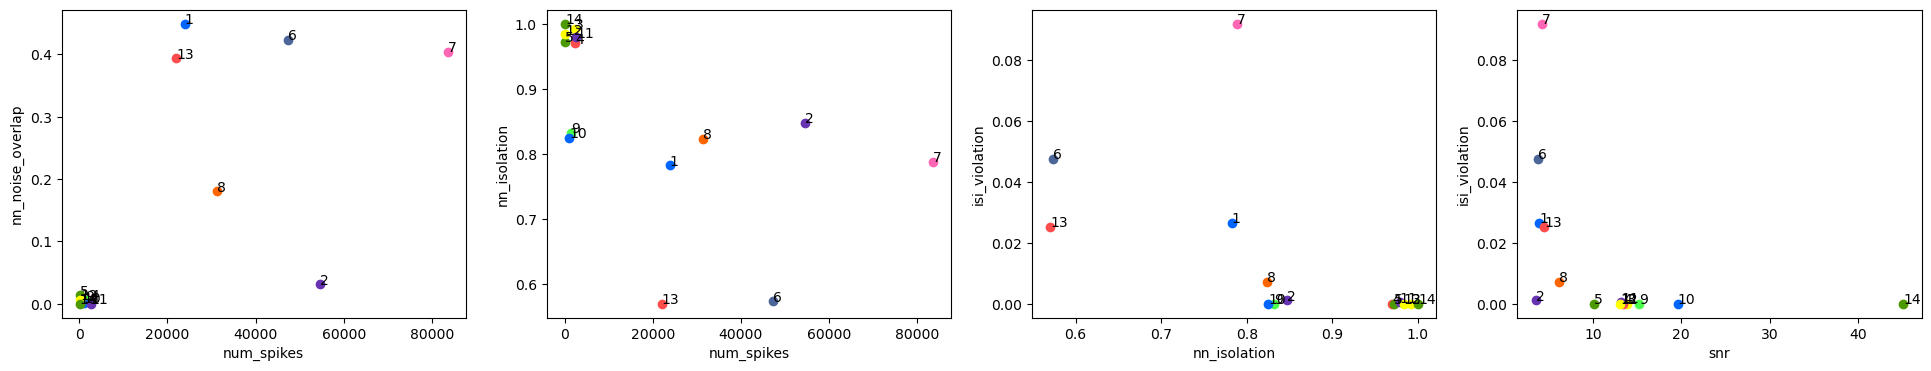

In [190]:
fig,axes=plt.subplots(1,4,figsize=(24,4),sharex=False,sharey=False)

color_ind = 0
for i in range(len(nwb_units.index)):
    axes[0].scatter(metric_pd.iloc[i]['num_spikes'],metric_pd.iloc[i]['nn_noise_overlap'],color=color_palet[color_ind])
    axes[0].text(metric_pd.iloc[i]['num_spikes'],metric_pd.iloc[i]['nn_noise_overlap'],str(i+1))
    
    
    axes[1].scatter(metric_pd.iloc[i]['num_spikes'],metric_pd.iloc[i]['nn_isolation'], color=color_palet[color_ind])
    axes[1].text(metric_pd.iloc[i]['num_spikes'],metric_pd.iloc[i]['nn_isolation'],str(i+1))
    
    
    axes[2].scatter(metric_pd.iloc[i]['nn_isolation'],metric_pd.iloc[i]['isi_violation'], color=color_palet[color_ind])
    axes[2].text(metric_pd.iloc[i]['nn_isolation'],metric_pd.iloc[i]['isi_violation'],str(i+1))

    axes[3].scatter(metric_pd.iloc[i]['snr'],metric_pd.iloc[i]['isi_violation'], color=color_palet[color_ind])
    axes[3].text(metric_pd.iloc[i]['snr'],metric_pd.iloc[i]['isi_violation'],str(i+1))
    
    color_ind = (color_ind+1) % color_palet.shape[0]


    
axes[0].set_xlabel('num_spikes')
axes[0].set_ylabel('nn_noise_overlap')

axes[1].set_xlabel('num_spikes')
axes[1].set_ylabel('nn_isolation')

axes[2].set_xlabel('nn_isolation')
axes[2].set_ylabel('isi_violation')

axes[3].set_xlabel('snr')
axes[3].set_ylabel('isi_violation')

In [191]:
from sklearn import svm
def find_noise_units(metric_pd):
    success = 0
    
    snr = np.array(metric_pd.snr)
    nn_isolation = np.array(metric_pd.nn_isolation)
    isi_violation = np.array(metric_pd.isi_violation)
    num_spikes = np.array(metric_pd.num_spikes)
    
    # pick out num_spikes for units with SNR >= 15
    largeAmp_ind = np.argwhere(snr >= 15).ravel()
    if len(largeAmp_ind) == 0:
        largeAmp_ind = np.argwhere(snr >= 10).ravel()
    if len(largeAmp_ind) == 0:
        return success,[]
        
    baseThreshold = np.mean(num_spikes[largeAmp_ind])
    
    # adaptive thresholding
    multipliers = [10, 20, 100, 200]
    X = np.hstack((nn_isolation.reshape((-1,1)),isi_violation.reshape((-1,1)),snr.reshape((-1,1))))
    for m in multipliers:
        spike_num_threshold = baseThreshold * m;
        y = (num_spikes >= spike_num_threshold).astype('int')
        clf = svm.LinearSVC(C=300)
        clf.fit(X, y)
        yPred = clf.predict(X)
        if np.sum(np.abs(y - yPred)) == 0:
            success = 1;
            noiseUnits = np.argwhere(y).ravel()+1
            break
            
    return success,noiseUnits
    

In [195]:
success, noiseUnits = find_noise_units(metric_pd)
print(success)
print(noiseUnits)

1
[ 1  2  6  7  8 13]


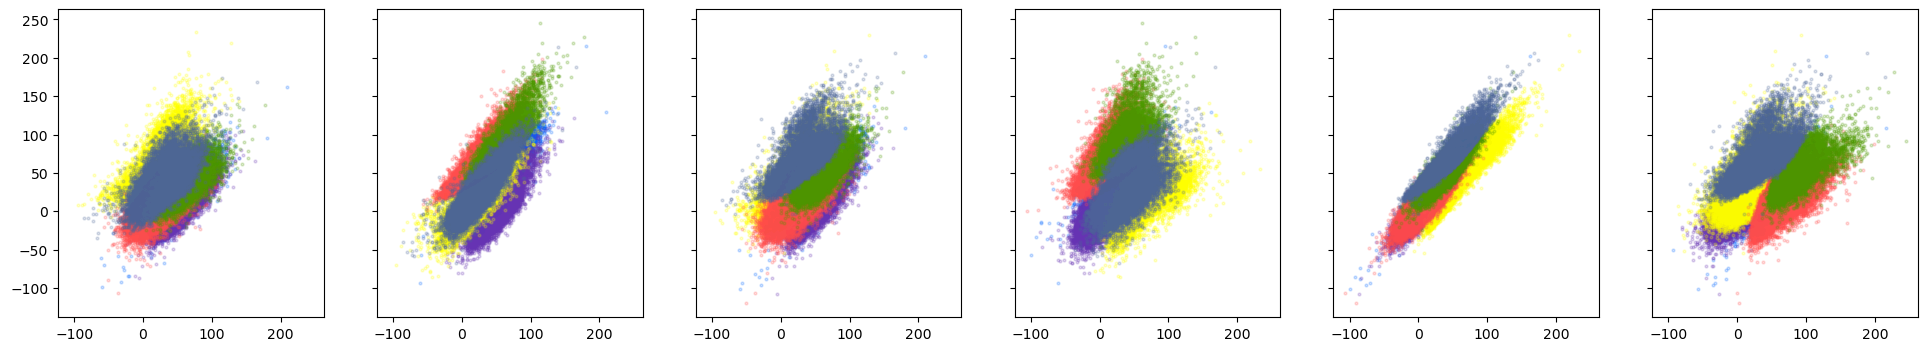

In [193]:
fig,axes=plt.subplots(1,6,figsize=(24,4),sharex=True,sharey=True)

## get amplitude
color_ind=0
for u in noiseUnits:#nwb_units.index:1,3,5,12,6,
    for p in range(6):
        e1,e2=pair[p]
        axes[p].scatter(-waves[u][:,e1],-waves[u][:,e2], color=color_palet[color_ind], s=4,alpha = 0.2)
    color_ind = (color_ind+1) % color_palet.shape[0]

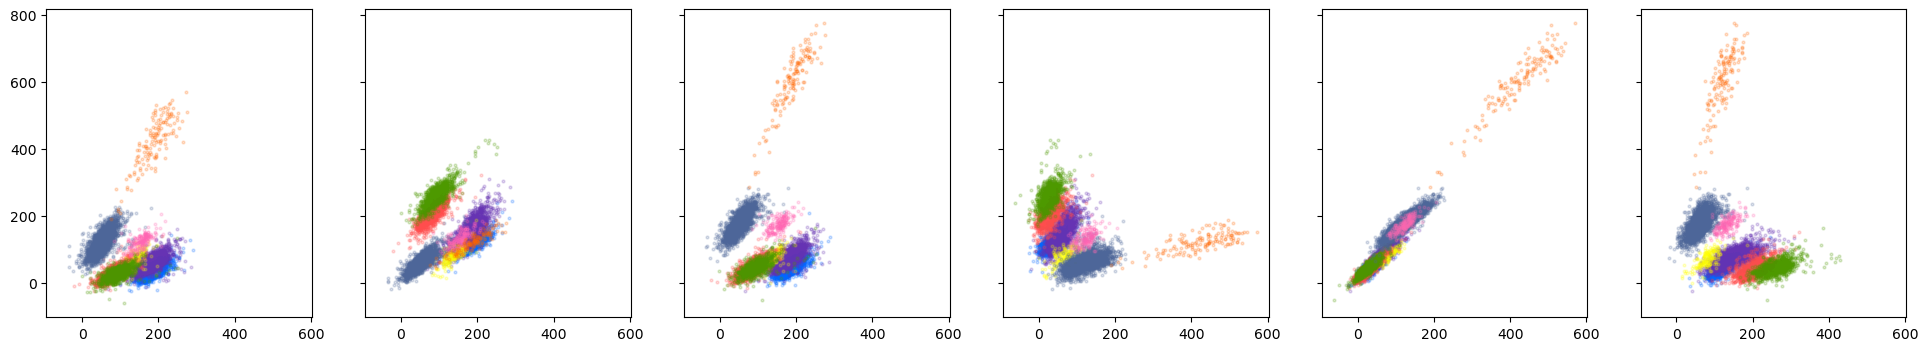

In [194]:
fig,axes=plt.subplots(1,6,figsize=(24,4),sharex=True,sharey=True)

## get amplitude
color_ind=0
for u in np.setdiff1d(nwb_units.index,noiseUnits):#nwb_units.index:
    for p in range(6):
        e1,e2=pair[p]
        axes[p].scatter(-waves[u][:,e1],-waves[u][:,e2], color=color_palet[color_ind], s=4,alpha = 0.2)
    color_ind = (color_ind+1) % color_palet.shape[0]

### Below are something for figurl

In [73]:
    '''
    populate UnitMarks table
    '''
    mark_parameters_keys = pd.DataFrame(CuratedSpikeSorting & curation_keys)
    mark_parameters_keys['mark_param_name'] = 'default'
    mark_parameters_keys = (mark_parameters_keys
                            .loc[:, UnitMarkParameters.primary_key]
                            .to_dict('records'))
    UnitMarkParameters().insert(
        mark_parameters_keys,
        skip_duplicates=True)
    
    UnitMarks.populate(UnitMarkParameters & mark_parameters_keys)

[2023-09-29 20:51:01,717][WARNING]: Skipped checksum for file with hash: 988f72ef-29b3-bdaa-e942-adf693765fee, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_NKD46ZH1FT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_7D4GY3MVYH.nwb


[2023-09-29 20:51:12,335][WARNING]: Skipped checksum for file with hash: 6b948148-32e3-05ea-9503-cd81e3d6f457, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_F240XU48US.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_MQ9WKD1MQL.nwb


[2023-09-29 20:51:20,767][WARNING]: Skipped checksum for file with hash: caaf60ac-5607-74fa-4d5f-c29f19647eee, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_RTLXSG1RWG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_4GWSPOS9MZ.nwb


[2023-09-29 20:51:29,452][WARNING]: Skipped checksum for file with hash: 07b9a43f-a4ca-fd97-6103-af751f289490, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_SG2IFMTOPX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_9MPCO5L8U1.nwb


[2023-09-29 20:51:37,539][WARNING]: Skipped checksum for file with hash: 1ae23b90-40ba-f2da-2fbe-b5cb56c4eebf, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VI97TQTVU9.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_76DHV729LO.nwb


[2023-09-29 20:51:52,464][WARNING]: Skipped checksum for file with hash: b64441f3-56bf-43b9-28a5-69e581a11882, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CXICU6WL3T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_7YWLTFH2L0.nwb


[2023-09-29 20:52:02,816][WARNING]: Skipped checksum for file with hash: c2c5c03f-1648-3dfd-6b3b-ca8d40e9b40f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FM7EX9QRIB.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_A37AX3K45C.nwb


[2023-09-29 20:52:10,418][WARNING]: Skipped checksum for file with hash: 7d8bc6a3-8f30-5b33-dd40-f3213cd235f7, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_C8SJY6CCJO.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_NFNM4V1NJ6.nwb


[2023-09-29 20:52:18,108][WARNING]: Skipped checksum for file with hash: f45e712c-ca52-2574-4556-30f3b4110139, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_RZ5T1O6KS7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_N9I484O0O2.nwb


[2023-09-29 20:52:25,372][WARNING]: Skipped checksum for file with hash: d6ad3536-c002-2763-7f1e-c8e5a020b068, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_AVKCY3ME85.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SLBL8Z4M6E.nwb


[2023-09-29 20:52:38,533][WARNING]: Skipped checksum for file with hash: ac541217-6ec9-082f-e6f4-22d35cbce6cd, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IYRKWTSM8R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_UZCQPJBMKM.nwb


[2023-09-29 20:52:47,084][WARNING]: Skipped checksum for file with hash: dae03ca9-efc0-052b-6a01-a42d48befcb8, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1WS7DO9ZXH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_1YV5JH6Z00.nwb


[2023-09-29 20:52:54,885][WARNING]: Skipped checksum for file with hash: 5cdff2db-214b-3a2a-8a62-49809d6db42b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JYG6UICU6V.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_HFTXRRB60E.nwb


[2023-09-29 20:53:02,342][WARNING]: Skipped checksum for file with hash: 2eb60337-b94e-a5d9-5dae-c826514ff13e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_NA5Z3GLNY6.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_DM2B5IKWUY.nwb


[2023-09-29 20:53:09,379][WARNING]: Skipped checksum for file with hash: b40f4904-6904-a6c9-37e8-67696f96437b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_3IGRISFRXU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ATJ17GNDG6.nwb


[2023-09-29 20:53:21,784][WARNING]: Skipped checksum for file with hash: d0a66d4d-8a8f-c64b-74d1-5e31f8ce0c10, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_99JU8IZWTD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_LA9CLB5B9R.nwb


[2023-09-29 20:53:31,337][WARNING]: Skipped checksum for file with hash: 4a23bedb-93ad-6ca8-e632-0365f2c3e8c1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_11KEQ1I5M8.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_FBUDG3IWHO.nwb


[2023-09-29 20:53:40,343][WARNING]: Skipped checksum for file with hash: 67d29020-f679-d994-8d46-b96f89e56d48, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_BTF3YJ7UHN.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_CYESFF5E47.nwb


[2023-09-29 20:54:50,672][WARNING]: Skipped checksum for file with hash: 6086b28b-cf25-2789-becf-f7be63b90633, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VRS7KUDRCI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_APFO58H3AE.nwb


[2023-09-29 20:56:10,039][WARNING]: Skipped checksum for file with hash: b6fa702e-6f83-999e-a5a1-a00b3a77149e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4XK2LCMKJL.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_9Z721S1NWW.nwb


[2023-09-29 20:56:32,484][WARNING]: Skipped checksum for file with hash: 9b073e7b-86b4-f426-4608-e9cbe9e2518a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DDS4RV02RI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_G03ECHO5I6.nwb


[2023-09-29 20:56:45,537][WARNING]: Skipped checksum for file with hash: ff5d4016-31a8-b775-f491-bc20e7aa4b08, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PEEDTLHXFE.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_JR68IVRL1Q.nwb


[2023-09-29 20:56:54,464][WARNING]: Skipped checksum for file with hash: 10e20922-aac0-bd2a-832f-0781de14daa8, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KGNKWDSWBI.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_FT5EQINAAB.nwb


[2023-09-29 20:57:11,901][WARNING]: Skipped checksum for file with hash: 5a18b2af-14a7-16ba-799b-90c0733e07ca, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_XYFRXBFDHM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_3V5LFFIBIW.nwb


[2023-09-29 20:57:20,978][WARNING]: Skipped checksum for file with hash: 08f957e5-5e25-5c03-9188-64d82e256130, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_Q0BVYIHQ4X.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ANHRZL5QS2.nwb


[2023-09-29 20:58:47,750][WARNING]: Skipped checksum for file with hash: e508afeb-5105-1723-729e-ec702d819bc5, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GEPNLYUZS7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_GH8VATCBUO.nwb


[2023-09-29 20:59:31,627][WARNING]: Skipped checksum for file with hash: 57073f5e-a0c4-0831-b87f-e74ede01be18, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_Q7TXNVBSCX.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_IGJZKZOADF.nwb


[2023-09-29 20:59:42,492][WARNING]: Skipped checksum for file with hash: c717d3db-7d0c-18be-71d3-1be92c6be81f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_TCH1QKWZPS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_YB1Q5HXLGF.nwb


[2023-09-29 20:59:56,078][WARNING]: Skipped checksum for file with hash: 15082797-e458-a369-0f68-a4d495af07e8, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_OMIBXYRLAT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_05W8L5107P.nwb


[2023-09-29 21:00:09,555][WARNING]: Skipped checksum for file with hash: 88ce8993-3bc4-20e5-8746-5f58d69ae687, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_SWO5ML4YEA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_6WFRMJ8N3R.nwb


[2023-09-29 21:00:29,131][WARNING]: Skipped checksum for file with hash: 93aeac61-6d98-b9f7-9d2a-af4140fdbadf, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_N2B9SPBHXH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_E4G9TCBK79.nwb


[2023-09-29 21:00:45,713][WARNING]: Skipped checksum for file with hash: ebb1e288-fee9-16c6-e555-a73e1d92862e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_7EF1VCKWAD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_T3N1C98D2Y.nwb


[2023-09-29 21:00:55,033][WARNING]: Skipped checksum for file with hash: 20fb438c-dede-0212-f2ee-f43966e7c141, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KRX6RV6VBW.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_DA6DEYJBSA.nwb


[2023-09-29 21:01:12,139][WARNING]: Skipped checksum for file with hash: 3cc803f5-71b5-dbc2-0138-a61afdfef6a5, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VI7M3L7F4G.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_8TI2S2V1UL.nwb


[2023-09-29 21:01:33,223][WARNING]: Skipped checksum for file with hash: 10b621a2-66da-7d1e-696a-f6b3bcec9aed, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PSJDQ88HM1.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_A4RTL3FQ2A.nwb


[2023-09-29 21:01:51,341][WARNING]: Skipped checksum for file with hash: 9ef0315a-90d0-1dc1-6831-759cb71c8ab3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EH8GAIPZMC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_JOAWC10AYN.nwb


[2023-09-29 21:02:00,636][WARNING]: Skipped checksum for file with hash: 2f9df0aa-0bc5-cf20-9021-2f60fb3212b2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_U302I9QCRY.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_UOXNP9C6JS.nwb


[2023-09-29 21:02:14,046][WARNING]: Skipped checksum for file with hash: 1d45b7a4-204b-0ff3-6a51-e6f487e420a2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CXHCWO9WQT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_M9EECRET0E.nwb


[2023-09-29 21:02:23,255][WARNING]: Skipped checksum for file with hash: a5348c65-f306-ea81-ccd0-78ce18f3e2ba, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QYZAT0S6YF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_IGRVZW3ER8.nwb


[2023-09-29 21:02:42,305][WARNING]: Skipped checksum for file with hash: b538ac54-3e9a-0803-c6cf-e28e41ee4d30, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KYV5QU4SJJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_VIN2DTV9UO.nwb


[2023-09-29 21:03:02,395][WARNING]: Skipped checksum for file with hash: 09270adf-2429-5c9d-ebf7-006ee5d45783, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_S5B64MQZ1T.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_L5SX8V8QS9.nwb


[2023-09-29 21:03:11,966][WARNING]: Skipped checksum for file with hash: 53e98381-ec5e-6ff4-9cee-9fa3246c3733, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_BDO7INZGDH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_IQUY9LXHV8.nwb


[2023-09-29 21:03:34,296][WARNING]: Skipped checksum for file with hash: 1a9e1b0e-10df-304d-f305-162e35ed382c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_9NSI2HDYFM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_5KFCUQYZPS.nwb


[2023-09-29 21:03:44,575][WARNING]: Skipped checksum for file with hash: 41a61845-ce12-e55a-dd2c-09caa0cfa9a3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GLRTGXBBUZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_TOLUJMR3VG.nwb


[2023-09-29 21:04:02,593][WARNING]: Skipped checksum for file with hash: 559acf94-4f66-4fe4-f621-1928615ee51e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_N3KFW3BESA.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SPJCM7XIFB.nwb


[2023-09-29 21:04:20,499][WARNING]: Skipped checksum for file with hash: f588249f-dfa1-68f6-1523-e410fbf76ce9, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_267LY4J8GT.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_HJVS58LA9R.nwb


[2023-09-29 21:04:29,372][WARNING]: Skipped checksum for file with hash: 64419217-584a-d124-177c-61ff3e1f8127, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VRB1P3U52B.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_KJOMM19S6I.nwb


[2023-09-29 21:04:46,697][WARNING]: Skipped checksum for file with hash: fe2b1820-876d-0d89-2998-5ddf5d5d02f9, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JIVZEYQMJL.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_DL6WL5FO5P.nwb


[2023-09-29 21:04:55,327][WARNING]: Skipped checksum for file with hash: 6eee20c2-8b41-30de-f60a-1b350bf88e01, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_58HD911X4P.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_0U2XKZTSMT.nwb


[2023-09-29 21:05:11,290][WARNING]: Skipped checksum for file with hash: 4ab9184a-b9d4-551e-be04-7f8e520530fa, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_YJVG6QOKN6.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ZTCIOEE3O1.nwb


[2023-09-29 21:05:25,875][WARNING]: Skipped checksum for file with hash: 48018cf0-f868-d803-0eb0-e1734001397a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_V5BEF65UHH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_GSNCZRVQ4D.nwb


[2023-09-29 21:05:35,137][WARNING]: Skipped checksum for file with hash: 015d2153-616f-7db5-c4b8-c11c9db03334, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_48S287VWI4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_F2MS92VVYX.nwb


[2023-09-29 21:05:44,005][WARNING]: Skipped checksum for file with hash: de64a7e0-add8-94a5-acfd-1e5b48b3f64c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_W2TSSV678L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_JY9WYXHFTE.nwb


[2023-09-29 21:06:01,295][WARNING]: Skipped checksum for file with hash: 0217c6ad-3590-725b-f412-65446dbbc3ff, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EQZ6X6D53D.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_7QQHAOWMHZ.nwb


[2023-09-29 21:06:18,670][WARNING]: Skipped checksum for file with hash: ecc02f04-a2c7-5467-69cf-bd13be64d405, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UIFPB088PF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_914Q0Z2LSV.nwb


[2023-09-29 21:06:33,509][WARNING]: Skipped checksum for file with hash: 78e33220-bb9e-d2e3-45f7-ffeaa03940c3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_L4EBZ26P73.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_1Y2GG82CPE.nwb


[2023-09-29 21:06:41,886][WARNING]: Skipped checksum for file with hash: f6d5a8fb-e8b1-53ea-8485-74df36351658, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_J6KVOQYQK4.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_1EF55BQ6AZ.nwb


[2023-09-29 21:06:49,707][WARNING]: Skipped checksum for file with hash: 785b34d5-7be3-5998-6ecd-634dfe90bf57, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_VJJR8B53JS.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_T1PCQ9ABEE.nwb


[2023-09-29 21:07:05,739][WARNING]: Skipped checksum for file with hash: f24c154a-bdd6-9c1d-84ee-465c52382aa3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_3L2VP16K1L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_ET6O9PQ3GV.nwb


[2023-09-29 21:07:21,796][WARNING]: Skipped checksum for file with hash: 6b42f92a-8a5a-e844-c174-fbd1a4f9bf0c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_564L2SWMFH.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_Q55EVWVTRP.nwb


[2023-09-29 21:07:35,589][WARNING]: Skipped checksum for file with hash: 6e42a444-f2c4-a356-5ede-1121da5f8b5f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_5RM0WQ740M.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_4MEP8DUCVL.nwb


[2023-09-29 21:07:44,047][WARNING]: Skipped checksum for file with hash: d93f8720-d3ef-7c0d-c422-f60aa1af17c0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UUFUNX4T47.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_2HTFODTQSU.nwb


[2023-09-29 21:08:00,637][WARNING]: Skipped checksum for file with hash: 13840ed7-5615-f009-9cc0-e92841a3692d, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PDK8X6U2XZ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_CAI1KXCY1E.nwb


[2023-09-29 21:08:16,467][WARNING]: Skipped checksum for file with hash: 237b98fa-e60f-5f91-df4a-46c4a86b1534, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EU9KMD506R.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_K8RZV8BAUU.nwb


[2023-09-29 21:08:32,281][WARNING]: Skipped checksum for file with hash: f9d14473-1412-8b1e-7eb9-792141b2a431, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_E81KGRE2K7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SKLWFOB1FX.nwb


[2023-09-29 21:08:47,266][WARNING]: Skipped checksum for file with hash: ea582fc3-cf03-6a82-2050-a024b0f7bcec, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QFCB1VGM0L.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_2T4ACN42GU.nwb


[2023-09-29 21:09:06,015][WARNING]: Skipped checksum for file with hash: 60bdb790-3a8f-5de7-34f6-6737845a1e0a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_P0I97UCF69.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_EG16KNNQAF.nwb


[2023-09-29 21:09:14,706][WARNING]: Skipped checksum for file with hash: 32447a4c-6b64-8f69-0d5b-04d84b5eb814, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_ZHB46VSRIU.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_4XJ08YZWSV.nwb


[2023-09-29 21:09:32,150][WARNING]: Skipped checksum for file with hash: 174be5b0-709d-6883-c512-0b266b60f88d, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_D39JW3XXH0.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_AO5P506GSD.nwb


[2023-09-29 21:09:48,590][WARNING]: Skipped checksum for file with hash: 8a387d02-24de-0ef4-5d27-3d24666ce738, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_Q96WJJSNJM.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_R5KCW658ZP.nwb


[2023-09-29 21:10:08,716][WARNING]: Skipped checksum for file with hash: 558ff6fd-3c8d-204a-0e8d-200ee96f2091, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_LJGF02PKHD.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_HSZDZPFPLB.nwb


[2023-09-29 21:10:29,995][WARNING]: Skipped checksum for file with hash: 0f323274-c49f-2a02-dba7-a55f32285018, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KR04WC3A80.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_950FWZMHMW.nwb


[2023-09-29 21:10:39,500][WARNING]: Skipped checksum for file with hash: ff427324-82d8-aa0a-576f-6d5f1f7d0d19, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_PP6OZKK305.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_FNZ2FS6QJA.nwb


[2023-09-29 21:10:54,245][WARNING]: Skipped checksum for file with hash: 16dd0bfc-4472-35ce-b7dc-161ba5ca17f4, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QEKATJZPFR.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_MYB5CTVNKI.nwb


[2023-09-29 21:11:09,516][WARNING]: Skipped checksum for file with hash: be8acc86-2184-18df-1776-9f2929d2d03f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1QOBR98QXG.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_SAK2I4T1HP.nwb


[2023-09-29 21:11:23,409][WARNING]: Skipped checksum for file with hash: d087ad54-957d-5d1f-7187-dc29470ca0d0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_D6MEWWXCMC.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_TAOFCUEG8R.nwb


[2023-09-29 21:11:39,525][WARNING]: Skipped checksum for file with hash: 28a2dc2b-9afb-2375-de2f-a9195ad6795e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GKPMJ5XK6D.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_U1HRAOYRGR.nwb


[2023-09-29 21:11:47,513][WARNING]: Skipped checksum for file with hash: 8f6cf9ff-747f-8dc1-f51c-5b2d2a0de8df, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_5H7ICBCXAJ.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_8A677O9VDV.nwb


[2023-09-29 21:12:03,168][WARNING]: Skipped checksum for file with hash: 4002e523-44a2-c8c0-13da-cb1783b5b5fb, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_441LXJNJU7.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_NFORB43QL4.nwb


[2023-09-29 21:12:10,732][WARNING]: Skipped checksum for file with hash: 236b5490-0073-69fc-5b2f-37e909f0f2ca, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_QC543LWVBF.nwb


extract waveforms memmap:   0%|          | 0/1 [00:00<?, ?it/s]

/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_10' has data shape (126527, 6) which is not compliant with NWB 2.5 and greater. The second dimension should hav

Writing new NWB file eliot20221022_5J1KJ8E8J9.nwb


In [144]:
key={"nwb_file_name": nwb_copy_file_name,"sort_group_id":14,
             "sort_interval_name": session_interval[0],"sorter":"mountainsort4"}
UnitMarks & key

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,analysis_file_name name of the file,marks_object_id the NWB object that stores the marks
0,eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_GH8VATCBUO.nwb,3e8a5665-fb96-4a8b-b36b-4bf6bb260d95


In [145]:
marks_df = (UnitMarks & key).fetch1_dataframe()

[2023-09-29 22:17:33,008][WARNING]: Skipped checksum for file with hash: 4092bafd-d9ce-d7a6-debc-0b14f5e9690b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GH8VATCBUO.nwb


In [143]:
marks_df

,amplitude_0000,amplitude_0001,amplitude_0002,amplitude_0003
time,,,,
1.666462e+09,-20.0,-24.0,-55.0,6.0
1.666462e+09,-3.0,-77.0,-10.0,2.0
1.666462e+09,-51.0,-75.0,-186.0,-50.0
1.666462e+09,-56.0,-75.0,-171.0,-55.0
1.666462e+09,-55.0,-53.0,-152.0,-40.0
...,...,...,...,...
1.666464e+09,-54.0,-48.0,-47.0,-60.0
1.666464e+09,-5.0,-67.0,-32.0,-28.0
1.666464e+09,2.0,-17.0,-15.0,-45.0


In [87]:
for s in range(len(session_interval)):
    '''
    include position info
    '''
    curation_keys=(Curation & {"nwb_file_name": nwb_copy_file_name,
                               "sorter":"mountainsort4",
                               "sort_interval_name":session_interval[s]}).fetch("KEY")
    
    mark_parameters_keys = pd.DataFrame(CuratedSpikeSorting & curation_keys)
    mark_parameters_keys['mark_param_name'] = 'default'
    mark_parameters_keys = (mark_parameters_keys
                            .loc[:, UnitMarkParameters.primary_key]
                            .to_dict('records'))

    pos_interval = (
            IntervalList &
            {'nwb_file_name': nwb_copy_file_name,
             'interval_list_name': position_interval[s]})

    marks_selection = ((UnitMarks & mark_parameters_keys) * pos_interval)
    marks_selection = (pd.DataFrame(marks_selection)
                       .loc[:, marks_selection.primary_key]
                       .to_dict('records'))
    UnitMarksIndicatorSelection.insert(marks_selection, skip_duplicates=True)
    UnitMarksIndicator.populate(marks_selection)

[2023-09-29 21:24:21,917][WARNING]: Skipped checksum for file with hash: 20fffbce-550e-8a75-689c-10f7d03b3e3f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_7D4GY3MVYH.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_J5C6WWQLHO.nwb


[2023-09-29 21:24:54,654][WARNING]: Skipped checksum for file with hash: 88138a0a-5b92-80e9-7cf9-76c466717252, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_7YWLTFH2L0.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_PURZX1JF7T.nwb


[2023-09-29 21:25:22,224][WARNING]: Skipped checksum for file with hash: fbffee31-fd19-bdae-d2db-e5af458eab69, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UZCQPJBMKM.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_EF9YEJ2SAH.nwb


[2023-09-29 21:25:51,052][WARNING]: Skipped checksum for file with hash: ef019ed1-8c13-3afc-1156-8914a8cb8960, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_LA9CLB5B9R.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_GH0JUUNPF5.nwb


[2023-09-29 21:26:18,692][WARNING]: Skipped checksum for file with hash: 658a0566-c18b-fcc2-09ae-d70fef6e71ea, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_G03ECHO5I6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XC08NWX5AI.nwb


[2023-09-29 21:26:33,228][WARNING]: Skipped checksum for file with hash: 4092bafd-d9ce-d7a6-debc-0b14f5e9690b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GH8VATCBUO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_SXG1MQZLQJ.nwb


[2023-09-29 21:26:46,068][WARNING]: Skipped checksum for file with hash: 680cc687-d1b4-3797-94f0-df0a064a9fa1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_E4G9TCBK79.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_Z1EDC0LFB3.nwb


[2023-09-29 21:26:58,048][WARNING]: Skipped checksum for file with hash: 09b621a7-777e-1eec-118b-6863515a8c67, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JOAWC10AYN.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_VRPFPSMRJC.nwb


[2023-09-29 21:27:10,104][WARNING]: Skipped checksum for file with hash: 9aa0f810-a21c-41c6-c7e4-73e1ff2a18c0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_L5SX8V8QS9.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_CI7PG3ZJLY.nwb


[2023-09-29 21:27:27,837][WARNING]: Skipped checksum for file with hash: 22d5ac2d-7230-dfc2-624f-ae580cee8603, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_HJVS58LA9R.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_793T4JX6CF.nwb


[2023-09-29 21:27:58,487][WARNING]: Skipped checksum for file with hash: e98acfeb-827b-f6f2-6b57-9278fe16474a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_GSNCZRVQ4D.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_ZCF5FULZDB.nwb


[2023-09-29 21:28:33,950][WARNING]: Skipped checksum for file with hash: 4ea030ac-9bb9-20ac-d615-09d00052c57e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1Y2GG82CPE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3JBKZMYWQ9.nwb


[2023-09-29 21:29:08,213][WARNING]: Skipped checksum for file with hash: f2cbdf22-8370-23f6-6e54-8d77b8b311c2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4MEP8DUCVL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3PWI742PGL.nwb


[2023-09-29 21:29:40,007][WARNING]: Skipped checksum for file with hash: 64b23efe-4bc5-0b43-1603-226764f9965f, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_2T4ACN42GU.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_DKP20V12AE.nwb


[2023-09-29 21:29:57,611][WARNING]: Skipped checksum for file with hash: 2f37e90f-f3ff-e1cc-6c90-619fd0594107, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_HSZDZPFPLB.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_WUC7DH8SLY.nwb


[2023-09-29 21:30:11,170][WARNING]: Skipped checksum for file with hash: ed415336-9784-1788-0d6d-8e845b0f443c, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_TAOFCUEG8R.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_LZ7GF671ZN.nwb


[2023-09-29 21:30:23,583][WARNING]: Skipped checksum for file with hash: d8d97ba8-185e-d980-0d24-8f8c34a23d57, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_MQ9WKD1MQL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XEZU2TJ42F.nwb


[2023-09-29 21:30:37,064][WARNING]: Skipped checksum for file with hash: 997e9291-734d-02b5-33c9-e13cbc312f95, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_A37AX3K45C.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_HCTWBC5Y4K.nwb


[2023-09-29 21:30:47,956][WARNING]: Skipped checksum for file with hash: 1bc3d26d-58dc-e4fe-fd48-f0e981418404, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1YV5JH6Z00.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_LXYETGVPF3.nwb


[2023-09-29 21:30:58,977][WARNING]: Skipped checksum for file with hash: 92b2e1cf-2920-bc8a-6444-b6b7a5b5802d, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FBUDG3IWHO.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_C97U50DOXF.nwb


[2023-09-29 21:31:12,165][WARNING]: Skipped checksum for file with hash: b38c2a6c-caef-84fd-7ffe-9e7e302b41c2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JR68IVRL1Q.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_MKZ3XD7N8L.nwb


[2023-09-29 21:31:23,056][WARNING]: Skipped checksum for file with hash: f7bce251-d601-cae8-ea17-873dd15076e9, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IGJZKZOADF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3UKGIKHOAW.nwb


[2023-09-29 21:31:34,770][WARNING]: Skipped checksum for file with hash: e401e62f-3c11-d264-96d4-95e2065175e2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_T3N1C98D2Y.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_WNM8WMVK2P.nwb


[2023-09-29 21:31:52,613][WARNING]: Skipped checksum for file with hash: e7432a5e-af77-d0ee-0ff9-0f83f7a57b71, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_UOXNP9C6JS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_LB5JGJSD5E.nwb


[2023-09-29 21:32:10,903][WARNING]: Skipped checksum for file with hash: 43a00a56-7ef2-6e24-800d-c4d0aab003b3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IQUY9LXHV8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_F6K0CZQ7KB.nwb


[2023-09-29 21:32:21,758][WARNING]: Skipped checksum for file with hash: 36861983-4bef-f361-4514-72493d072f38, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_KJOMM19S6I.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_SDB2VYTZCV.nwb


[2023-09-29 21:32:33,509][WARNING]: Skipped checksum for file with hash: ae3c0a50-46e6-3e08-83f2-df43be360882, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_F2MS92VVYX.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_42MEVV5TFK.nwb


[2023-09-29 21:32:44,418][WARNING]: Skipped checksum for file with hash: 1e6c5d9f-a73c-a1f7-3362-34f51b413091, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_1EF55BQ6AZ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_O1QW3F40I1.nwb


[2023-09-29 21:32:55,631][WARNING]: Skipped checksum for file with hash: 7464b70a-81a9-7659-e6ab-d74ff93ac44b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_2HTFODTQSU.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_ACOXXM76N5.nwb


[2023-09-29 21:33:09,446][WARNING]: Skipped checksum for file with hash: 012a8211-6f13-08e5-9487-7cbbb7d22bd4, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_EG16KNNQAF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_JIT06D5ES1.nwb


[2023-09-29 21:33:20,533][WARNING]: Skipped checksum for file with hash: bf7dc081-3131-2ab5-8a0e-3d7c2626e9c1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_950FWZMHMW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_79V1JQUGNO.nwb


[2023-09-29 21:33:31,664][WARNING]: Skipped checksum for file with hash: 125d1c2f-d28c-55db-fffe-249d34136fd1, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_U1HRAOYRGR.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_B8OV2XUU25.nwb


[2023-09-29 21:33:43,538][WARNING]: Skipped checksum for file with hash: ba6c3f53-4981-dc45-e56e-7371f0154b38, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4GWSPOS9MZ.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_6B17TL4PCP.nwb


[2023-09-29 21:33:53,768][WARNING]: Skipped checksum for file with hash: ccee55c5-8e96-1fb9-0456-dab452228b64, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_NFNM4V1NJ6.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_MSNXHIHR7S.nwb


[2023-09-29 21:34:04,196][WARNING]: Skipped checksum for file with hash: 08a2a834-83e0-b28d-8f2b-acb9fd57ccd0, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_HFTXRRB60E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_N35ZBMXUVM.nwb


[2023-09-29 21:34:15,132][WARNING]: Skipped checksum for file with hash: d078b9d9-4597-47c5-1732-ec65538f6d47, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CYESFF5E47.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_1TKNXCXB7X.nwb


[2023-09-29 21:34:25,408][WARNING]: Skipped checksum for file with hash: b3bc78ba-556b-6406-8803-edc952552f7e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FT5EQINAAB.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_III89DGVDA.nwb


[2023-09-29 21:34:36,794][WARNING]: Skipped checksum for file with hash: 8814c365-04f1-de62-7cfa-0c597386162e, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_YB1Q5HXLGF.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_0M24IQRK4Y.nwb


[2023-09-29 21:34:48,492][WARNING]: Skipped checksum for file with hash: 0f53bc53-1bec-5c88-bcee-a833142ccd58, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DA6DEYJBSA.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_UFMLXOI4XE.nwb


[2023-09-29 21:34:58,686][WARNING]: Skipped checksum for file with hash: 50927b5c-511b-7f11-f17b-634fb8310d9b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_M9EECRET0E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_S1NLBMCD0N.nwb


[2023-09-29 21:35:09,710][WARNING]: Skipped checksum for file with hash: 6190ad37-0a89-de29-57bb-8b98e1c7f7a6, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_5KFCUQYZPS.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_W9T0ZEPPH3.nwb


[2023-09-29 21:35:19,956][WARNING]: Skipped checksum for file with hash: c4393696-53af-8722-7f1d-0161bbb644de, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DL6WL5FO5P.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_58U8DCECOB.nwb


[2023-09-29 21:35:33,168][WARNING]: Skipped checksum for file with hash: e92f1715-d8d0-05d0-3573-e44079fe9f44, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_JY9WYXHFTE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_3RXHXEYUFF.nwb


[2023-09-29 21:35:44,168][WARNING]: Skipped checksum for file with hash: c08e5ff8-9412-9fa1-d778-dcf584db693b, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_T1PCQ9ABEE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_H9ABZ33OFG.nwb


[2023-09-29 21:35:54,292][WARNING]: Skipped checksum for file with hash: d4c12980-65ab-9e25-6406-36b76f4ed2cb, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_CAI1KXCY1E.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_855XTP6XUL.nwb


[2023-09-29 21:36:04,646][WARNING]: Skipped checksum for file with hash: c00372c8-825a-daf0-2bd3-ef9bff7b92f3, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_4XJ08YZWSV.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_RGKMOVQNU3.nwb


[2023-09-29 21:36:15,870][WARNING]: Skipped checksum for file with hash: 762eea76-b7dd-3fb8-e2d8-e907ce077970, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_FNZ2FS6QJA.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_ODIQVOQQJH.nwb


[2023-09-29 21:36:25,915][WARNING]: Skipped checksum for file with hash: cb1a5bb4-3e6d-c166-0384-88e59622d377, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_8A677O9VDV.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_EO349MTWNM.nwb


[2023-09-29 21:36:36,229][WARNING]: Skipped checksum for file with hash: 19dfc01b-977a-4b8a-84db-dabb7b60e887, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_9MPCO5L8U1.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_846KOM9O57.nwb


[2023-09-29 21:36:47,068][WARNING]: Skipped checksum for file with hash: c1a4017c-bf85-f1af-1b7c-c498d7248823, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_N9I484O0O2.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XP824UBOZR.nwb


[2023-09-29 21:36:56,900][WARNING]: Skipped checksum for file with hash: 02bb4aab-742b-6a14-b339-d9b1d9343844, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_DM2B5IKWUY.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_HT04R4NFSR.nwb


[2023-09-29 21:37:06,888][WARNING]: Skipped checksum for file with hash: 53b3ba4e-dd56-6756-5f1f-9742324ba3a7, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_APFO58H3AE.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_SZPYBO66Y0.nwb


[2023-09-29 21:37:17,626][WARNING]: Skipped checksum for file with hash: 8a0f6660-fee6-5780-c89d-740732b7d123, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_3V5LFFIBIW.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_4WHCS71KZ4.nwb


[2023-09-29 21:37:27,531][WARNING]: Skipped checksum for file with hash: 086c3c43-f6fb-f274-f317-8af9903a8b9a, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_05W8L5107P.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_J79DA54V78.nwb


[2023-09-29 21:37:37,599][WARNING]: Skipped checksum for file with hash: 4422c49b-0b70-633d-c8d4-89ca3245f230, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_8TI2S2V1UL.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_VQ4A76CYUE.nwb


[2023-09-29 21:37:48,464][WARNING]: Skipped checksum for file with hash: bd03fc3d-02a5-130e-a8a4-17dda216c2b2, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_IGRVZW3ER8.nwb
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_0' has data shape (114791, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/pynwb/behavior.py:46: UserWarning: SpatialSeries 'series_1' has data shape (52360, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3

Writing new NWB file eliot20221022_XL482WW5D6.nwb


OperationalError: (1213, 'Deadlock found when trying to get lock; try restarting transaction')

In [96]:
(Curation & {"nwb_file_name": nwb_copy_file_name,
                      "sort_interval_name": session_interval[0],"sorter":"clusterless_thresholder"})

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,mark_param_name a name for this set of parameters,analysis_file_name name of the file,marks_object_id the NWB object that stores the marks
0,eliot20221022_.nwb,0,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_0_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_AI5BJ9LF3F.nwb,f2b8c213-097b-41ec-8d3c-870c15cc5010
0,eliot20221022_.nwb,2,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_2_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_74GKBCHIJ5.nwb,ee9e23b0-564e-40ce-bc2e-e107a5503800
0,eliot20221022_.nwb,4,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_4_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_MTDFBDCJGN.nwb,c66c95b9-c612-4a1f-b484-0ce32854bed9
0,eliot20221022_.nwb,5,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_5_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_22WRQV2M7S.nwb,6e91de60-89e7-4c93-8298-f81da557166f
0,eliot20221022_.nwb,13,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_13_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_NP0G5KKKSZ.nwb,cf5e966f-196f-46b5-9e87-dcba2b25f15d
0,eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_Y1WF5LGLDT.nwb,3fd9656d-aa0e-4513-a3dd-4a66f1ef9c1d
0,eliot20221022_.nwb,16,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_16_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_7M63S9DIWQ.nwb,fd9660f8-77f1-41d1-bf44-67a780178b0e
0,eliot20221022_.nwb,17,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_17_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_DFS3YH5KRS.nwb,f6824303-89c6-4335-baa2-467e3f19d12b
0,eliot20221022_.nwb,20,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_20_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_NS4TRKKUA7.nwb,b5da26c7-a16e-4313-a95e-f9ac06b99487
0,eliot20221022_.nwb,23,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,clusterless_thresholder,default,eliot20221022_.nwb_02_Seq2Session1_23_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,default,eliot20221022_BUN92SF6T0.nwb,0bebaaac-8a88-4c53-bb20-d519ef39c0a2


In [91]:
marks = (UnitMarksIndicator & {"nwb_file_name": nwb_copy_file_name,
                      "sort_interval_name": session_interval[0],
                      "sort_group_id": 14,
                     "sorter":"mountainsort4"}).fetch_xarray()

[2023-09-29 21:44:24,747][WARNING]: Skipped checksum for file with hash: c5aaecce-704e-7805-ce92-cb836a363c42, and path: /stelmo/nwb/analysis/eliot20221022/eliot20221022_SXG1MQZLQJ.nwb


In [92]:
marks

<xarray.DataArray (time: 1117997, marks: 4, electrodes: 1)>
array([[[ nan],
        [ nan],
        [ nan],
        [ nan]],

       [[ nan],
        [ nan],
        [ nan],
        [ nan]],

       [[-23.],
        [-37.],
        [-34.],
        [-50.]],

       ...,

       [[  2.],
        [-17.],
        [-15.],
        [-45.]],

       [[-43.],
        [  9.],
        [-49.],
        [  0.]],

       [[ nan],
        [ nan],
        [ nan],
        [ nan]]], dtype=float32)
Coordinates:
  * time        (time) float64 1.666e+09 1.666e+09 ... 1.666e+09 1.666e+09
  * marks       (marks) <U14 'amplitude_0000' ... 'amplitude_0003'
  * electrodes  (electrodes) int64 14

In [51]:
entries=(Curation & {"nwb_file_name": nwb_copy_file_name,"sorter":"mountainsort4"}).fetch(as_dict=True)
curation_keys=[]
for e in entries:
    e['new_curation_uri']=""
    for l in ['parent_curation_id','curation_labels','merge_groups','quality_metrics','description','time_of_creation']:
        e.pop(l)
    CurationFigurlSelection.insert1(e)

In [60]:
CurationFigurl().populate({"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'})

Preparing spikesortingview data
Computing sha1 of /stelmo/nwb/recording/eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus/traces_cached_seg0.raw
Initial pass: segment 0
Segment 0 of 2
Segment 1 of 2


In [62]:
(CurationFigurl & {"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'}).fetch1('url')

'https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://3a28d6a1a2da51f22c280812f2a137929194286f&s={"sortingCuration":"sha1://f9603a5a017b4dfa9c902482ad5ab59781fedaac"}&label=eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus%20eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_09add1ea_spikesorting'

In [64]:
(CurationFigurl & {"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'})

curation_id a number correponding to the index of this curation,nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,url,initial_curation_uri,new_curation_uri
0,eliot20221022_.nwb,14,02_Seq2Session1,franklab_tetrode_hippocampus,Shijie Gu,mountainsort4,CA1_tet_Shijie,eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_ampl_1500_prop_075_1ms_artifact_removed_valid_times,"https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://3a28d6a1a2da51f22c280812f2a137929194286f&s={""sortingCuration"":""sha1://f9603a5a017b4dfa9c902482ad5ab59781fedaac""}&label=eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus%20eliot20221022_.nwb_02_Seq2Session1_14_franklab_tetrode_hippocampus_09add1ea_spikesorting",sha1://f9603a5a017b4dfa9c902482ad5ab59781fedaac,


In [63]:
(Curation & {"nwb_file_name": nwb_copy_file_name,
             "sorter":"mountainsort4",
             "sort_group_id":14,
             "sort_interval_name":'02_Seq2Session1'}).fetch1("curation_labels")

{}